In [1]:
import os 
import sys
from tqdm import tqdm
import importlib
import numpy as np
import pickle
import tensorflow as tf
import matplotlib.pyplot as plt

module_path = '/home/lun/project-basileus/seq-gan/'
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
if 'sgtlstm' in sys.modules:
    importlib.reload(sys.modules['sgtlstm'])

from sgtlstm.utils import load_fixed_length_sequence_from_pickle, create_dataset, recover_timedelta_to_timestamp
from sgtlstm.SeqGan import build_G, build_D, build_critic
from sgtlstm.TimeLSTM import TimeLSTM0, TimeLSTM1, TimeLSTM2, TimeLSTM3
# from sgtlstm.train import generate_batch_sequence_by_rollout, train_discriminator, train_generator

## Load data 

In [3]:
pos_data_path = '/home/lun/project-basileus/seq-gan/data/long_seqs_v5/positive_long_sequences.pickle'
neg_data_path = '/home/lun/project-basileus/seq-gan/data/long_seqs_v5/negative_long_sequences.pickle'

pos_event_type_seqs, pos_timestamp_seqs = load_fixed_length_sequence_from_pickle(pos_data_path, to_timedelta=True, end_token=0)
neg_event_type_seqs, neg_timestamp_seqs = load_fixed_length_sequence_from_pickle(neg_data_path, to_timedelta=True, end_token=0)

## Global Variables 

In [4]:
BATCH_SIZE = 64
T = 20 + 1
VOCAB = ['END/PADDING', 'INIT', 'start', 'view', 'click', 'install']
EVENT_VOCAB_DIM = len(VOCAB)
EMB_DIM = 5
HIDDEN_DIM = 32

END_TOKEN = 0
MAX_TIME = 1024

## Load pretrained model

In [5]:
discriminator = build_D(
    T = T,
    event_vocab_dim = EVENT_VOCAB_DIM,
    emb_dim = EMB_DIM,
    hidden_dim= HIDDEN_DIM,
)

discriminator.build(input_shape=((BATCH_SIZE, T, 1), (BATCH_SIZE, T, 1)))

D_save_path = './experiment_results/long_seqs_no_gm/init_pretrained/pretrained_disc_weights/model.tf'
discriminator.load_weights(D_save_path)

In [6]:
generator = build_G(
    batch_size=BATCH_SIZE,
    event_vocab_dim = EVENT_VOCAB_DIM,
    emb_dim = EMB_DIM,
    hidden_dim= HIDDEN_DIM)

generator.build(input_shape=((BATCH_SIZE, T, 1), (BATCH_SIZE, T, 1)))

G_save_path = './experiment_results/long_seqs_no_gm/init_pretrained/pretrained_gen_weights/model.tf'
generator.load_weights(G_save_path)

minimum variance 1 !


## Create a critic network

In [7]:
critic = build_critic(
    batch_size=BATCH_SIZE,
    event_vocab_dim = EVENT_VOCAB_DIM,
    emb_dim = EMB_DIM,
    hidden_dim= HIDDEN_DIM)

using sigmoid!


# functions in training

In [8]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras import Sequential
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.layers import Input, LSTM, Embedding, Reshape, Dense
import tensorflow_probability as tfp
from tensorflow_probability import distributions as tfd

from sgtlstm.TimeLSTM import TimeLSTM0, TimeLSTM1, TimeLSTM2, TimeLSTM3

tf.keras.backend.set_floatx('float64')

In [77]:
def generate_batch_sequence_by_rollout(
        G, batch_size, T, end_token=0, init_token=1.0, max_time=1024, verbose=False):
    # Begin from dummy init state (init_token=1, init_timestamp=0.0)
    curr_state_et = np.zeros([batch_size, 1, 1])
    curr_state_et[:, 0, 0] = init_token

    curr_state_ts = np.zeros([batch_size, 1, 1])
    curr_state_ts[:, 0, 0] = 0.0

    all_state_et = curr_state_et
    all_state_ts = curr_state_ts

    episode_token_probs = tf.constant(1., dtype=tf.float64, shape=(batch_size, 1))
    gaussian_log = tf.constant(0., dtype=tf.float64, shape=(batch_size, 1))

    G.reset_states()

    for step in range(1, T):  # sequence length
        token_prob, time_out = G([curr_state_et, curr_state_ts])

        sampled_et = tf.random.categorical(tf.math.log(token_prob), num_samples=1, dtype=tf.int32)
        sampled_et = tf.reshape(sampled_et, [batch_size, 1, 1]).numpy().astype(float)

        # get the chosen token probability per batch for each step
        sampled_et_indices = sampled_et.squeeze().astype(int).tolist()
        sampled_token_prob = token_prob.numpy()[np.arange(len(token_prob)), sampled_et_indices].reshape((batch_size, 1))
        episode_token_probs = tf.concat([episode_token_probs, sampled_token_prob], axis=1)

        # stop genererating once hit end_token
        cond_end_token = tf.equal(curr_state_et, end_token)
        curr_state_et = tf.where(cond_end_token, curr_state_et, sampled_et)
        all_state_et = tf.concat([all_state_et, curr_state_et], axis=1)

        # generate one timstamp using time_out
        sampled_ts_raw = time_out.sample()
        sampled_ts = tf.clip_by_value(tf.reshape(sampled_ts_raw, (batch_size, 1, 1))
                                      , clip_value_min=1, clip_value_max=max_time)

        # get the gaussian log likelihood for the sampled timestamps
        sampled_gaussian_log = time_out.log_prob(sampled_ts_raw)
        gaussian_log = tf.concat([gaussian_log, sampled_gaussian_log], axis=1)

        # stop generating once hit end_token
        curr_state_ts = tf.where(cond_end_token, curr_state_ts, sampled_ts)
        all_state_ts = tf.concat([all_state_ts, curr_state_ts], axis=1)

    return all_state_et, all_state_ts, episode_token_probs, gaussian_log


In [78]:
def generate_sequences(N_gen, generator, batch_size, T, recover_to_timestamp=True):
    """
        Generate sequences batch per batch
    :param N_gen: total number of seqs to be generated
    :param generator:
    :param batch_size:
    :param T:
    :param recover_to_timestamp: whether to recover time deltas to absolute timestamps
    :return: a python list of shape [N_gen, T, 2]
    """
    all_type_seq = None
    all_time_seq = None
    N = 0

    while N < N_gen:
        batch_state_et, batch_state_ts, _, _ = generate_batch_sequence_by_rollout(generator, batch_size, T,
                                                                                  end_token=0, init_token=1.0,
                                                                                  max_time=1024, verbose=False)

        batch_type_seq = batch_state_et.numpy()
        batch_time_seq = batch_state_ts.numpy()

        # recover time delta to time stamps
        if recover_to_timestamp:
            batch_time_seq = np.cumsum(batch_time_seq, axis=1)

        if all_type_seq is None:
            all_type_seq = batch_type_seq
        else:
            all_type_seq = np.concatenate([all_type_seq, batch_type_seq], axis=0)

        if all_time_seq is None:
            all_time_seq = batch_time_seq
        else:
            all_time_seq = np.concatenate([all_time_seq, batch_time_seq], axis=0)

        N += batch_size

    # concat type and time in depth
    concated_seq_list = np.concatenate([all_type_seq, all_time_seq], axis=2).tolist()

    return concated_seq_list[:N_gen]


In [83]:
def train_generator(generator, discriminator, critic_network, batch_size, T, verbose=False,
                    weight_gaussian_loss=1,
                    optimizer=Adam(lr=0.001)):
    # reset hidden states for critic network per batch
    critic_network.reset_states()

    with tf.GradientTape(persistent=True) as tape:
        states_et, states_ts, episode_token_probs, gaussian_log = generate_batch_sequence_by_rollout(generator,
                                                                                                     batch_size, T,
                                                                                                     end_token=0,
                                                                                                     init_token=1.0,
                                                                                                     max_time=1024,
                                                                                                     verbose=False)
        ce_loss_list = []
        gaussian_list = []
        critic_loss_list = []

        # run disc on whole sequence
        # true_return is the total reward for generating this seq
        true_return = discriminator((states_et, states_ts))

        for i in range(0, T):
            # TODO: should we include the init token in loss?
            curr_state_et = states_et[:, i:i + 1, :]
            curr_state_ts = states_ts[:, i:i + 1, :]

            curr_token_prob = episode_token_probs[:, i:i + 1]
            curr_gaussian_log = gaussian_log[:, i:i + 1]

            q_value = critic_network([curr_state_et, curr_state_ts])
            diff = true_return - q_value

            # At this point in history, the critic estimated that we would get a
            # total reward = `q_value` in the future. We took an action with log probability
            # of `log_prob` and ended up recieving a total reward = `true_return`.
            # The actor must be updated so that it predicts an action that leads to
            # high rewards (compared to critic's estimate) with high probability.

            mask = tf.squeeze(curr_state_et)
            curr_state_et = tf.boolean_mask(curr_state_et, mask)
            curr_state_ts = tf.boolean_mask(curr_state_ts, mask)
            curr_token_prob = tf.boolean_mask(curr_token_prob, mask)
            curr_gaussian_log = tf.boolean_mask(curr_gaussian_log, mask)

            diff = tf.boolean_mask(diff, mask)

            ce_loss_list.append(-tf.reduce_mean(tf.math.log(curr_token_prob) * diff))
            gaussian_list.append(-tf.reduce_mean(curr_gaussian_log * diff))
            critic_loss_list.append(tf.keras.losses.MSE(true_return, q_value))

        total_ce_loss = tf.reduce_sum(ce_loss_list)
        total_gaussian_loss = tf.reduce_sum(gaussian_list)

        total_generator_loss = total_ce_loss + weight_gaussian_loss * total_gaussian_loss
        total_critic_loss = tf.reduce_sum(critic_loss_list)

        if verbose:
            print('generator token loss:{}'.format(total_ce_loss))
            print('generator gaussian loss:{}'.format(total_gaussian_loss))
            print('generator critic loss:{}'.format(total_critic_loss))

    # update generator
    generator_grads = tape.gradient(total_generator_loss, generator.trainable_variables)
    optimizer.apply_gradients(zip(generator_grads, generator.trainable_variables))

    # update critic network
    critic_grads = tape.gradient(total_critic_loss, critic_network.trainable_variables)
    optimizer.apply_gradients(zip(critic_grads, critic_network.trainable_variables))

    # explicitly drop tape because persistent=True
    del tape

    return total_ce_loss, total_gaussian_loss, total_critic_loss

In [84]:
def train_discriminator(features_batch, generator, discriminator, batch_size, T, verbose=False,
                        optimizer=Adam(lr=0.001)):
    # train the discriminator
    with tf.GradientTape() as tape:
        real_et, real_ts = features_batch
        real_labels = tf.ones((batch_size, 1))  # (batch_size, 1)

        generated_et, generated_ts, episode_token_probs, gaussian_log = generate_batch_sequence_by_rollout(generator,
                                                                                                           batch_size,
                                                                                                           T,
                                                                                                           end_token=0,
                                                                                                           init_token=1.0,
                                                                                                           max_time=1024,
                                                                                                           verbose=False)
        generated_labels = tf.zeros((batch_size, 1))

        total_et = tf.concat([generated_et, real_et], axis=0)
        total_ts = tf.concat([generated_ts, real_ts], axis=0)
        total_labels = tf.concat([generated_labels, real_labels], axis=0)

        # train discriminator
        true_prob = discriminator((total_et, total_ts))

        # cross-entropy loss
        ce_loss = tf.reduce_mean(
            tf.keras.losses.binary_crossentropy(total_labels, true_prob, from_logits=False))
        discriminator_loss = ce_loss

        if verbose:
            print('total discriminator loss:{}'.format(discriminator_loss))

    grads = tape.gradient(discriminator_loss, discriminator.trainable_variables)
    optimizer.apply_gradients(zip(grads, discriminator.trainable_variables))

    return ce_loss

# Train G and D

In [13]:
train_et = pos_event_type_seqs
train_ts = pos_timestamp_seqs

train_labels = np.ones((pos_event_type_seqs.shape[0], 1))

train_features = (train_et, train_ts)
N_train = train_et.shape[0]
N_train

100000

In [14]:
optimizer = tf.keras.optimizers.Adam(lr=1e-3)
# optimizer = SGD(learning_rate=1e-4)
EPOCHS = 2
# _TOTAL_STEPS = int(EPOCHS * N_train / BATCH_SIZE)
_TOTAL_STEPS = 1000

dataset = create_dataset(train_features,
                         train_labels,
                         batch_size=BATCH_SIZE,
                         epochs=EPOCHS,
                         buffer_size=N_train)

gen_token_loss_history = []
gen_gaussian_loss_history = []
critic_network_loss_history = []

disc_ce_loss_history = []

WEIGHT_GAUSSIAN_LOSS = 1e-2
_G_STEPS = 2
_D_STEPS = 1

In [17]:
step = 0

for features_batch, _ in tqdm(dataset.take(_TOTAL_STEPS)):
    step += 1
    print('Training Step:', step)
    # train the generator
    for _ in range(_G_STEPS):
        gen_token_loss, gen_gaussian_loss, critic_network_loss = train_generator(generator, discriminator, critic, 
                                                                                 batch_size=BATCH_SIZE, T=T, verbose=True, 
                                                                                 weight_gaussian_loss=WEIGHT_GAUSSIAN_LOSS,
                                                                                 optimizer=optimizer
                                                                                )
        gen_token_loss_history.append(gen_token_loss.numpy())
        gen_gaussian_loss_history.append(gen_gaussian_loss.numpy())    
        critic_network_loss_history.append(critic_network_loss.numpy())
    
    # train the discriminator
    for _ in range(_D_STEPS):
        disc_ce_loss = train_discriminator(features_batch, generator, discriminator, 
                                           batch_size=BATCH_SIZE, T=T, verbose=True, 
                                           optimizer=optimizer)
        disc_ce_loss_history.append(disc_ce_loss.numpy())

0it [00:00, ?it/s]

Training Step: 1
generator token loss:-2.0953320461764604
generator gaussian loss:-4.789755330963502
generator critic loss:155.21040088227213
generator token loss:-3.0109271765010255
generator gaussian loss:-7.031220854119763
generator critic loss:161.36704640220586
total discriminator loss:0.9652246615121223


1it [00:04,  4.33s/it]

Training Step: 2
generator token loss:-3.449712664601653
generator gaussian loss:-8.233125790590888
generator critic loss:184.02921794735767
generator token loss:-3.3920315603393174
generator gaussian loss:-8.391043726538749
generator critic loss:143.6933242393763
total discriminator loss:0.832967510340392


2it [00:08,  4.25s/it]

Training Step: 3
generator token loss:-2.8058110012307123
generator gaussian loss:-6.87792956168363
generator critic loss:127.39982480237741
generator token loss:-0.9390274397808808
generator gaussian loss:-1.906125480713411
generator critic loss:121.28682519595057
total discriminator loss:0.812033932704312


3it [00:12,  4.15s/it]

Training Step: 4
generator token loss:-1.9530721397473894
generator gaussian loss:-4.559615147542229
generator critic loss:104.56487419250178
generator token loss:0.05053616120425525
generator gaussian loss:0.9572622361315681
generator critic loss:94.4371421656829
total discriminator loss:0.7703363081719544


4it [00:16,  4.15s/it]

Training Step: 5
generator token loss:-2.0487175800258592
generator gaussian loss:-4.997208476147276
generator critic loss:95.46633767266653
generator token loss:-0.9102090720497508
generator gaussian loss:-1.7498930258063905
generator critic loss:92.5511429973312
total discriminator loss:0.8166917548497514


5it [00:20,  4.13s/it]

Training Step: 6
generator token loss:-1.450851503299904
generator gaussian loss:-2.9720289518406036
generator critic loss:110.12837220048544
generator token loss:-1.6698329638147302
generator gaussian loss:-4.032563855579301
generator critic loss:104.37885694477097
total discriminator loss:0.7539245906434577


6it [00:24,  4.07s/it]

Training Step: 7
generator token loss:-0.352350082053673
generator gaussian loss:-0.20590034724701173
generator critic loss:83.0801569487916
generator token loss:-2.1831548220701897
generator gaussian loss:-5.309284547868309
generator critic loss:120.99134127285976
total discriminator loss:0.699963173101406


7it [00:28,  4.05s/it]

Training Step: 8
generator token loss:-2.070108515050299
generator gaussian loss:-5.398544740307964
generator critic loss:80.43616450566836
generator token loss:-3.770627620954457
generator gaussian loss:-10.351357279783263
generator critic loss:102.73515174323309
total discriminator loss:0.6921981066303852


8it [00:32,  4.00s/it]

Training Step: 9
generator token loss:-1.5880681147980804
generator gaussian loss:-3.787715084755181
generator critic loss:88.5026610703677
generator token loss:-3.0482158355797107
generator gaussian loss:-7.8085407881144295
generator critic loss:109.92344639428146
total discriminator loss:0.6988705040911124


9it [00:36,  4.06s/it]

Training Step: 10
generator token loss:-1.900180438502229
generator gaussian loss:-5.106285574142073
generator critic loss:70.21992573938186
generator token loss:-0.5097224899112327
generator gaussian loss:-0.9629878239154122
generator critic loss:59.16431897981029
total discriminator loss:0.6902274377754566


10it [00:40,  4.04s/it]

Training Step: 11
generator token loss:-1.3910028450612508
generator gaussian loss:-3.5498699701847705
generator critic loss:74.87095490505081
generator token loss:-1.1606921368424687
generator gaussian loss:-2.923282937609191
generator critic loss:67.41552608773418
total discriminator loss:0.6839320894251817


11it [00:44,  4.08s/it]

Training Step: 12
generator token loss:-2.316575710248424
generator gaussian loss:-5.879712570986159
generator critic loss:94.7133958052674
generator token loss:-1.5595349211011225
generator gaussian loss:-3.8747171029594796
generator critic loss:77.19641667549763
total discriminator loss:0.601204232259822


12it [00:48,  4.04s/it]

Training Step: 13
generator token loss:-2.37090704846869
generator gaussian loss:-6.359808318330887
generator critic loss:91.65396394040508
generator token loss:-2.0884393760282327
generator gaussian loss:-5.391841073297439
generator critic loss:75.77412493729372
total discriminator loss:0.6625957994343409


13it [00:52,  4.09s/it]

Training Step: 14
generator token loss:-2.567749781583843
generator gaussian loss:-6.8326459312667245
generator critic loss:76.50875408545326
generator token loss:-1.3227014873488994
generator gaussian loss:-3.188165085445226
generator critic loss:56.941068273546406
total discriminator loss:0.6236850131389471


14it [00:56,  4.09s/it]

Training Step: 15
generator token loss:-1.4746941901105022
generator gaussian loss:-3.879539426507378
generator critic loss:57.02736545070964
generator token loss:-1.3548650102165243
generator gaussian loss:-3.36134293858252
generator critic loss:74.63829733640245
total discriminator loss:0.6161096335548109


15it [01:00,  4.07s/it]

Training Step: 16
generator token loss:-1.2990744856351157
generator gaussian loss:-3.2337166634759402
generator critic loss:60.88625991826859
generator token loss:-1.3259857848680405
generator gaussian loss:-3.453371705933458
generator critic loss:56.993570366834916
total discriminator loss:0.6074793758475847


16it [01:04,  4.05s/it]

Training Step: 17
generator token loss:-2.0034247814990374
generator gaussian loss:-5.428709315343638
generator critic loss:50.20523432993101
generator token loss:-1.5968725483279251
generator gaussian loss:-4.364529176607808
generator critic loss:53.23837468010617
total discriminator loss:0.567350686562671


17it [01:08,  4.03s/it]

Training Step: 18
generator token loss:-0.9635564833768862
generator gaussian loss:-2.6862759024911758
generator critic loss:46.77943609098155
generator token loss:-1.6102532794265572
generator gaussian loss:-4.375075813804887
generator critic loss:66.5489987908412
total discriminator loss:0.5864753606360842


18it [01:13,  4.04s/it]

Training Step: 19
generator token loss:-0.9682224172220579
generator gaussian loss:-2.490341730010802
generator critic loss:63.508497385742416
generator token loss:-0.9875538447539864
generator gaussian loss:-2.667735200547159
generator critic loss:57.54045471994111
total discriminator loss:0.5726079288738942


19it [01:16,  3.96s/it]

Training Step: 20
generator token loss:-1.60402908333413
generator gaussian loss:-4.038009457398781
generator critic loss:57.461740948613446
generator token loss:-1.309308505270367
generator gaussian loss:-3.2788296094573277
generator critic loss:61.612598332159024
total discriminator loss:0.5708499439744217


20it [01:20,  3.97s/it]

Training Step: 21
generator token loss:-0.8324690203978983
generator gaussian loss:-2.104989283205238
generator critic loss:62.936870275215924
generator token loss:-0.9753056460738901
generator gaussian loss:-2.689870720409495
generator critic loss:52.09130376302892
total discriminator loss:0.5480581909602542


21it [01:24,  3.95s/it]

Training Step: 22
generator token loss:-2.250828216902533
generator gaussian loss:-6.466266480281326
generator critic loss:44.11364194455078
generator token loss:-1.422959584478181
generator gaussian loss:-3.7750950448720797
generator critic loss:53.14315768358451
total discriminator loss:0.5228691129286092


22it [01:28,  3.98s/it]

Training Step: 23
generator token loss:-1.7906578303625356
generator gaussian loss:-5.147602056045605
generator critic loss:59.714993222403905
generator token loss:-0.7563852211881418
generator gaussian loss:-2.0423921202877895
generator critic loss:55.715557763893045
total discriminator loss:0.5595102905657059


23it [01:32,  3.95s/it]

Training Step: 24
generator token loss:-0.7730787372642423
generator gaussian loss:-2.2155547001266003
generator critic loss:45.25309854847151
generator token loss:-0.7577872898741667
generator gaussian loss:-1.9683339382821634
generator critic loss:47.663206546454106
total discriminator loss:0.518546393930443


24it [01:36,  4.02s/it]

Training Step: 25
generator token loss:-1.045887282571981
generator gaussian loss:-3.1767410310152875
generator critic loss:50.513609110267126
generator token loss:-0.8750370461555502
generator gaussian loss:-2.2408157952155716
generator critic loss:62.81057807776498
total discriminator loss:0.4437689081673333


25it [01:40,  4.01s/it]

Training Step: 26
generator token loss:-0.06785483221715435
generator gaussian loss:-0.36754076311817263
generator critic loss:59.899253993169864
generator token loss:0.20285549666887526
generator gaussian loss:0.7231011805800971
generator critic loss:50.01000075037227
total discriminator loss:0.45557776004451056


26it [01:45,  4.07s/it]

Training Step: 27
generator token loss:-0.09360815113881507
generator gaussian loss:-0.09972024356453335
generator critic loss:55.450857671725466
generator token loss:1.2258379471548235
generator gaussian loss:3.7256005499209057
generator critic loss:64.79740617452958
total discriminator loss:0.45090084116650897


27it [01:49,  4.08s/it]

Training Step: 28
generator token loss:0.9379025128640459
generator gaussian loss:2.692226259255791
generator critic loss:66.21256916805063
generator token loss:-0.9444152226593169
generator gaussian loss:-2.5725628218125345
generator critic loss:49.8335603203505
total discriminator loss:0.3915030945547


28it [01:53,  4.03s/it]

Training Step: 29
generator token loss:-0.2507687880407165
generator gaussian loss:-0.7303805441648041
generator critic loss:72.84378880261943
generator token loss:-0.36863663204728825
generator gaussian loss:-0.9302190503062162
generator critic loss:63.45658067606927
total discriminator loss:0.3987612374785873


29it [01:57,  4.04s/it]

Training Step: 30
generator token loss:-1.9432629614995276
generator gaussian loss:-5.715168064781526
generator critic loss:57.96731692213279
generator token loss:-3.102685305948903
generator gaussian loss:-9.376532073389749
generator critic loss:56.025619086471245
total discriminator loss:0.40463463899331026


30it [02:01,  4.00s/it]

Training Step: 31
generator token loss:-2.111802214694038
generator gaussian loss:-6.122403261658828
generator critic loss:57.5589080861544
generator token loss:-1.403091422848017
generator gaussian loss:-3.8762355906388333
generator critic loss:57.61634988166421
total discriminator loss:0.37375961367022265


31it [02:05,  4.02s/it]

Training Step: 32
generator token loss:-1.1143908462487038
generator gaussian loss:-3.370457141879432
generator critic loss:55.36032033943044
generator token loss:-1.1437942685515052
generator gaussian loss:-3.519662230108865
generator critic loss:61.236363623462026
total discriminator loss:0.28776124927413427


32it [02:09,  4.01s/it]

Training Step: 33
generator token loss:0.3942646630114668
generator gaussian loss:1.2289364201514097
generator critic loss:75.23326074381207
generator token loss:-0.5349718483000268
generator gaussian loss:-1.5875508569170123
generator critic loss:52.01457676317445
total discriminator loss:0.28731941921993576


33it [02:13,  4.12s/it]

Training Step: 34
generator token loss:1.957313732809597
generator gaussian loss:5.9364575243439415
generator critic loss:85.90237964436696
generator token loss:1.1366904053899323
generator gaussian loss:2.9902388012220795
generator critic loss:76.95749416671607
total discriminator loss:0.23511080289098601


34it [02:17,  4.08s/it]

Training Step: 35
generator token loss:1.55598363362025
generator gaussian loss:4.5813353417958105
generator critic loss:82.99045152359629
generator token loss:0.9650403174402277
generator gaussian loss:3.0519453902054665
generator critic loss:84.50470305515537
total discriminator loss:0.19091042992117654


35it [02:21,  4.08s/it]

Training Step: 36
generator token loss:0.29511280428959047
generator gaussian loss:0.6508825108230825
generator critic loss:83.32090788371045
generator token loss:-0.8635141857452271
generator gaussian loss:-2.663254464579574
generator critic loss:55.23241085567962
total discriminator loss:0.23188123036895356


36it [02:25,  4.02s/it]

Training Step: 37
generator token loss:-1.2129175149138085
generator gaussian loss:-3.5698613935399504
generator critic loss:58.29560434788991
generator token loss:-1.944717833633348
generator gaussian loss:-5.84259237668997
generator critic loss:44.10956459072618
total discriminator loss:0.2061793487677028


37it [02:29,  4.05s/it]

Training Step: 38
generator token loss:-2.136971995180749
generator gaussian loss:-6.5048529226207785
generator critic loss:48.151696181702455
generator token loss:-2.254268400154077
generator gaussian loss:-6.433321054840959
generator critic loss:49.874039873204495
total discriminator loss:0.17337493318805183


38it [02:33,  4.02s/it]

Training Step: 39
generator token loss:-1.5649302416746869
generator gaussian loss:-4.838771554252277
generator critic loss:52.15944239292867
generator token loss:-1.4476678292651095
generator gaussian loss:-4.256128722103589
generator critic loss:55.42903205263903
total discriminator loss:0.1633037018176054


39it [02:37,  4.04s/it]

Training Step: 40
generator token loss:-2.1052798551075536
generator gaussian loss:-6.209789541371963
generator critic loss:44.92239729746255
generator token loss:-1.9467712740671208
generator gaussian loss:-5.902591890881313
generator critic loss:38.56586148090984
total discriminator loss:0.15833729552764947


40it [02:41,  4.09s/it]

Training Step: 41
generator token loss:-1.201796442331987
generator gaussian loss:-3.2084672337333293
generator critic loss:46.13118471655771
generator token loss:-1.56900780804573
generator gaussian loss:-4.580675035000884
generator critic loss:39.44126849978397
total discriminator loss:0.14854555843886388


41it [02:45,  4.03s/it]

Training Step: 42
generator token loss:-0.23399289485279245
generator gaussian loss:-0.7568833849155302
generator critic loss:57.23892666216324
generator token loss:-0.8022141079494192
generator gaussian loss:-2.415938536445663
generator critic loss:42.3977287877139
total discriminator loss:0.12082519481665041


42it [02:49,  3.97s/it]

Training Step: 43
generator token loss:-0.7125547380518916
generator gaussian loss:-2.0282901071870616
generator critic loss:37.04237061204341
generator token loss:-0.1930640789053332
generator gaussian loss:-0.5223018339891436
generator critic loss:40.003384054698394
total discriminator loss:0.08465568494605231


43it [02:53,  3.85s/it]

Training Step: 44
generator token loss:0.41379781775301344
generator gaussian loss:0.7303483058387941
generator critic loss:56.01834380885805
generator token loss:-0.4687588871338626
generator gaussian loss:-1.5770717968040298
generator critic loss:27.761806254799968
total discriminator loss:0.08622546916032534


44it [02:56,  3.85s/it]

Training Step: 45
generator token loss:-0.0623038661365867
generator gaussian loss:-0.42874947895670573
generator critic loss:41.38829852211275
generator token loss:-0.4160758640684942
generator gaussian loss:-1.2853316396994194
generator critic loss:36.28192269368011
total discriminator loss:0.054701560083060465


45it [03:00,  3.78s/it]

Training Step: 46
generator token loss:-0.49986492553507605
generator gaussian loss:-1.629085668758364
generator critic loss:27.093136104584296
generator token loss:-0.36465832494743017
generator gaussian loss:-1.1673600865628286
generator critic loss:30.96923197579116
total discriminator loss:0.090915190429609


46it [03:04,  3.79s/it]

Training Step: 47
generator token loss:0.30904653960891004
generator gaussian loss:0.6926942792743571
generator critic loss:51.75510296553109
generator token loss:-0.6214737781425789
generator gaussian loss:-1.9005058330780227
generator critic loss:24.587833321358822
total discriminator loss:0.062326789738722424


47it [03:08,  3.83s/it]

Training Step: 48
generator token loss:-0.2661683050724465
generator gaussian loss:-0.9730916592826516
generator critic loss:32.70038405256189
generator token loss:-0.23496427577344242
generator gaussian loss:-0.9655446932660876
generator critic loss:33.196850367424034
total discriminator loss:0.054855131606037735


48it [03:12,  3.95s/it]

Training Step: 49
generator token loss:-0.3319118047404204
generator gaussian loss:-1.1004543954273582
generator critic loss:37.857885634701574
generator token loss:-0.21375095094169602
generator gaussian loss:-0.7719843328304844
generator critic loss:27.373272593079385
total discriminator loss:0.036447063273618935


49it [03:16,  4.00s/it]

Training Step: 50
generator token loss:-0.4709730569641576
generator gaussian loss:-1.5870796269473504
generator critic loss:22.795164935906676
generator token loss:-0.6038519115083626
generator gaussian loss:-1.9085691666093403
generator critic loss:22.175838033994754
total discriminator loss:0.03100155283158388


50it [03:20,  4.01s/it]

Training Step: 51
generator token loss:-0.31953489379102396
generator gaussian loss:-1.1921733067556317
generator critic loss:28.044203850489872
generator token loss:-0.04126468969142624
generator gaussian loss:-0.4070031324794138
generator critic loss:29.203468161430763
total discriminator loss:0.03260963040116343


51it [03:24,  3.90s/it]

Training Step: 52
generator token loss:-0.5766863056534796
generator gaussian loss:-1.7923471706320784
generator critic loss:21.55776284223692
generator token loss:-0.11036712204354251
generator gaussian loss:-0.4567220907469871
generator critic loss:29.642012436697257
total discriminator loss:0.02391558351951136


52it [03:28,  3.93s/it]

Training Step: 53
generator token loss:-0.5335311035777255
generator gaussian loss:-1.5705514638459435
generator critic loss:21.053410951119826
generator token loss:0.03538872435852956
generator gaussian loss:-0.07737567243529792
generator critic loss:37.43517969722879
total discriminator loss:0.03139639244431255


53it [03:32,  3.89s/it]

Training Step: 54
generator token loss:-0.4414011307109898
generator gaussian loss:-1.436883246131627
generator critic loss:20.544344523844362
generator token loss:-0.26198715852004034
generator gaussian loss:-0.8341739510618805
generator critic loss:24.33387058288521
total discriminator loss:0.020636886713014897


54it [03:35,  3.78s/it]

Training Step: 55
generator token loss:-0.29565635962944514
generator gaussian loss:-1.0734540202585192
generator critic loss:33.959372748164384
generator token loss:-0.38627051764530823
generator gaussian loss:-1.2640319001174718
generator critic loss:19.971218052598253
total discriminator loss:0.03657193332385256


55it [03:39,  3.78s/it]

Training Step: 56
generator token loss:-0.43239229248620825
generator gaussian loss:-1.2551892304752839
generator critic loss:19.83058269353849
generator token loss:-0.4487739740797546
generator gaussian loss:-1.269329680204862
generator critic loss:19.714772945701675
total discriminator loss:0.09397663671484323


56it [03:43,  3.84s/it]

Training Step: 57
generator token loss:0.13094009637300125
generator gaussian loss:0.03539664710251641
generator critic loss:31.470421047115813
generator token loss:-0.34080239898781756
generator gaussian loss:-1.1293904410967834
generator critic loss:19.389000702336368
total discriminator loss:0.01509019875961691


57it [03:47,  3.88s/it]

Training Step: 58
generator token loss:0.176086461687776
generator gaussian loss:0.557135031231536
generator critic loss:38.1827601309671
generator token loss:-0.3650065407263463
generator gaussian loss:-1.1132289641796593
generator critic loss:19.16257088824327
total discriminator loss:0.013129716761171865


58it [03:51,  3.92s/it]

Training Step: 59
generator token loss:-0.14471369786366683
generator gaussian loss:-0.5330973919095096
generator critic loss:20.30280209940672
generator token loss:-0.09215490286358193
generator gaussian loss:-0.44532103905689746
generator critic loss:19.841627464878115
total discriminator loss:0.03366857144368567


59it [03:55,  3.91s/it]

Training Step: 60
generator token loss:-0.13051865052367792
generator gaussian loss:-0.640861177894371
generator critic loss:19.034051945540547
generator token loss:-0.23811283385437565
generator gaussian loss:-0.6541686529241798
generator critic loss:18.744664260007387
total discriminator loss:0.02818191902588704


60it [03:59,  3.88s/it]

Training Step: 61
generator token loss:-0.006626761615386325
generator gaussian loss:-0.14589731388737226
generator critic loss:24.188175328361496
generator token loss:-0.04964634810907549
generator gaussian loss:-0.3298322276421884
generator critic loss:19.405068259002533
total discriminator loss:0.012554614898978755


61it [04:02,  3.77s/it]

Training Step: 62
generator token loss:-0.21978281352513002
generator gaussian loss:-0.625090829802402
generator critic loss:18.257774510944664
generator token loss:-0.07795249552202538
generator gaussian loss:-0.2479994156116274
generator critic loss:24.585297977778126
total discriminator loss:0.011464793763660892


62it [04:06,  3.93s/it]

Training Step: 63
generator token loss:-0.16334693521685695
generator gaussian loss:-0.4858779903314283
generator critic loss:18.004550132808877
generator token loss:-0.2253818753597115
generator gaussian loss:-0.6774851592318756
generator critic loss:17.97616040744774
total discriminator loss:0.014568366056829776


63it [04:10,  3.97s/it]

Training Step: 64
generator token loss:-0.010486709507036958
generator gaussian loss:-0.06721733674942638
generator critic loss:23.582963427370018
generator token loss:0.20492305649447634
generator gaussian loss:0.3286106721118656
generator critic loss:27.269253675866683
total discriminator loss:0.017719017020714132


64it [04:15,  4.04s/it]

Training Step: 65
generator token loss:-0.22939030996108467
generator gaussian loss:-0.6795896013701064
generator critic loss:17.731626470087846
generator token loss:-0.15783085717238313
generator gaussian loss:-0.5603705450673651
generator critic loss:17.749984639195805
total discriminator loss:0.009235425221428673


65it [04:18,  3.99s/it]

Training Step: 66
generator token loss:-0.13064295098739445
generator gaussian loss:-0.49691119012768253
generator critic loss:17.557381066987958
generator token loss:-0.18150051307743645
generator gaussian loss:-0.5371952409431131
generator critic loss:17.585761581979874
total discriminator loss:0.009577420543548326


66it [04:22,  3.89s/it]

Training Step: 67
generator token loss:-0.26434326401685715
generator gaussian loss:-0.6752105259505301
generator critic loss:17.588551124667873
generator token loss:0.11648952448182939
generator gaussian loss:0.2179734039553905
generator critic loss:32.84718029553408
total discriminator loss:0.0076084846915522395


67it [04:26,  3.94s/it]

Training Step: 68
generator token loss:-0.13195591519366318
generator gaussian loss:-0.4965755133688961
generator critic loss:17.32337141154357
generator token loss:-0.2853287706340347
generator gaussian loss:-0.6109858462267552
generator critic loss:17.428259722867644
total discriminator loss:0.013449282450153923


68it [04:31,  4.16s/it]

Training Step: 69
generator token loss:-0.14033667550932083
generator gaussian loss:-0.535781143868782
generator critic loss:17.321896472197093
generator token loss:-0.254393354344738
generator gaussian loss:-0.6330898566840759
generator critic loss:17.31954426408148
total discriminator loss:0.010306730725004395


69it [04:35,  4.13s/it]

Training Step: 70
generator token loss:-0.2531696510912124
generator gaussian loss:-0.6242420416467179
generator critic loss:17.318550740683666
generator token loss:-0.14554804848472686
generator gaussian loss:-0.4322164748940642
generator critic loss:17.226087156472854
total discriminator loss:0.006786666765126184


70it [04:39,  4.07s/it]

Training Step: 71
generator token loss:-0.17661492412412746
generator gaussian loss:-0.49925462407717586
generator critic loss:17.164757743999033
generator token loss:-0.20822118625284128
generator gaussian loss:-0.508412171655021
generator critic loss:17.101454095736372
total discriminator loss:0.006850465260145846


71it [04:43,  4.11s/it]

Training Step: 72
generator token loss:-0.20994057630370563
generator gaussian loss:-0.5612601529829948
generator critic loss:17.067039532573748
generator token loss:-0.2079862558404145
generator gaussian loss:-0.5530452149066515
generator critic loss:17.019156912745423
total discriminator loss:0.006863232349699542


72it [04:47,  4.21s/it]

Training Step: 73
generator token loss:-0.17790434658659646
generator gaussian loss:-0.562842317720226
generator critic loss:16.95925323090917
generator token loss:-0.23822644407556365
generator gaussian loss:-0.5701826481872189
generator critic loss:16.985146360843288
total discriminator loss:0.005287830011804592


73it [04:51,  4.06s/it]

Training Step: 74
generator token loss:-0.19253591946178572
generator gaussian loss:-0.5143236351387841
generator critic loss:16.871881316874536
generator token loss:-0.1757886765789802
generator gaussian loss:-0.5693664110019095
generator critic loss:16.852207570012077
total discriminator loss:0.007325059368860447


74it [04:55,  3.99s/it]

Training Step: 75
generator token loss:-0.18668418878843912
generator gaussian loss:-0.5184737452723066
generator critic loss:16.78971430673976
generator token loss:-0.14228473513007894
generator gaussian loss:-0.4947118280028746
generator critic loss:16.699025071092898
total discriminator loss:0.00524179387943763


75it [04:59,  4.01s/it]

Training Step: 76
generator token loss:-0.1814743465615702
generator gaussian loss:-0.5212973772110866
generator critic loss:16.710678245872337
generator token loss:-0.16960997788865698
generator gaussian loss:-0.5160353983856936
generator critic loss:16.674896327835626
total discriminator loss:0.005120951558297715


76it [05:03,  3.92s/it]

Training Step: 77
generator token loss:-0.17191430015276857
generator gaussian loss:-0.496226705552317
generator critic loss:16.636659699094547
generator token loss:-0.16041754863059504
generator gaussian loss:-0.4895186767552935
generator critic loss:16.605511963730972
total discriminator loss:0.005454202603151659


77it [05:06,  3.84s/it]

Training Step: 78
generator token loss:-0.17095678015185578
generator gaussian loss:-0.4778107592554998
generator critic loss:16.58266091332629
generator token loss:-0.16295498704339542
generator gaussian loss:-0.4734195526529759
generator critic loss:16.502374068385542
total discriminator loss:0.004260353274802913


78it [05:10,  3.88s/it]

Training Step: 79
generator token loss:-0.05057259442215544
generator gaussian loss:-0.2784820736107075
generator critic loss:16.979178076325034
generator token loss:-0.16268765432580423
generator gaussian loss:-0.45632559504829234
generator critic loss:16.436595126101324
total discriminator loss:0.005313352923838669


79it [05:14,  3.81s/it]

Training Step: 80
generator token loss:-0.13394697524431548
generator gaussian loss:-0.4160920615300548
generator critic loss:16.416665645770603
generator token loss:-0.13994877012806592
generator gaussian loss:-0.4384561673961329
generator critic loss:16.39637067131011
total discriminator loss:0.004039387633294936


80it [05:18,  3.75s/it]

Training Step: 81
generator token loss:-0.12993846347170815
generator gaussian loss:-0.39974473792377
generator critic loss:16.3261188355192
generator token loss:-0.11307227268752004
generator gaussian loss:-0.4117257572660698
generator critic loss:16.32168834364044
total discriminator loss:0.07866829156236796


81it [05:22,  3.85s/it]

Training Step: 82
generator token loss:-0.1068006229192132
generator gaussian loss:-0.39017526900881633
generator critic loss:16.257646692848105
generator token loss:-0.1049464237280316
generator gaussian loss:-0.39038449127559827
generator critic loss:16.228538329979003
total discriminator loss:0.0037286712103443615


82it [05:25,  3.82s/it]

Training Step: 83
generator token loss:-0.11629737200772478
generator gaussian loss:-0.363030315923843
generator critic loss:16.20428169136713
generator token loss:-0.12053166304293556
generator gaussian loss:-0.3819630779667748
generator critic loss:16.18184558992467
total discriminator loss:0.0039517613990643925


83it [05:29,  3.79s/it]

Training Step: 84
generator token loss:-0.14439897706091878
generator gaussian loss:-0.4099017763362131
generator critic loss:16.196849112032417
generator token loss:-0.14196481236853278
generator gaussian loss:-0.3898249022432523
generator critic loss:16.183703100983315
total discriminator loss:0.0045956531975446715


84it [05:33,  3.78s/it]

Training Step: 85
generator token loss:-0.11593200667607878
generator gaussian loss:-0.3504964376546565
generator critic loss:16.07651238854784
generator token loss:-0.13705766975964137
generator gaussian loss:-0.2968608595401503
generator critic loss:16.143046398507842
total discriminator loss:0.0037312483414073685


85it [05:37,  3.90s/it]

Training Step: 86
generator token loss:-0.07505291016973402
generator gaussian loss:-0.3248555303227134
generator critic loss:15.96612168463032
generator token loss:-0.0777140716049992
generator gaussian loss:-0.2901101571111209
generator critic loss:15.959144983158712
total discriminator loss:0.0042211930248430805


86it [05:41,  3.86s/it]

Training Step: 87
generator token loss:-0.10088334830591032
generator gaussian loss:-0.2690682483719283
generator critic loss:15.92860428453068
generator token loss:-0.08961824371675212
generator gaussian loss:-0.2951375354669351
generator critic loss:15.902478858641624
total discriminator loss:0.003507007647769537


87it [05:45,  3.79s/it]

Training Step: 88
generator token loss:-0.07340400054867487
generator gaussian loss:-0.19676707701437876
generator critic loss:15.859478536282595
generator token loss:-0.09916756892536009
generator gaussian loss:-0.2942826240486032
generator critic loss:15.923393030049152
total discriminator loss:0.022864297610577088


88it [05:49,  3.86s/it]

Training Step: 89
generator token loss:-0.06151136910256613
generator gaussian loss:-0.14139534746257532
generator critic loss:15.928212644246143
generator token loss:-0.06729480373697701
generator gaussian loss:-0.1545153298319413
generator critic loss:15.767600041840304
total discriminator loss:0.004902780271493877


89it [05:52,  3.78s/it]

Training Step: 90
generator token loss:0.044144214775976756
generator gaussian loss:0.022339817064487545
generator critic loss:15.868612073727142
generator token loss:-0.03651235406526994
generator gaussian loss:-0.1079540447462713
generator critic loss:15.705317353022746
total discriminator loss:0.0058423911035254145


90it [05:56,  3.79s/it]

Training Step: 91
generator token loss:-0.048037173351276954
generator gaussian loss:-0.1411064292023301
generator critic loss:15.680006356247326
generator token loss:0.23662805693552347
generator gaussian loss:0.5044061016637432
generator critic loss:23.867270631520622
total discriminator loss:0.004130687044019668


91it [06:00,  3.88s/it]

Training Step: 92
generator token loss:-0.03998415019833437
generator gaussian loss:-0.1440960535753715
generator critic loss:15.630652480964546
generator token loss:0.015055916281140922
generator gaussian loss:-0.003687422215377177
generator critic loss:15.538962269255178
total discriminator loss:0.006085666372297373


92it [06:04,  3.85s/it]

Training Step: 93
generator token loss:0.034410447204373217
generator gaussian loss:0.14933830185392588
generator critic loss:16.847410816469885
generator token loss:-0.04556673550585934
generator gaussian loss:-0.09095829544556902
generator critic loss:15.620250355346638
total discriminator loss:0.008661413501494596


93it [06:08,  4.02s/it]

Training Step: 94
generator token loss:-0.025552048422795664
generator gaussian loss:-0.12680466993145428
generator critic loss:15.558829536026847
generator token loss:0.027663700748701336
generator gaussian loss:0.029476092893001345
generator critic loss:15.891019603690863
total discriminator loss:0.006132242718778625


94it [06:12,  4.05s/it]

Training Step: 95
generator token loss:-0.08966376119574096
generator gaussian loss:-0.23876021863319916
generator critic loss:15.659356060662782
generator token loss:0.4991505491036059
generator gaussian loss:1.201324791921838
generator critic loss:36.83150144923751
total discriminator loss:0.003005902798011932


95it [06:16,  3.93s/it]

Training Step: 96
generator token loss:-0.04912233519203302
generator gaussian loss:-0.19113381726599762
generator critic loss:15.577063693386881
generator token loss:-0.0783880772934797
generator gaussian loss:-0.17070532142652786
generator critic loss:15.59020385227477
total discriminator loss:0.005879484385640908


96it [06:20,  3.88s/it]

Training Step: 97
generator token loss:-0.07800964819108394
generator gaussian loss:-0.23112109070017348
generator critic loss:15.62318126692186
generator token loss:-0.07599772235404133
generator gaussian loss:-0.24315657314135083
generator critic loss:15.585621232852276
total discriminator loss:0.009485832282233578


97it [06:23,  3.81s/it]

Training Step: 98
generator token loss:-0.06572103556469437
generator gaussian loss:-0.2358875546575236
generator critic loss:15.578705258032652
generator token loss:-0.05654762941974938
generator gaussian loss:-0.2238725450036063
generator critic loss:15.525597510050943
total discriminator loss:0.002517033055813269


98it [06:27,  3.81s/it]

Training Step: 99
generator token loss:-0.07348546051369473
generator gaussian loss:-0.230943148170733
generator critic loss:15.548816898181894
generator token loss:-0.06551243524406282
generator gaussian loss:-0.2651047762292668
generator critic loss:15.522021418719609
total discriminator loss:0.002369761457068304


99it [06:31,  3.85s/it]

Training Step: 100
generator token loss:-0.08535807191466437
generator gaussian loss:-0.2431035467583905
generator critic loss:15.536365791257445
generator token loss:-0.09552461983030851
generator gaussian loss:-0.2550923708457766
generator critic loss:15.52349176289551
total discriminator loss:0.027206247913980283


100it [06:35,  3.92s/it]

Training Step: 101
generator token loss:-0.08303581906451805
generator gaussian loss:-0.24823492956379267
generator critic loss:15.528390382235637
generator token loss:-0.07683217044640087
generator gaussian loss:-0.24356056462118603
generator critic loss:15.494702151671703
total discriminator loss:0.0025434340431904115


101it [06:40,  4.14s/it]

Training Step: 102
generator token loss:-0.1287623380789033
generator gaussian loss:-0.2708134003857327
generator critic loss:15.554856169782033
generator token loss:-0.08819868688674262
generator gaussian loss:-0.24517394255818564
generator critic loss:15.463402122797028
total discriminator loss:0.0024410289433478907


102it [06:44,  4.06s/it]

Training Step: 103
generator token loss:-0.09157784728264824
generator gaussian loss:-0.24583968008357374
generator critic loss:15.462245157963295
generator token loss:-0.10595909456696712
generator gaussian loss:-0.24471067231769586
generator critic loss:15.47990199099832
total discriminator loss:0.0017764582198694456


103it [06:48,  3.97s/it]

Training Step: 104
generator token loss:-0.10338284486687258
generator gaussian loss:-0.2602526095224209
generator critic loss:15.478667116770996
generator token loss:-0.10076684158005801
generator gaussian loss:-0.24335124619017395
generator critic loss:15.45397550604746
total discriminator loss:0.0017590386654447129


104it [06:51,  3.90s/it]

Training Step: 105
generator token loss:-0.08360018246027098
generator gaussian loss:-0.22203831401439078
generator critic loss:15.425828025402128
generator token loss:-0.06867976250145404
generator gaussian loss:-0.22561828994783653
generator critic loss:15.370464696208437
total discriminator loss:0.0019606925834144036


105it [06:55,  3.91s/it]

Training Step: 106
generator token loss:-0.11201096538209637
generator gaussian loss:-0.2344473275975416
generator critic loss:15.435661275520122
generator token loss:-0.07148388834330509
generator gaussian loss:-0.20764173164475402
generator critic loss:15.36417941874377
total discriminator loss:0.001773410453373603


106it [06:59,  3.90s/it]

Training Step: 107
generator token loss:-0.09798983495713753
generator gaussian loss:-0.24876941293535548
generator critic loss:15.376614885729492
generator token loss:-0.07897609656742811
generator gaussian loss:-0.22759781274314336
generator critic loss:15.3360005536483
total discriminator loss:0.0016947049613094723


107it [07:03,  3.86s/it]

Training Step: 108
generator token loss:-0.09486096972036764
generator gaussian loss:-0.21676920455210413
generator critic loss:15.357286860386093
generator token loss:-0.117273684718538
generator gaussian loss:-0.22580430962115244
generator critic loss:15.420560993542665
total discriminator loss:0.0018994281239619378


108it [07:07,  3.81s/it]

Training Step: 109
generator token loss:-0.11878602220946724
generator gaussian loss:-0.22664878734584565
generator critic loss:15.388831601656044
generator token loss:-0.09681975923716797
generator gaussian loss:-0.20625335984387624
generator critic loss:15.322227158961192
total discriminator loss:0.0016418514666337704


109it [07:10,  3.80s/it]

Training Step: 110
generator token loss:-0.09232543400979153
generator gaussian loss:-0.20933961703285717
generator critic loss:15.316216607812898
generator token loss:-0.06654046906600712
generator gaussian loss:-0.19163192219583694
generator critic loss:15.245916994666857
total discriminator loss:0.0015383790723754271


110it [07:14,  3.74s/it]

Training Step: 111
generator token loss:-0.10644101946333374
generator gaussian loss:-0.22416871100387387
generator critic loss:15.324832222742785
generator token loss:-0.09492002205282836
generator gaussian loss:-0.19880960218045365
generator critic loss:15.303475334473143
total discriminator loss:0.0020971905435895454


111it [07:18,  3.78s/it]

Training Step: 112
generator token loss:-0.07455012065227973
generator gaussian loss:-0.21441786186571538
generator critic loss:15.241688671381354
generator token loss:-0.07393270321370632
generator gaussian loss:-0.2101253317402555
generator critic loss:15.232520252520061
total discriminator loss:0.001925265929320383


112it [07:22,  3.80s/it]

Training Step: 113
generator token loss:-0.06703119033786586
generator gaussian loss:-0.2115485998591108
generator critic loss:15.208077183380343
generator token loss:-0.08044381740663477
generator gaussian loss:-0.18404414889305945
generator critic loss:15.21916923931075
total discriminator loss:0.0026777308801021757


113it [07:26,  3.85s/it]

Training Step: 114
generator token loss:-0.08646775376114173
generator gaussian loss:-0.18336486657695528
generator critic loss:15.207927526669422
generator token loss:-0.07274489035854849
generator gaussian loss:-0.18979194925178094
generator critic loss:15.171064044131041
total discriminator loss:0.0014849135696959183


114it [07:30,  3.89s/it]

Training Step: 115
generator token loss:-0.1243663311307459
generator gaussian loss:-0.20906920487801886
generator critic loss:15.254345882863479
generator token loss:0.071182496742082
generator gaussian loss:0.13684002952669985
generator critic loss:17.048972097563745
total discriminator loss:0.0014043333690111528


115it [07:34,  3.90s/it]

Training Step: 116
generator token loss:-0.1149021699180992
generator gaussian loss:-0.21492085395990895
generator critic loss:15.230635422102662
generator token loss:-0.08690208622744887
generator gaussian loss:-0.18575337013935866
generator critic loss:15.154951697738687
total discriminator loss:0.0014779014151344073


116it [07:37,  3.91s/it]

Training Step: 117
generator token loss:-0.09201394303965527
generator gaussian loss:-0.20238920395896473
generator critic loss:15.168444294343262
generator token loss:-0.07906428596863999
generator gaussian loss:-0.18204993977524403
generator critic loss:15.124415992110357
total discriminator loss:0.0014648618601118863


117it [07:42,  3.98s/it]

Training Step: 118
generator token loss:-0.06877132451248025
generator gaussian loss:-0.16589720352336543
generator critic loss:15.079961049762563
generator token loss:-0.06302516996340557
generator gaussian loss:-0.1917703823584277
generator critic loss:15.078366273123116
total discriminator loss:0.001361817318008156


118it [07:46,  3.97s/it]

Training Step: 119
generator token loss:0.048301581704689636
generator gaussian loss:0.2888472818343608
generator critic loss:18.884299653071007
generator token loss:-0.05621672069344009
generator gaussian loss:-0.17133356095215435
generator critic loss:15.04042542034694
total discriminator loss:0.0023149180957636956


119it [07:49,  3.91s/it]

Training Step: 120
generator token loss:-0.048563749339908494
generator gaussian loss:-0.14905584087971763
generator critic loss:15.010216738536926
generator token loss:-0.0601365430159797
generator gaussian loss:-0.1693469501246485
generator critic loss:15.019413442715955
total discriminator loss:0.007213680380846704


120it [07:53,  3.89s/it]

Training Step: 121
generator token loss:-0.06280800130057938
generator gaussian loss:-0.16858186292385618
generator critic loss:15.024221642026529
generator token loss:-0.0765776125636269
generator gaussian loss:-0.17368258053676325
generator critic loss:15.053007034367406
total discriminator loss:0.0012783590943056134


121it [07:57,  3.85s/it]

Training Step: 122
generator token loss:-0.05195598367704509
generator gaussian loss:-0.15413132634864743
generator critic loss:14.980883780763541
generator token loss:-0.0655111591180179
generator gaussian loss:-0.17062458382024778
generator critic loss:14.995132644875177
total discriminator loss:0.0012900995906933894


122it [08:01,  3.85s/it]

Training Step: 123
generator token loss:-0.053660339069248185
generator gaussian loss:-0.15968639649047056
generator critic loss:14.968041267711467
generator token loss:-0.06815082789847188
generator gaussian loss:-0.1663623802747397
generator critic loss:14.98463128658669
total discriminator loss:0.0014840976804919317


123it [08:05,  3.81s/it]

Training Step: 124
generator token loss:-0.051238029104908545
generator gaussian loss:-0.17072170378301957
generator critic loss:14.954281819874021
generator token loss:-0.07057268365120418
generator gaussian loss:-0.16472075870031325
generator critic loss:14.993469833516214
total discriminator loss:0.0016194094285453741


124it [08:08,  3.84s/it]

Training Step: 125
generator token loss:-0.07178633557990909
generator gaussian loss:-0.1651015524926287
generator critic loss:14.971299681004293
generator token loss:-0.06629854393939044
generator gaussian loss:-0.15536967355342834
generator critic loss:14.938696921688651
total discriminator loss:0.0014609326343658028


125it [08:13,  4.01s/it]

Training Step: 126
generator token loss:-0.05285668901467606
generator gaussian loss:-0.14381887842944924
generator critic loss:14.911207227750314
generator token loss:-0.08096986735823027
generator gaussian loss:-0.1734771471883851
generator critic loss:14.96725446314365
total discriminator loss:0.0012938706993747338


126it [08:17,  4.04s/it]

Training Step: 127
generator token loss:-0.0885497201889777
generator gaussian loss:-0.1662076062866083
generator critic loss:14.960531625091335
generator token loss:-0.07445027833284457
generator gaussian loss:-0.17950693921423838
generator critic loss:14.954539636737673
total discriminator loss:0.0011465029548907116


127it [08:21,  4.13s/it]

Training Step: 128
generator token loss:-0.09260063701157059
generator gaussian loss:-0.18292755097509728
generator critic loss:14.967720926847814
generator token loss:-0.06592641481110295
generator gaussian loss:-0.1656196250186756
generator critic loss:14.898316676953964
total discriminator loss:0.0011679919771535386


128it [08:25,  4.09s/it]

Training Step: 129
generator token loss:-0.0628736509079846
generator gaussian loss:-0.14360705355933423
generator critic loss:14.882670486777593
generator token loss:-0.07160103495810931
generator gaussian loss:-0.1681761631014422
generator critic loss:14.889154251250263
total discriminator loss:0.000972854300969821


129it [08:29,  4.01s/it]

Training Step: 130
generator token loss:-0.04612266461618993
generator gaussian loss:-0.13813962249955383
generator critic loss:14.84262051238197
generator token loss:-0.06783776082630004
generator gaussian loss:-0.16168926423105304
generator critic loss:14.87263870820718
total discriminator loss:0.0010040373394908637


130it [08:33,  3.98s/it]

Training Step: 131
generator token loss:-0.08712333722149587
generator gaussian loss:-0.15476405754302958
generator critic loss:14.892490622510108
generator token loss:-0.04195957262781674
generator gaussian loss:-0.12964548067211823
generator critic loss:14.797483575606144
total discriminator loss:0.0011245489580053176


131it [08:37,  3.90s/it]

Training Step: 132
generator token loss:-0.034520557447151885
generator gaussian loss:-0.1294778150489882
generator critic loss:14.78087613937646
generator token loss:-0.07769589991773149
generator gaussian loss:-0.15636016239215883
generator critic loss:14.846255141727852
total discriminator loss:0.0010042389700783225


132it [08:41,  4.05s/it]

Training Step: 133
generator token loss:-0.09119064049505668
generator gaussian loss:-0.163871079915935
generator critic loss:14.863094751233422
generator token loss:-0.0605865691581032
generator gaussian loss:-0.13839819636469217
generator critic loss:14.812945035428262
total discriminator loss:0.0010584289785995535


133it [08:45,  4.00s/it]

Training Step: 134
generator token loss:-0.037443927949691855
generator gaussian loss:-0.1360650876588427
generator critic loss:14.774009283584252
generator token loss:-0.0698105609520458
generator gaussian loss:-0.15807164406739438
generator critic loss:14.805838027268779
total discriminator loss:0.003189863115301899


134it [08:49,  4.03s/it]

Training Step: 135
generator token loss:-0.05663228885929116
generator gaussian loss:-0.13490032322833984
generator critic loss:14.77737588192777
generator token loss:-0.05558006395628019
generator gaussian loss:-0.13294028404029695
generator critic loss:14.76726050120156
total discriminator loss:0.001059447025343084


135it [08:53,  4.06s/it]

Training Step: 136
generator token loss:-0.05451036771889341
generator gaussian loss:-0.12739289737870718
generator critic loss:14.747287463407586
generator token loss:-0.04936579358483103
generator gaussian loss:-0.1433491019106276
generator critic loss:14.731136360863857
total discriminator loss:0.008582481731620555


136it [08:57,  4.08s/it]

Training Step: 137
generator token loss:-0.05287527998378207
generator gaussian loss:-0.13753830747104134
generator critic loss:14.755878443218583
generator token loss:-0.04504554608337458
generator gaussian loss:-0.1312920735115778
generator critic loss:14.717553928075958
total discriminator loss:0.0010942958184915837


137it [09:01,  4.07s/it]

Training Step: 138
generator token loss:-0.06319773170997686
generator gaussian loss:-0.13853229871899042
generator critic loss:14.722054707838943
generator token loss:-0.05145658580346484
generator gaussian loss:-0.14797313785761299
generator critic loss:14.721528214630796
total discriminator loss:0.0008455668538751657


138it [09:05,  4.04s/it]

Training Step: 139
generator token loss:-0.04928966436844933
generator gaussian loss:-0.1312971021311469
generator critic loss:14.697502759176453
generator token loss:-0.07211620669216962
generator gaussian loss:-0.1511633336321214
generator critic loss:14.737595607091034
total discriminator loss:0.0008708531392673238


139it [09:09,  4.03s/it]

Training Step: 140
generator token loss:-0.04407919972577406
generator gaussian loss:-0.12623720377501804
generator critic loss:14.674076555453988
generator token loss:-0.04230746194116151
generator gaussian loss:-0.13328064036698792
generator critic loss:14.66756976883926
total discriminator loss:0.0007950446275632042


140it [09:14,  4.12s/it]

Training Step: 141
generator token loss:-0.04801663046679105
generator gaussian loss:-0.12482374900756393
generator critic loss:14.660464685909428
generator token loss:-0.06844023214519737
generator gaussian loss:-0.12577645884405253
generator critic loss:14.694880406972512
total discriminator loss:0.0008657713631169675


141it [09:18,  4.12s/it]

Training Step: 142
generator token loss:-0.08333552437272461
generator gaussian loss:-0.1352164469485464
generator critic loss:14.707243108839103
generator token loss:-0.06999079950461949
generator gaussian loss:-0.13701317486643064
generator critic loss:14.679238192530956
total discriminator loss:0.0007379493528131889


142it [09:22,  4.07s/it]

Training Step: 143
generator token loss:-0.06015097849186116
generator gaussian loss:-0.1351769368544021
generator critic loss:14.652581427104446
generator token loss:-0.05620970014318326
generator gaussian loss:-0.12473910113306594
generator critic loss:14.63159174319166
total discriminator loss:0.0008671869639601865


143it [09:26,  4.03s/it]

Training Step: 144
generator token loss:-0.08788286199589972
generator gaussian loss:-0.14109356194264794
generator critic loss:14.68722157305953
generator token loss:-0.0554333524757086
generator gaussian loss:-0.13442852879111122
generator critic loss:14.624167152790022
total discriminator loss:0.0014924553540567392


144it [09:30,  3.96s/it]

Training Step: 145
generator token loss:-0.04667497951764884
generator gaussian loss:-0.1269729228171261
generator critic loss:14.593420845551336
generator token loss:-0.08147645399929344
generator gaussian loss:-0.15088001246340166
generator critic loss:14.65813252445382
total discriminator loss:0.0009269975316342769


145it [09:34,  3.99s/it]

Training Step: 146
generator token loss:-0.04830077633685415
generator gaussian loss:-0.12181875793665406
generator critic loss:14.592195357860072
generator token loss:-0.04719722176083387
generator gaussian loss:-0.12104370965041039
generator critic loss:14.588446885302623
total discriminator loss:0.0007250629186399498


146it [09:37,  3.95s/it]

Training Step: 147
generator token loss:-0.05299143127486447
generator gaussian loss:-0.11382372614224243
generator critic loss:14.569627899432668
generator token loss:-0.05817466996419143
generator gaussian loss:-0.11964850699614876
generator critic loss:14.583136488059743
total discriminator loss:0.0007413313553154871


147it [09:42,  4.07s/it]

Training Step: 148
generator token loss:-0.040785547919681434
generator gaussian loss:-0.1184816251958439
generator critic loss:14.539673622633133
generator token loss:-0.047160635788817865
generator gaussian loss:-0.11229757840159023
generator critic loss:14.55594052372702
total discriminator loss:0.0007040442556021354


148it [09:46,  4.07s/it]

Training Step: 149
generator token loss:-0.08731880811965599
generator gaussian loss:-0.12798570119320588
generator critic loss:14.604737096140315
generator token loss:-0.05372178439741908
generator gaussian loss:-0.11784830441176823
generator critic loss:14.540521080480044
total discriminator loss:0.0010528014158066499


149it [09:50,  4.06s/it]

Training Step: 150
generator token loss:-0.05346528925461083
generator gaussian loss:-0.1186642467951732
generator critic loss:14.541003009746525
generator token loss:-0.05861910398919337
generator gaussian loss:-0.12214064085767769
generator critic loss:14.53201879120033
total discriminator loss:0.0005974410263821667


150it [09:54,  4.17s/it]

Training Step: 151
generator token loss:-0.039704368107958424
generator gaussian loss:-0.11366006157968851
generator critic loss:14.497239677523451
generator token loss:-0.07956252376237237
generator gaussian loss:-0.12273959884025587
generator critic loss:14.567187258175732
total discriminator loss:0.0010223362857704086


151it [09:58,  4.13s/it]

Training Step: 152
generator token loss:-0.06534965237121582
generator gaussian loss:-0.12092510990728597
generator critic loss:14.522866188614387
generator token loss:-0.030839125159302785
generator gaussian loss:-0.104723869589258
generator critic loss:14.453096139878333
total discriminator loss:0.0007610207553767224


152it [10:02,  4.07s/it]

Training Step: 153
generator token loss:-0.03655570743430625
generator gaussian loss:-0.11257111493976822
generator critic loss:14.460090416227462
generator token loss:-0.04169109434549755
generator gaussian loss:-0.11550635387186992
generator critic loss:14.473462548201692
total discriminator loss:0.0009043297038427517


153it [10:06,  4.05s/it]

Training Step: 154
generator token loss:-0.07257271938053889
generator gaussian loss:-0.13143451775906834
generator critic loss:14.501970401163454
generator token loss:-0.040668629423437595
generator gaussian loss:-0.10734770811372406
generator critic loss:14.44857798275708
total discriminator loss:0.0005392317040973567


154it [10:11,  4.22s/it]

Training Step: 155
generator token loss:-0.03202072615186944
generator gaussian loss:-0.09890805949563065
generator critic loss:14.433416711827324
generator token loss:-0.049067966534981654
generator gaussian loss:-0.10806323471798253
generator critic loss:14.45208270583143
total discriminator loss:0.0007741455668185112


155it [10:15,  4.16s/it]

Training Step: 156
generator token loss:-0.07967849911511637
generator gaussian loss:-0.12560661516154029
generator critic loss:14.489445890110723
generator token loss:-0.08338843475807571
generator gaussian loss:-0.12836290056249824
generator critic loss:14.488510648419815
total discriminator loss:0.0005576445141717262


156it [10:19,  4.21s/it]

Training Step: 157
generator token loss:-0.02426816200164565
generator gaussian loss:-0.10604552409599798
generator critic loss:14.374646066542741
generator token loss:-0.05543032607988543
generator gaussian loss:-0.12020203034582304
generator critic loss:14.42168494042777
total discriminator loss:0.0004556259164735779


157it [10:23,  4.11s/it]

Training Step: 158
generator token loss:-0.034653726360271954
generator gaussian loss:-0.10015033740615566
generator critic loss:14.376358763583228
generator token loss:-0.06641534000243995
generator gaussian loss:-0.1188684135724176
generator critic loss:14.433979018042525
total discriminator loss:0.0007265499252217171


158it [10:27,  4.14s/it]

Training Step: 159
generator token loss:-0.04532671546296416
generator gaussian loss:-0.10543001485074041
generator critic loss:14.389371988677143
generator token loss:-0.049851621091798255
generator gaussian loss:-0.10446776505436411
generator critic loss:14.382297662332121
total discriminator loss:0.0006124265306652922


159it [10:31,  4.10s/it]

Training Step: 160
generator token loss:-0.03810749173254261
generator gaussian loss:-0.09249713339963175
generator critic loss:14.369628278013405
generator token loss:-0.07742325635700384
generator gaussian loss:-0.11755864603998589
generator critic loss:14.410680888296467
total discriminator loss:0.0017657697387908503


160it [10:36,  4.15s/it]

Training Step: 161
generator token loss:-0.058131729575094056
generator gaussian loss:-0.10596668507781941
generator critic loss:14.37713229667273
generator token loss:-0.05124173255292612
generator gaussian loss:-0.09639667671601153
generator critic loss:14.341228604155301
total discriminator loss:0.0005168944961786616


161it [10:40,  4.20s/it]

Training Step: 162
generator token loss:-0.045943586528525024
generator gaussian loss:-0.1060932319592602
generator critic loss:14.338206163470907
generator token loss:-0.04075522840740657
generator gaussian loss:-0.10232778130005428
generator critic loss:14.329518906643344
total discriminator loss:0.00048541334370535223


162it [10:44,  4.16s/it]

Training Step: 163
generator token loss:-0.05266167684948401
generator gaussian loss:-0.10909329735643823
generator critic loss:14.322326428134117
generator token loss:-0.04400156780858524
generator gaussian loss:-0.09737534203760084
generator critic loss:14.311263408082532
total discriminator loss:0.00044867999884103414


163it [10:48,  4.08s/it]

Training Step: 164
generator token loss:-0.03555226417515914
generator gaussian loss:-0.09746170132583284
generator critic loss:14.292899745894836
generator token loss:-0.04705492436923142
generator gaussian loss:-0.103262096747485
generator critic loss:14.318449071402032
total discriminator loss:0.0005012805474445242


164it [10:52,  4.15s/it]

Training Step: 165
generator token loss:-0.07021095434253236
generator gaussian loss:-0.10620636854438788
generator critic loss:14.326570372286369
generator token loss:-0.03747529131132091
generator gaussian loss:-0.09918154438123512
generator critic loss:14.275035746107894
total discriminator loss:0.00047759700982162346


165it [10:56,  4.10s/it]

Training Step: 166
generator token loss:-0.05529085917273319
generator gaussian loss:-0.10702637883935345
generator critic loss:14.29719085404286
generator token loss:-0.047439535514601214
generator gaussian loss:-0.09259816896353242
generator critic loss:14.282508312272213
total discriminator loss:0.00044552231586249806


166it [11:01,  4.25s/it]

Training Step: 167
generator token loss:-0.05883800286196874
generator gaussian loss:-0.10649091100775297
generator critic loss:14.281120521657654
generator token loss:-0.05672973345376609
generator gaussian loss:-0.1019855294365532
generator critic loss:14.281662154515065
total discriminator loss:0.00043557192888982264


167it [11:05,  4.21s/it]

Training Step: 168
generator token loss:-0.03930667759668971
generator gaussian loss:-0.09706410071475355
generator critic loss:14.248941984578556
generator token loss:-0.07804465440428854
generator gaussian loss:-0.10435423849571768
generator critic loss:14.288538890647786
total discriminator loss:0.0004346690449831864


168it [11:09,  4.10s/it]

Training Step: 169
generator token loss:-0.04240654737904291
generator gaussian loss:-0.09955305838703024
generator critic loss:14.225961986678392
generator token loss:-0.03468728104342404
generator gaussian loss:-0.09221239034813898
generator critic loss:14.210541623691114
total discriminator loss:0.0003833873040151591


169it [11:13,  4.05s/it]

Training Step: 170
generator token loss:-0.06696578645986921
generator gaussian loss:-0.10386789404592105
generator critic loss:14.247763714514381
generator token loss:-0.04129091056126331
generator gaussian loss:-0.09833838543492496
generator critic loss:14.20740281437676
total discriminator loss:0.00043689347239072646


170it [11:17,  4.00s/it]

Training Step: 171
generator token loss:-0.04667143839155271
generator gaussian loss:-0.09273074333346715
generator critic loss:14.213582360195074
generator token loss:-0.034846959804295675
generator gaussian loss:-0.08475093913981895
generator critic loss:14.186664673190492
total discriminator loss:0.00041931506037315387


171it [11:20,  3.96s/it]

Training Step: 172
generator token loss:-0.04737975041081449
generator gaussian loss:-0.09372415437698678
generator critic loss:14.20209228825025
generator token loss:-0.057559281908323344
generator gaussian loss:-0.09549140716752103
generator critic loss:14.20146097945302
total discriminator loss:0.0004659523479027096


172it [11:24,  3.94s/it]

Training Step: 173
generator token loss:-0.06044645347926292
generator gaussian loss:-0.1000994499530458
generator critic loss:14.194421613288048
generator token loss:-0.06355558224130438
generator gaussian loss:-0.10412959750441603
generator critic loss:14.19753133493765
total discriminator loss:0.0004128525161465202


173it [11:29,  4.08s/it]

Training Step: 174
generator token loss:-0.0223806231679259
generator gaussian loss:-0.07891112176185175
generator critic loss:14.123922019043135
generator token loss:-0.06184992542455771
generator gaussian loss:-0.09737571098469844
generator critic loss:14.185537839875192
total discriminator loss:0.000369125021426021


174it [11:33,  4.02s/it]

Training Step: 175
generator token loss:-0.05004799082877663
generator gaussian loss:-0.1015121902513066
generator critic loss:14.153358624167193
generator token loss:-0.04619840003749305
generator gaussian loss:-0.09066874062102835
generator critic loss:14.138267102903392
total discriminator loss:0.0003174473508637839


175it [11:37,  4.12s/it]

Training Step: 176
generator token loss:-0.05516725051981122
generator gaussian loss:-0.09914594091495099
generator critic loss:14.146445523044735
generator token loss:-0.07571808173194546
generator gaussian loss:-0.10123441049394814
generator critic loss:14.17630813884149
total discriminator loss:0.0003686805928574306


176it [11:41,  4.05s/it]

Training Step: 177
generator token loss:-0.04760936888543369
generator gaussian loss:-0.09895428192747083
generator critic loss:14.130794778143297
generator token loss:-0.031205656960189194
generator gaussian loss:-0.0830102981079021
generator critic loss:14.097255553407129
total discriminator loss:0.0002898559161676638


177it [11:45,  4.03s/it]

Training Step: 178
generator token loss:-0.06607215215423133
generator gaussian loss:-0.09505411297382128
generator critic loss:14.132991866922639
generator token loss:-0.05277640145984535
generator gaussian loss:-0.08942311350538142
generator critic loss:14.100414634459504
total discriminator loss:0.00033525552741255646


178it [11:49,  4.00s/it]

Training Step: 179
generator token loss:-0.0395705344842284
generator gaussian loss:-0.08227510380031161
generator critic loss:14.089339144186347
generator token loss:-0.05493324595804071
generator gaussian loss:-0.093639211347555
generator critic loss:14.095790258705417
total discriminator loss:0.0006137873357019874


179it [11:53,  4.01s/it]

Training Step: 180
generator token loss:-0.04364412616132523
generator gaussian loss:-0.09762038581982578
generator critic loss:14.078141259369072
generator token loss:-0.04581700362556484
generator gaussian loss:-0.08659350591229668
generator critic loss:14.067666277658162
total discriminator loss:0.0002874141302493283


180it [11:57,  4.07s/it]

Training Step: 181
generator token loss:-0.012375165449333246
generator gaussian loss:-0.07535810180398642
generator critic loss:14.017440243961172
generator token loss:-0.058388682602040935
generator gaussian loss:-0.09105728975355858
generator critic loss:14.079982124365463
total discriminator loss:0.0003488468836506961


181it [12:01,  4.05s/it]

Training Step: 182
generator token loss:-0.04292031846259223
generator gaussian loss:-0.08454185694058276
generator critic loss:14.042107234401552
generator token loss:-0.04338209872383716
generator gaussian loss:-0.08529016055181998
generator critic loss:14.0331114256979
total discriminator loss:0.00028549777455773534


182it [12:05,  4.02s/it]

Training Step: 183
generator token loss:-0.03723363006450198
generator gaussian loss:-0.08026361981951627
generator critic loss:14.020842144015031
generator token loss:-0.031948960234093514
generator gaussian loss:-0.07393543740639062
generator critic loss:13.992493181430774
total discriminator loss:0.00029809495881513145


183it [12:09,  4.08s/it]

Training Step: 184
generator token loss:-0.04253281678679983
generator gaussian loss:-0.08002641710820674
generator critic loss:14.003179850458382
generator token loss:-0.015625570451499402
generator gaussian loss:-0.053544409083661655
generator critic loss:13.96710929490522
total discriminator loss:0.0003444189445984977


184it [12:14,  4.18s/it]

Training Step: 185
generator token loss:-0.04148964172194748
generator gaussian loss:-0.08995008414016512
generator critic loss:14.006230276780895
generator token loss:-0.04011506731149651
generator gaussian loss:-0.08070963091838682
generator critic loss:13.985332042583659
total discriminator loss:0.0002725981194403526


185it [12:18,  4.16s/it]

Training Step: 186
generator token loss:-0.03797900649891222
generator gaussian loss:-0.07997319460270302
generator critic loss:13.967572950789087
generator token loss:-0.03143755571232355
generator gaussian loss:-0.07142445207660263
generator critic loss:13.959592917426761
total discriminator loss:0.0002678098445048816


186it [12:22,  4.06s/it]

Training Step: 187
generator token loss:-0.04473401473377431
generator gaussian loss:-0.08397379725715187
generator critic loss:13.96533174304751
generator token loss:-0.036184192860932135
generator gaussian loss:-0.07846550771598644
generator critic loss:13.948600591830907
total discriminator loss:0.0002738081471549352


187it [12:25,  4.03s/it]

Training Step: 188
generator token loss:-0.025323621449583913
generator gaussian loss:-0.07453763295379727
generator critic loss:13.925993575469791
generator token loss:-0.03816383409385966
generator gaussian loss:-0.07840528061151893
generator critic loss:13.940029428748918
total discriminator loss:0.0013072676024066137


188it [12:29,  4.00s/it]

Training Step: 189
generator token loss:-0.03255132023270577
generator gaussian loss:-0.07060514309482097
generator critic loss:13.922097225631946
generator token loss:-0.056278067048120876
generator gaussian loss:-0.0893472320570083
generator critic loss:13.953303813442094
total discriminator loss:0.0001977013216209831


189it [12:34,  4.09s/it]

Training Step: 190
generator token loss:-0.0336575449191126
generator gaussian loss:-0.07447239654832959
generator critic loss:13.913716690292453
generator token loss:-0.03306306267687478
generator gaussian loss:-0.07546438887137502
generator critic loss:13.905913516498558
total discriminator loss:0.005487058218033856


190it [12:38,  4.22s/it]

Training Step: 191
generator token loss:-0.006150804006956322
generator gaussian loss:0.045000476775292786
generator critic loss:14.116510364371598
generator token loss:-0.03346651618843443
generator gaussian loss:-0.06969427620964663
generator critic loss:13.885713853560542
total discriminator loss:0.00022048238675069894


191it [12:42,  4.13s/it]

Training Step: 192
generator token loss:-0.040718716569398475
generator gaussian loss:-0.0657557904284399
generator critic loss:13.88349919769498
generator token loss:-0.044850542215790865
generator gaussian loss:-0.07264951679232745
generator critic loss:13.889282711555959
total discriminator loss:0.0002653109855207779


192it [12:46,  4.09s/it]

Training Step: 193
generator token loss:-0.028228391893245035
generator gaussian loss:-0.05844844006960059
generator critic loss:13.852855962407954
generator token loss:-0.03456163815081452
generator gaussian loss:-0.06655570340157961
generator critic loss:13.865660815752381
total discriminator loss:0.00043399214042923813


193it [12:50,  4.07s/it]

Training Step: 194
generator token loss:-0.03555653879957871
generator gaussian loss:-0.030552995948193436
generator critic loss:13.87154725511477
generator token loss:-0.03882705802263182
generator gaussian loss:-0.06292696567565545
generator critic loss:13.849225108681965
total discriminator loss:0.015968840005785013


194it [12:54,  4.13s/it]

Training Step: 195
generator token loss:-0.021327403314682754
generator gaussian loss:-0.02540154683645519
generator critic loss:13.84509285138541
generator token loss:-0.03421618402226171
generator gaussian loss:-0.06789215534779092
generator critic loss:13.831063937138325
total discriminator loss:0.0012917877159099134


195it [12:59,  4.11s/it]

Training Step: 196
generator token loss:-0.04988920988022443
generator gaussian loss:-0.06799004632341143
generator critic loss:13.839814086170822
generator token loss:-0.001783335030464035
generator gaussian loss:0.02209166184798912
generator critic loss:13.953607631640216
total discriminator loss:0.00025506519070774865


196it [13:02,  4.07s/it]

Training Step: 197
generator token loss:-0.022130962190291963
generator gaussian loss:-0.06502382767270119
generator critic loss:13.794152882515785
generator token loss:-0.04882113376182454
generator gaussian loss:-0.07444052435323456
generator critic loss:13.822461546908482
total discriminator loss:0.00036589945448180244


197it [13:07,  4.14s/it]

Training Step: 198
generator token loss:-0.05464693758799282
generator gaussian loss:-0.08848634109336756
generator critic loss:13.828775809055259
generator token loss:-0.033869623741492716
generator gaussian loss:-0.07424950084092687
generator critic loss:13.79460540713337
total discriminator loss:0.000568133417706894


198it [13:11,  4.14s/it]

Training Step: 199
generator token loss:-0.04722184096194848
generator gaussian loss:-0.08240301299768624
generator critic loss:13.807061704970886
generator token loss:-0.042671682855433504
generator gaussian loss:-0.07657004882654558
generator critic loss:13.79481576488259
total discriminator loss:0.00021327384865470425


199it [13:15,  4.07s/it]

Training Step: 200
generator token loss:-0.033825815773616215
generator gaussian loss:-0.06998883253555904
generator critic loss:13.772403010387949
generator token loss:-0.023763293707693915
generator gaussian loss:-0.06746765572330232
generator critic loss:13.747020750160107
total discriminator loss:0.00017384349340468036


200it [13:19,  4.11s/it]

Training Step: 201
generator token loss:-0.02725174840376505
generator gaussian loss:-0.06903989933754219
generator critic loss:13.753204932077622
generator token loss:-0.0401826731860724
generator gaussian loss:-0.07536527896533332
generator critic loss:13.758375804524007
total discriminator loss:0.00022656365240982014


201it [13:23,  4.08s/it]

Training Step: 202
generator token loss:-0.03540122708147935
generator gaussian loss:-0.07969791805428461
generator critic loss:13.740570363913125
generator token loss:-0.03805288926427243
generator gaussian loss:-0.07284482729456696
generator critic loss:13.736492552878817
total discriminator loss:0.000228012144129795


202it [13:27,  4.04s/it]

Training Step: 203
generator token loss:-0.02725426276657849
generator gaussian loss:-0.0745553690934481
generator critic loss:13.718329968429373
generator token loss:-0.04773400391620813
generator gaussian loss:-0.07630377942543749
generator critic loss:13.73667276423723
total discriminator loss:0.00019003138753555585


203it [13:31,  4.03s/it]

Training Step: 204
generator token loss:-0.03394388079171394
generator gaussian loss:-0.06945761443567103
generator critic loss:13.71579870771193
generator token loss:-0.024753553180425828
generator gaussian loss:-0.067190666831034
generator critic loss:13.691638235912569
total discriminator loss:0.0006685149083643525


204it [13:36,  4.22s/it]

Training Step: 205
generator token loss:-0.019947754578689404
generator gaussian loss:-0.06304572947069018
generator critic loss:13.685279899247554
generator token loss:-0.0390378497283143
generator gaussian loss:-0.06942362149964955
generator critic loss:13.69410735189801
total discriminator loss:0.0002032798257888677


205it [13:40,  4.27s/it]

Training Step: 206
generator token loss:-0.022053275440248588
generator gaussian loss:-0.06310019324350721
generator critic loss:13.666768461088058
generator token loss:-0.021728189629037702
generator gaussian loss:-0.06703104075793238
generator critic loss:13.657225428619704
total discriminator loss:0.0002832699516954923


206it [13:44,  4.21s/it]

Training Step: 207
generator token loss:-0.04072803641421807
generator gaussian loss:-0.08093226161729215
generator critic loss:13.681242026905496
generator token loss:-0.02490317341150261
generator gaussian loss:-0.06850625632590676
generator critic loss:13.660778834798675
total discriminator loss:0.0004008794696989062


207it [13:48,  4.12s/it]

Training Step: 208
generator token loss:-0.048355029604261
generator gaussian loss:-0.07628077222528115
generator critic loss:13.671124791816545
generator token loss:-0.07172779738610852
generator gaussian loss:-0.09062811512327211
generator critic loss:13.70135641844901
total discriminator loss:0.00031316434788237574


208it [13:52,  4.09s/it]

Training Step: 209
generator token loss:-0.03813968744292437
generator gaussian loss:-0.07445085891268179
generator critic loss:13.655256623067364
generator token loss:-0.02878567281106448
generator gaussian loss:-0.06520234178891826
generator critic loss:13.624541025879038
total discriminator loss:0.0002954863745472869


209it [13:56,  4.06s/it]

Training Step: 210
generator token loss:-0.03798754494488526
generator gaussian loss:-0.07444012456000793
generator critic loss:13.626329095604113
generator token loss:-0.03971219968955046
generator gaussian loss:-0.07703517801632473
generator critic loss:13.627433127915177
total discriminator loss:0.00021551427897964018


210it [14:00,  4.17s/it]

Training Step: 211
generator token loss:-0.030369131283093147
generator gaussian loss:-0.06959809100419184
generator critic loss:13.605855110214293
generator token loss:-0.02947677914312487
generator gaussian loss:-0.06610028491718739
generator critic loss:13.601315533329226
total discriminator loss:0.0006072799353313472


211it [14:05,  4.23s/it]

Training Step: 212
generator token loss:-0.027854054987540403
generator gaussian loss:-0.06883765873256653
generator critic loss:13.594994101010034
generator token loss:-0.04504777855321683
generator gaussian loss:-0.07472537566473081
generator critic loss:13.611920176219163
total discriminator loss:0.00041731895748273667


212it [14:09,  4.20s/it]

Training Step: 213
generator token loss:-0.024853309087132465
generator gaussian loss:-0.06473943789575025
generator critic loss:13.568953990986666
generator token loss:-0.04086273922597312
generator gaussian loss:-0.07233360630096192
generator critic loss:13.584648917676482
total discriminator loss:0.0003096461773611038


213it [14:13,  4.13s/it]

Training Step: 214
generator token loss:-0.04331094787779598
generator gaussian loss:-0.06416214905763157
generator critic loss:13.578214921385799
generator token loss:-0.04353195618554057
generator gaussian loss:-0.06993029164612335
generator critic loss:13.574847991703805
total discriminator loss:0.0003161641476209501


214it [14:17,  4.09s/it]

Training Step: 215
generator token loss:-0.0343151440977035
generator gaussian loss:-0.06320873379014823
generator critic loss:13.552072302324873
generator token loss:-0.05203937675148413
generator gaussian loss:-0.0741342061330973
generator critic loss:13.572430325867591
total discriminator loss:0.03479485185861092


215it [14:21,  4.05s/it]

Training Step: 216
generator token loss:-0.023018463934395095
generator gaussian loss:-0.05660293083947824
generator critic loss:13.523416815895189
generator token loss:-0.017799963410529463
generator gaussian loss:-0.05658749243319782
generator critic loss:13.510316626318385
total discriminator loss:0.0003326659355103787


216it [14:25,  4.18s/it]

Training Step: 217
generator token loss:-0.05689754130999678
generator gaussian loss:-0.07053735164321294
generator critic loss:13.554567379247466
generator token loss:-0.032833930905584965
generator gaussian loss:-0.06156996420142712
generator critic loss:13.51771294306742
total discriminator loss:0.00016263655027401688


217it [14:29,  4.12s/it]

Training Step: 218
generator token loss:-0.051916372124728064
generator gaussian loss:-0.07350673742591543
generator critic loss:13.537940575870008
generator token loss:-0.05188727109069329
generator gaussian loss:-0.06875536253813407
generator critic loss:13.528729425859716
total discriminator loss:0.00020908305976529635


218it [14:33,  4.08s/it]

Training Step: 219
generator token loss:-0.084981992242488
generator gaussian loss:-0.09007863569041648
generator critic loss:13.566557363579642
generator token loss:-0.029070306307425506
generator gaussian loss:-0.05336176851407975
generator critic loss:13.4755648641158
total discriminator loss:0.00028802844122159655


219it [14:37,  4.00s/it]

Training Step: 220
generator token loss:-0.027213327335395616
generator gaussian loss:-0.05316160929337059
generator critic loss:13.47136279581791
generator token loss:-0.034052577200468295
generator gaussian loss:-0.006075491146149266
generator critic loss:13.509486136781783
total discriminator loss:0.0002083516982635638


220it [14:41,  3.98s/it]

Training Step: 221
generator token loss:0.002634178562873265
generator gaussian loss:-0.009944086760750833
generator critic loss:13.448936079582142
generator token loss:-0.02435131635882158
generator gaussian loss:-0.04449465997892361
generator critic loss:13.438143551334488
total discriminator loss:0.0009753779545584678


221it [14:45,  3.92s/it]

Training Step: 222
generator token loss:0.1562712548603966
generator gaussian loss:0.40995647749368347
generator critic loss:15.749160074073922
generator token loss:-0.031025652548931526
generator gaussian loss:-0.047236498053256325
generator critic loss:13.437842126582737
total discriminator loss:0.00020236963509977457


222it [14:49,  3.98s/it]

Training Step: 223
generator token loss:0.011064927877761225
generator gaussian loss:0.06034505626814464
generator critic loss:13.623944801280295
generator token loss:-0.017864166540905252
generator gaussian loss:-0.03404884113739552
generator critic loss:13.397691439077263
total discriminator loss:0.0033048680580865233


223it [14:53,  3.95s/it]

Training Step: 224
generator token loss:0.17177732025270923
generator gaussian loss:0.4221768483017862
generator critic loss:16.328361166056578
generator token loss:0.4077499064480556
generator gaussian loss:1.0690641782481807
generator critic loss:26.53781986602213
total discriminator loss:0.01463459776690638


224it [14:57,  4.12s/it]

Training Step: 225
generator token loss:-0.022867137099372083
generator gaussian loss:-0.04292192106941127
generator critic loss:13.387936275121518
generator token loss:0.06469561555716544
generator gaussian loss:0.17348726826058322
generator critic loss:14.534131368648875
total discriminator loss:0.0003001966299757175


225it [15:01,  4.11s/it]

Training Step: 226
generator token loss:0.06938541524793365
generator gaussian loss:0.19598885304338598
generator critic loss:14.511550516315474
generator token loss:-0.02919757348636388
generator gaussian loss:-0.04505732288494256
generator critic loss:13.370815412859535
total discriminator loss:0.0003625031290167454


226it [15:06,  4.12s/it]

Training Step: 227
generator token loss:-0.03130243790522265
generator gaussian loss:-0.056178669417893665
generator critic loss:13.376466455722685
generator token loss:-0.01796651166036954
generator gaussian loss:-0.04738978210254336
generator critic loss:13.353745067168946
total discriminator loss:0.00016996659141564342


227it [15:10,  4.10s/it]

Training Step: 228
generator token loss:-0.04321203295809948
generator gaussian loss:-0.06160233701254959
generator critic loss:13.378354350195067
generator token loss:-0.03116330219621849
generator gaussian loss:-0.05787905219823915
generator critic loss:13.36053162289583
total discriminator loss:0.00018084022588051425


228it [15:14,  4.06s/it]

Training Step: 229
generator token loss:-0.03649686265453648
generator gaussian loss:-0.05749529284352609
generator critic loss:13.35265600171545
generator token loss:-0.02825103543648533
generator gaussian loss:-0.05598916088100285
generator critic loss:13.339503829207253
total discriminator loss:0.00013938036052391745


229it [15:18,  4.02s/it]

Training Step: 230
generator token loss:-0.041475467621259324
generator gaussian loss:-0.059728486488327244
generator critic loss:13.346965813430435
generator token loss:-0.06316348356090828
generator gaussian loss:-0.08354067075500436
generator critic loss:13.369000083419344
total discriminator loss:0.00017201092772096906


230it [15:22,  4.06s/it]

Training Step: 231
generator token loss:-0.026966689926191903
generator gaussian loss:-0.05431280019198346
generator critic loss:13.313217648199242
generator token loss:-0.02197352476225059
generator gaussian loss:-0.05705354017660977
generator critic loss:13.304099876092085
total discriminator loss:0.00017275892054790685


231it [15:26,  4.03s/it]

Training Step: 232
generator token loss:-0.023915735275265144
generator gaussian loss:-0.05421389741319673
generator critic loss:13.302493004507614
generator token loss:-0.04508949348995145
generator gaussian loss:-0.061341488409489886
generator critic loss:13.31664304655825
total discriminator loss:0.00016323347018884992


232it [15:30,  4.19s/it]

Training Step: 233
generator token loss:-0.03320071103485676
generator gaussian loss:-0.06092958791038931
generator critic loss:13.298634968462558
generator token loss:-0.03611408023163815
generator gaussian loss:-0.061868861017520274
generator critic loss:13.290750396924526
total discriminator loss:0.00023176470980264502


233it [15:34,  4.18s/it]

Training Step: 234
generator token loss:-0.04191933277421859
generator gaussian loss:-0.06400210693394133
generator critic loss:13.296260741517191
generator token loss:-0.020146647508504475
generator gaussian loss:-0.047782095327379225
generator critic loss:13.263708008655218
total discriminator loss:0.00016491967972105217


234it [15:39,  4.31s/it]

Training Step: 235
generator token loss:-0.022071157186556837
generator gaussian loss:-0.05096925524837543
generator critic loss:13.25804830561988
generator token loss:-0.048440566473254454
generator gaussian loss:-0.06783772534544356
generator critic loss:13.27958715617613
total discriminator loss:0.00016785915100918315


235it [15:43,  4.24s/it]

Training Step: 236
generator token loss:-0.02787349936282355
generator gaussian loss:-0.056122707323450066
generator critic loss:13.24667845018092
generator token loss:-0.018575585313838464
generator gaussian loss:-0.051207776822011164
generator critic loss:13.230139889555238
total discriminator loss:0.0001826545742599893


236it [15:47,  4.24s/it]

Training Step: 237
generator token loss:-0.026263119539311843
generator gaussian loss:-0.05407735070125109
generator critic loss:13.234539328889376
generator token loss:-0.023647390011907698
generator gaussian loss:-0.050792115548232805
generator critic loss:13.22655199885871
total discriminator loss:0.0001361221637649476


237it [15:52,  4.28s/it]

Training Step: 238
generator token loss:-0.027702679098583177
generator gaussian loss:-0.056706142748000704
generator critic loss:13.220581692471827
generator token loss:-0.011816602971889386
generator gaussian loss:-0.04855855199589935
generator critic loss:13.1954011923609
total discriminator loss:0.00015816117561612633


238it [15:56,  4.24s/it]

Training Step: 239
generator token loss:-0.023355073995292932
generator gaussian loss:-0.05227887026376443
generator critic loss:13.200422169114418
generator token loss:-0.03323027654066929
generator gaussian loss:-0.06054052598057878
generator critic loss:13.204549609606554
total discriminator loss:0.0003089681957057987


239it [16:00,  4.11s/it]

Training Step: 240
generator token loss:-0.023573809439668112
generator gaussian loss:-0.0506870006549603
generator critic loss:13.187936693357546
generator token loss:-0.022894195028498952
generator gaussian loss:-0.04783081798414912
generator critic loss:13.171409983221741
total discriminator loss:0.00016446800838456921


240it [16:04,  4.07s/it]

Training Step: 241
generator token loss:-0.04898575249544518
generator gaussian loss:-0.06665272739172363
generator critic loss:13.204380801887728
generator token loss:-0.024942752309244847
generator gaussian loss:-0.050437445486698276
generator critic loss:13.170154386983485
total discriminator loss:0.00018896864104339404


241it [16:07,  4.00s/it]

Training Step: 242
generator token loss:-0.0239165478045478
generator gaussian loss:-0.051592065349506014
generator critic loss:13.16102443890155
generator token loss:-0.029414395916819987
generator gaussian loss:-0.04985297961721905
generator critic loss:13.15718937116266
total discriminator loss:0.00025165318422451543


242it [16:12,  4.15s/it]

Training Step: 243
generator token loss:-0.02117055861138311
generator gaussian loss:-0.04933793486208304
generator critic loss:13.137582507686552
generator token loss:-0.02730646512544142
generator gaussian loss:-0.05356887854509356
generator critic loss:13.142620904873576
total discriminator loss:0.0001506872335091709


243it [16:16,  4.08s/it]

Training Step: 244
generator token loss:-0.03400735269203268
generator gaussian loss:-0.0589715864065617
generator critic loss:13.14205678304705
generator token loss:-0.02801911647002561
generator gaussian loss:-0.05765871553647225
generator critic loss:13.131671289418932
total discriminator loss:0.00014674447324915902


244it [16:20,  4.06s/it]

Training Step: 245
generator token loss:-0.02534101115464132
generator gaussian loss:-0.049289351119302625
generator critic loss:13.11236150326992
generator token loss:-0.029122299331886505
generator gaussian loss:-0.05735284283288559
generator critic loss:13.111849560547835
total discriminator loss:0.00020738818112505346


245it [16:24,  4.00s/it]

Training Step: 246
generator token loss:-0.027307257971803084
generator gaussian loss:-0.060933464658259454
generator critic loss:13.106138986139008
generator token loss:-0.023160197117594657
generator gaussian loss:-0.053719392442404396
generator critic loss:13.092616879975463
total discriminator loss:0.00021274339959731394


246it [16:28,  4.04s/it]

Training Step: 247
generator token loss:-0.043798814741281694
generator gaussian loss:-0.05644034652660282
generator critic loss:13.110038214684359
generator token loss:-0.026985769187671923
generator gaussian loss:-0.05282396579906978
generator critic loss:13.085173796327961
total discriminator loss:0.00023725548610288016


247it [16:32,  4.00s/it]

Training Step: 248
generator token loss:-0.020978349031585613
generator gaussian loss:-0.04796294258763806
generator critic loss:13.069520198972144
generator token loss:-0.03317572715758416
generator gaussian loss:-0.052770315606313456
generator critic loss:13.073682014305218
total discriminator loss:0.0002840825385233791


248it [16:36,  4.01s/it]

Training Step: 249
generator token loss:-0.030662519785425665
generator gaussian loss:-0.051511754377235965
generator critic loss:13.069113424365062
generator token loss:-0.0366858543584249
generator gaussian loss:-0.05348582700287895
generator critic loss:13.065118334822657
total discriminator loss:0.0002469433432714353


249it [16:40,  3.97s/it]

Training Step: 250
generator token loss:-0.049012386040360297
generator gaussian loss:-0.06688702700965377
generator critic loss:13.06966403306163
generator token loss:-0.025064690737616305
generator gaussian loss:-0.0526978643676235
generator critic loss:13.035357392401231
total discriminator loss:0.0006740108419234223


250it [16:44,  4.18s/it]

Training Step: 251
generator token loss:-0.024198620672996437
generator gaussian loss:-0.053966983091192154
generator critic loss:13.03091277346753
generator token loss:-0.028280316994826617
generator gaussian loss:-0.05029869203734107
generator critic loss:13.025887833838937
total discriminator loss:0.00017488662675312614


251it [16:48,  4.09s/it]

Training Step: 252
generator token loss:-0.03199715139037382
generator gaussian loss:-0.055059207711344045
generator critic loss:13.026815734180397
generator token loss:-0.03786793879580964
generator gaussian loss:-0.05424387369845456
generator critic loss:13.028936376939347
total discriminator loss:0.00028123319864809703


252it [16:52,  4.07s/it]

Training Step: 253
generator token loss:-0.027826661962534388
generator gaussian loss:-0.052183244598642514
generator critic loss:13.009156436504124
generator token loss:-0.023913672940080306
generator gaussian loss:-0.04737713527413663
generator critic loss:12.99501389443207
total discriminator loss:0.00015489525946256732


253it [16:56,  3.99s/it]

Training Step: 254
generator token loss:-0.03380558533798414
generator gaussian loss:-0.056421945648051954
generator critic loss:12.994182896507915
generator token loss:-0.03243429911731261
generator gaussian loss:-0.05321993389928085
generator critic loss:12.98835458062886
total discriminator loss:0.0002567411786061638


254it [17:00,  3.99s/it]

Training Step: 255
generator token loss:-0.023854637933822843
generator gaussian loss:-0.049186466246433136
generator critic loss:12.972204185678736
generator token loss:-0.023555193377786058
generator gaussian loss:-0.04918959978304986
generator critic loss:12.967454323404539
total discriminator loss:0.00013864250570304505


255it [17:04,  3.95s/it]

Training Step: 256
generator token loss:-0.05471716610677628
generator gaussian loss:-0.06611649703077786
generator critic loss:12.995402656556157
generator token loss:-0.03663581655834664
generator gaussian loss:-0.05643177969189147
generator critic loss:12.967341084055285
total discriminator loss:0.0001462593501742379


256it [17:08,  3.96s/it]

Training Step: 257
generator token loss:-0.03510088016104902
generator gaussian loss:-0.052744349087685063
generator critic loss:12.954639373027344
generator token loss:-0.030352435544341312
generator gaussian loss:-0.05270997447450801
generator critic loss:12.941770465628895
total discriminator loss:0.00033010260856174747


257it [17:12,  3.93s/it]

Training Step: 258
generator token loss:-0.040061798145053416
generator gaussian loss:-0.05877160648352059
generator critic loss:12.950745984817358
generator token loss:-0.03028198745154416
generator gaussian loss:-0.05014262013434498
generator critic loss:12.927227532729265
total discriminator loss:0.0001423767948130623


258it [17:16,  3.93s/it]

Training Step: 259
generator token loss:-0.042444742299469915
generator gaussian loss:-0.0561020130287626
generator critic loss:12.940164199666844
generator token loss:-0.031787607309137114
generator gaussian loss:-0.0587942479238485
generator critic loss:12.917594645863552
total discriminator loss:0.0002332625620631595


259it [17:20,  4.01s/it]

Training Step: 260
generator token loss:-0.026987535350799764
generator gaussian loss:-0.05128082070634986
generator critic loss:12.904378515830281
generator token loss:-0.030904918516629104
generator gaussian loss:-0.05325674214726262
generator critic loss:12.903294852323748
total discriminator loss:0.0001435090999723255


260it [17:24,  3.99s/it]

Training Step: 261
generator token loss:-0.032271844544032376
generator gaussian loss:-0.05547309218977796
generator critic loss:12.900789578775722
generator token loss:-0.024440947009877253
generator gaussian loss:-0.049620839094442044
generator critic loss:12.88122697672937
total discriminator loss:0.02752971548109219


261it [17:28,  4.13s/it]

Training Step: 262
generator token loss:-0.039082857627405265
generator gaussian loss:-0.051538580304651666
generator critic loss:12.889017589675236
generator token loss:-0.04265530267133848
generator gaussian loss:-0.055613243257581844
generator critic loss:12.889762659634927
total discriminator loss:0.00011268879952809252


262it [17:32,  4.14s/it]

Training Step: 263
generator token loss:-0.021812280316439506
generator gaussian loss:-0.048060904767162946
generator critic loss:12.860835736555057
generator token loss:-0.033555045007906986
generator gaussian loss:-0.04790520693695047
generator critic loss:12.86160855589864
total discriminator loss:0.00015093939704632653


263it [17:37,  4.15s/it]

Training Step: 264
generator token loss:-0.025973206706955566
generator gaussian loss:-0.049194285905562005
generator critic loss:12.845465066216548
generator token loss:-0.021976742132599307
generator gaussian loss:-0.046046744351062006
generator critic loss:12.834679884512274
total discriminator loss:0.00016697142852131806


264it [17:41,  4.16s/it]

Training Step: 265
generator token loss:-0.02429744841657252
generator gaussian loss:-0.04384002420041229
generator critic loss:12.824720030862991
generator token loss:-0.030860470277114926
generator gaussian loss:-0.04707123528022518
generator critic loss:12.823063920056438
total discriminator loss:0.00014567756057059914


265it [17:45,  4.10s/it]

Training Step: 266
generator token loss:-0.03180828644250069
generator gaussian loss:-0.04876246401401652
generator critic loss:12.815364501541335
generator token loss:-0.022908348571587443
generator gaussian loss:-0.044120653135897615
generator critic loss:12.811130658009093
total discriminator loss:0.00014984852903310677


266it [17:49,  4.08s/it]

Training Step: 267
generator token loss:-0.012618193800162174
generator gaussian loss:-0.038756319700486076
generator critic loss:12.790436322416337
generator token loss:-0.02019251401202105
generator gaussian loss:-0.015631849765212324
generator critic loss:12.776538476731705
total discriminator loss:0.00014895315356743512


267it [17:53,  4.04s/it]

Training Step: 268
generator token loss:-0.008087717274260747
generator gaussian loss:-0.01336941415306544
generator critic loss:12.757403917730732
generator token loss:-0.01788000029083982
generator gaussian loss:-0.01052674470427792
generator critic loss:12.769375597741494
total discriminator loss:0.00018037107811324628


268it [17:57,  4.07s/it]

Training Step: 269
generator token loss:-0.023276152749119854
generator gaussian loss:-0.03218979893812458
generator critic loss:12.761281333543868
generator token loss:-0.00540375037538005
generator gaussian loss:0.008529000759877389
generator critic loss:12.746914439879653
total discriminator loss:0.00041904684371365115


269it [18:01,  4.01s/it]

Training Step: 270
generator token loss:0.0743383674701357
generator gaussian loss:0.17425628315294134
generator critic loss:13.690960317920398
generator token loss:0.004956670718167755
generator gaussian loss:0.045821710932446406
generator critic loss:12.840141292929905
total discriminator loss:0.00019190061939000232


270it [18:05,  4.11s/it]

Training Step: 271
generator token loss:0.25005707248885983
generator gaussian loss:0.5473077858872591
generator critic loss:21.13115124856749
generator token loss:-0.03826622744779883
generator gaussian loss:-0.03324212025995478
generator critic loss:12.740058075991683
total discriminator loss:0.0025356889401468453


271it [18:09,  4.06s/it]

Training Step: 272
generator token loss:0.019778444598923018
generator gaussian loss:0.04662430279211234
generator critic loss:12.675780260084483
generator token loss:0.09701123583571251
generator gaussian loss:0.19351581827200637
generator critic loss:13.941063283395103
total discriminator loss:0.0004472473294391202


272it [18:13,  4.05s/it]

Training Step: 273
generator token loss:-0.007760000814212244
generator gaussian loss:-0.005114856333070222
generator critic loss:12.675035036871705
generator token loss:-0.006831400760243342
generator gaussian loss:0.019578774123932018
generator critic loss:12.715237302613154
total discriminator loss:0.000450460257639065


273it [18:17,  4.06s/it]

Training Step: 274
generator token loss:0.08229138059233546
generator gaussian loss:0.20810025865379866
generator critic loss:13.464858601943575
generator token loss:-0.008624527622356977
generator gaussian loss:-0.002778284402102531
generator critic loss:12.685439099394067
total discriminator loss:0.006654559421636148


274it [18:22,  4.17s/it]

Training Step: 275
generator token loss:-0.01958189282061396
generator gaussian loss:-0.021099210066368168
generator critic loss:12.667274088984215
generator token loss:-0.015823831514511163
generator gaussian loss:-0.019027157410610465
generator critic loss:12.66454294125312
total discriminator loss:0.00034574008566926246


275it [18:26,  4.16s/it]

Training Step: 276
generator token loss:-0.0285376590121605
generator gaussian loss:-0.03776135173336319
generator critic loss:12.672061614632153
generator token loss:0.14183384641171765
generator gaussian loss:0.2774228993783978
generator critic loss:15.243618002568555
total discriminator loss:0.0001836882746477717


276it [18:30,  4.16s/it]

Training Step: 277
generator token loss:0.015413920908296826
generator gaussian loss:0.02771709247492731
generator critic loss:12.655150902217768
generator token loss:-0.0197695758983934
generator gaussian loss:-0.02650496681010468
generator critic loss:12.638140996613563
total discriminator loss:0.00019711498415670985


277it [18:34,  4.20s/it]

Training Step: 278
generator token loss:-0.01015620136031884
generator gaussian loss:-0.03471869398080586
generator critic loss:12.625892456254235
generator token loss:-0.013548037845101306
generator gaussian loss:-0.02087086908457923
generator critic loss:12.615275556003093
total discriminator loss:0.00034589607574425933


278it [18:38,  4.11s/it]

Training Step: 279
generator token loss:0.2833780275104451
generator gaussian loss:0.48218962984024766
generator critic loss:21.732461977555857
generator token loss:-0.02093769674232479
generator gaussian loss:-0.038191363218582755
generator critic loss:12.614443045727043
total discriminator loss:0.00018578908927626716


279it [18:42,  4.00s/it]

Training Step: 280
generator token loss:-0.0371229108509478
generator gaussian loss:-0.04742171658933336
generator critic loss:12.627444125572094
generator token loss:-0.019781848077305684
generator gaussian loss:-0.038537070395465584
generator critic loss:12.601015069045886
total discriminator loss:0.00012773007830979007


280it [18:46,  4.18s/it]

Training Step: 281
generator token loss:-0.02674932493385675
generator gaussian loss:-0.04298918809560167
generator critic loss:12.603227253559849
generator token loss:-0.007410496707830106
generator gaussian loss:-0.032284222030303227
generator critic loss:12.577118114498422
total discriminator loss:0.0001871520596324872


281it [18:50,  4.06s/it]

Training Step: 282
generator token loss:-0.043998918302845115
generator gaussian loss:-0.05803664628800416
generator critic loss:12.611947470571122
generator token loss:-0.037149294122391076
generator gaussian loss:-0.04761133594900004
generator critic loss:12.591557525613876
total discriminator loss:0.00012015933127307158


282it [18:54,  4.01s/it]

Training Step: 283
generator token loss:-0.028305210299014838
generator gaussian loss:-0.04217209237143497
generator critic loss:12.578798656522043
generator token loss:-0.016101819494893352
generator gaussian loss:-0.03702317545421872
generator critic loss:12.555343697680701
total discriminator loss:0.00011962586790304222


283it [18:58,  4.02s/it]

Training Step: 284
generator token loss:-0.0251487480495088
generator gaussian loss:-0.0400071052624264
generator critic loss:12.561737366443326
generator token loss:-0.016651465845900427
generator gaussian loss:-0.037167295055857405
generator critic loss:12.545981226604562
total discriminator loss:0.00012609903309470516


284it [19:02,  4.00s/it]

Training Step: 285
generator token loss:-0.020070803951900848
generator gaussian loss:-0.043002285621149404
generator critic loss:12.54100170311821
generator token loss:-0.027033288405001663
generator gaussian loss:-0.04265380177869643
generator critic loss:12.54213406999344
total discriminator loss:0.00011828250979123648


285it [19:06,  3.97s/it]

Training Step: 286
generator token loss:-0.04691759369188679
generator gaussian loss:-0.05066886276069548
generator critic loss:12.557440578020968
generator token loss:-0.01574882899436016
generator gaussian loss:-0.039511886930531814
generator critic loss:12.517183351990008
total discriminator loss:0.00014010125440166936


286it [19:10,  3.97s/it]

Training Step: 287
generator token loss:-0.020973836155770618
generator gaussian loss:-0.03894398638836567
generator critic loss:12.515570194816744
generator token loss:-0.01840078803303291
generator gaussian loss:-0.03951334379773546
generator critic loss:12.503619738516775
total discriminator loss:0.00011761698855099796


287it [19:14,  4.03s/it]

Training Step: 288
generator token loss:-0.02102112599002635
generator gaussian loss:-0.037108360786309864
generator critic loss:12.50085235838985
generator token loss:-0.01580789318137196
generator gaussian loss:-0.036127327200690014
generator critic loss:12.487893624385823
total discriminator loss:0.0001165025403966224


288it [19:18,  4.08s/it]

Training Step: 289
generator token loss:-0.00916063960778025
generator gaussian loss:-0.038211428881810935
generator critic loss:12.475629636621607
generator token loss:-0.02744564641642869
generator gaussian loss:-0.04127423033585827
generator critic loss:12.48461928616017
total discriminator loss:0.00013468133539595238


289it [19:22,  4.04s/it]

Training Step: 290
generator token loss:-0.037593109389183074
generator gaussian loss:-0.048374095171080315
generator critic loss:12.489633443050362
generator token loss:-0.03809891342036805
generator gaussian loss:-0.05490596742870591
generator critic loss:12.482126715364856
total discriminator loss:0.00012516704304942614


290it [19:27,  4.11s/it]

Training Step: 291
generator token loss:-0.016615964885031077
generator gaussian loss:-0.03939329722227192
generator critic loss:12.450215875015274
generator token loss:-0.022140820993074795
generator gaussian loss:-0.04144002883552393
generator critic loss:12.449114940575136
total discriminator loss:0.00011403541474374511


291it [19:31,  4.11s/it]

Training Step: 292
generator token loss:-0.009977327146400702
generator gaussian loss:-0.03329819649023715
generator critic loss:12.431381753416478
generator token loss:-0.03559789218074317
generator gaussian loss:-0.04518694303742321
generator critic loss:12.450069100837343
total discriminator loss:0.0001028161803539426


292it [19:35,  4.12s/it]

Training Step: 293
generator token loss:-0.021487957712012225
generator gaussian loss:-0.04367896374386459
generator critic loss:12.427843287206878
generator token loss:-0.03451294406147571
generator gaussian loss:-0.04636791986846836
generator critic loss:12.435261568680053
total discriminator loss:0.0001108123462371257


293it [19:39,  4.02s/it]

Training Step: 294
generator token loss:-0.027310023367996403
generator gaussian loss:-0.04737276131342527
generator critic loss:12.42380528991779
generator token loss:-0.024606501471800712
generator gaussian loss:-0.03666375027568958
generator critic loss:12.408352516834157
total discriminator loss:9.569193744767059e-05


294it [19:43,  4.18s/it]

Training Step: 295
generator token loss:-0.012783868805576594
generator gaussian loss:-0.03692306681195283
generator critic loss:12.39534838173158
generator token loss:-0.018389367631712675
generator gaussian loss:-0.037196270780220766
generator critic loss:12.388907589451275
total discriminator loss:9.513312468143558e-05


295it [19:48,  4.27s/it]

Training Step: 296
generator token loss:-0.020866849921381114
generator gaussian loss:-0.039311924042482745
generator critic loss:12.383790258649407
generator token loss:-0.019171139795531127
generator gaussian loss:-0.0384351435665264
generator critic loss:12.37855741833572
total discriminator loss:9.252718287625857e-05


296it [19:52,  4.19s/it]

Training Step: 297
generator token loss:-0.01781691539426068
generator gaussian loss:-0.04238523845686
generator critic loss:12.367989778876927
generator token loss:-0.03779219134454071
generator gaussian loss:-0.04818851418419157
generator critic loss:12.382107503285123
total discriminator loss:0.00011555989384531016


297it [19:56,  4.11s/it]

Training Step: 298
generator token loss:-0.025954225886205464
generator gaussian loss:-0.04262224151756431
generator critic loss:12.36536928841257
generator token loss:-0.0268014246180654
generator gaussian loss:-0.044202046895471095
generator critic loss:12.358015475552609
total discriminator loss:9.862881238206623e-05


298it [19:59,  4.06s/it]

Training Step: 299
generator token loss:-0.02849702634763055
generator gaussian loss:-0.04671141853131702
generator critic loss:12.352561733942709
generator token loss:-0.03008775605424021
generator gaussian loss:-0.041012283653597346
generator critic loss:12.343792834584091
total discriminator loss:0.00010650320454604379


299it [20:04,  4.15s/it]

Training Step: 300
generator token loss:-0.010438540162187336
generator gaussian loss:-0.03307377281493305
generator critic loss:12.319470971762119
generator token loss:-0.024983351241738543
generator gaussian loss:-0.03922995944090642
generator critic loss:12.32734431852205
total discriminator loss:0.00010745751205208014


300it [20:08,  4.25s/it]

Training Step: 301
generator token loss:-0.016395965603070037
generator gaussian loss:-0.04027665290608029
generator critic loss:12.313812230943054
generator token loss:-0.011879065811594432
generator gaussian loss:-0.03613126129778043
generator critic loss:12.29800182992619
total discriminator loss:0.00010669436015409232


301it [20:12,  4.20s/it]

Training Step: 302
generator token loss:-0.02887427458269248
generator gaussian loss:-0.03974257769122598
generator critic loss:12.311492729673379
generator token loss:-0.031096785243034462
generator gaussian loss:-0.043448768829011636
generator critic loss:12.304182590460648
total discriminator loss:0.00010019414409656725


302it [20:17,  4.20s/it]

Training Step: 303
generator token loss:-0.019364960347174068
generator gaussian loss:-0.038164693992624815
generator critic loss:12.285448357438817
generator token loss:-0.01884046879583843
generator gaussian loss:-0.03764592026291717
generator critic loss:12.27843148004605
total discriminator loss:7.669537499339727e-05


303it [20:21,  4.23s/it]

Training Step: 304
generator token loss:-0.021602633827712277
generator gaussian loss:-0.03837449410791513
generator critic loss:12.274021014110076
generator token loss:-0.031083809776571155
generator gaussian loss:-0.04388830496463897
generator critic loss:12.275402268964157
total discriminator loss:9.198612040217189e-05


304it [20:25,  4.20s/it]

Training Step: 305
generator token loss:-0.015744917045322538
generator gaussian loss:-0.03548373609256961
generator critic loss:12.255251436772467
generator token loss:-0.029635803460655433
generator gaussian loss:-0.04193562980806165
generator critic loss:12.258999100608182
total discriminator loss:9.927329983352628e-05


305it [20:29,  4.15s/it]

Training Step: 306
generator token loss:-0.034630056362185684
generator gaussian loss:-0.04190727007300786
generator critic loss:12.260307743598727
generator token loss:-0.025761791241554383
generator gaussian loss:-0.036619769236630274
generator critic loss:12.24078583304522
total discriminator loss:6.871943705643408e-05


306it [20:33,  4.19s/it]

Training Step: 307
generator token loss:-0.015076447772052096
generator gaussian loss:-0.03479718562635145
generator critic loss:12.226879739640818
generator token loss:-0.022950250425516776
generator gaussian loss:-0.040981294079925026
generator critic loss:12.22354973272382
total discriminator loss:8.977455666467555e-05


307it [20:37,  4.09s/it]

Training Step: 308
generator token loss:-0.018172057885174075
generator gaussian loss:-0.036155384449183744
generator critic loss:12.21241942990654
generator token loss:-0.016560397225191835
generator gaussian loss:-0.03422979608297546
generator critic loss:12.207984085527912
total discriminator loss:0.00010591519104430432


308it [20:41,  4.10s/it]

Training Step: 309
generator token loss:-0.02959379672366827
generator gaussian loss:-0.04431321468505517
generator critic loss:12.211953269836691
generator token loss:-0.023358523667239745
generator gaussian loss:-0.03760147568320979
generator critic loss:12.197157620498093
total discriminator loss:7.638161229219514e-05


309it [20:45,  4.02s/it]

Training Step: 310
generator token loss:-0.029528985333577135
generator gaussian loss:-0.04539609917453007
generator critic loss:12.19573898384706
generator token loss:-0.031782220390474875
generator gaussian loss:-0.04526266687326307
generator critic loss:12.189411217946324
total discriminator loss:7.714714353926786e-05


310it [20:49,  4.09s/it]

Training Step: 311
generator token loss:-0.033843543164378515
generator gaussian loss:-0.05081094701737935
generator critic loss:12.186262628958787
generator token loss:-0.026897493009410304
generator gaussian loss:-0.039592667546657453
generator critic loss:12.16984941509035
total discriminator loss:9.79874659819441e-05


311it [20:54,  4.12s/it]

Training Step: 312
generator token loss:-0.023572357961364223
generator gaussian loss:-0.0431902598174036
generator critic loss:12.160913316586269
generator token loss:-0.019818158736312635
generator gaussian loss:-0.038820490528505586
generator critic loss:12.151087309623527
total discriminator loss:9.714155943292461e-05


312it [20:58,  4.09s/it]

Training Step: 313
generator token loss:-0.01941280350703834
generator gaussian loss:-0.035517963142148216
generator critic loss:12.143003494628521
generator token loss:-0.03819006556583091
generator gaussian loss:-0.04369005713625626
generator critic loss:12.155009251500054
total discriminator loss:0.00010212354198706742


313it [21:02,  4.05s/it]

Training Step: 314
generator token loss:-0.023380742062601538
generator gaussian loss:-0.03549830869282832
generator critic loss:12.130625469820213
generator token loss:-0.020172742362046983
generator gaussian loss:-0.036136712242628315
generator critic loss:12.122946526029132
total discriminator loss:8.706391735106969e-05


314it [21:06,  4.11s/it]

Training Step: 315
generator token loss:-0.029125270914704536
generator gaussian loss:-0.04156923823143484
generator critic loss:12.124532429001206
generator token loss:-0.021912138269230642
generator gaussian loss:-0.03370932342666234
generator critic loss:12.110480021518551
total discriminator loss:7.725163346142857e-05


315it [21:10,  4.11s/it]

Training Step: 316
generator token loss:-0.020386697456458474
generator gaussian loss:-0.03664342554673572
generator critic loss:12.102459339286728
generator token loss:-0.029948251845222505
generator gaussian loss:-0.04198889061312124
generator critic loss:12.10267317938936
total discriminator loss:7.130190553257976e-05


316it [21:14,  4.10s/it]

Training Step: 317
generator token loss:-0.014238079637875496
generator gaussian loss:-0.034389792685392044
generator critic loss:12.082486984558223
generator token loss:-0.035568576293899014
generator gaussian loss:-0.045138725422351325
generator critic loss:12.09800375430757
total discriminator loss:7.036081014536755e-05


317it [21:18,  4.06s/it]

Training Step: 318
generator token loss:-0.02832488461474325
generator gaussian loss:-0.04550450410368617
generator critic loss:12.080631527041245
generator token loss:-0.020360849472165096
generator gaussian loss:-0.0356152563224527
generator critic loss:12.066215353798869
total discriminator loss:7.108326728932203e-05


318it [21:22,  4.07s/it]

Training Step: 319
generator token loss:-0.036837292268429266
generator gaussian loss:-0.04139357361582729
generator critic loss:12.076541591404975
generator token loss:-0.03379308236263659
generator gaussian loss:-0.041812068528950995
generator critic loss:12.063762327839523
total discriminator loss:0.00011131695005388362


319it [21:26,  4.05s/it]

Training Step: 320
generator token loss:-0.017861089568120336
generator gaussian loss:-0.03231107859176191
generator critic loss:12.043414868241587
generator token loss:-0.029874717502177628
generator gaussian loss:-0.03850745352205616
generator critic loss:12.049667916990732
total discriminator loss:7.73926242373135e-05


320it [21:30,  4.08s/it]

Training Step: 321
generator token loss:-0.03446133002075918
generator gaussian loss:-0.042188062069838925
generator critic loss:12.043652305839835
generator token loss:-0.03045237496092104
generator gaussian loss:-0.04067338133785127
generator critic loss:12.03323851585326
total discriminator loss:6.00601813455284e-05


321it [21:35,  4.17s/it]

Training Step: 322
generator token loss:-0.018507391707448213
generator gaussian loss:-0.03902980667204481
generator critic loss:12.014884237480373
generator token loss:-0.01987228613491036
generator gaussian loss:-0.03631389175494872
generator critic loss:12.008941837044123
total discriminator loss:7.296011971481882e-05


322it [21:39,  4.16s/it]

Training Step: 323
generator token loss:-0.02556059735339229
generator gaussian loss:-0.03789301460605885
generator critic loss:12.008039680119872
generator token loss:-0.02309270099740603
generator gaussian loss:-0.03583538194643665
generator critic loss:12.001347617191811
total discriminator loss:0.0001114954243837663


323it [21:43,  4.11s/it]

Training Step: 324
generator token loss:-0.04134919048237646
generator gaussian loss:-0.044928532615424295
generator critic loss:12.007500217099217
generator token loss:-0.014105278055140776
generator gaussian loss:-0.032425663250041474
generator critic loss:11.976205189913596
total discriminator loss:0.00015521501536416393


324it [21:47,  4.09s/it]

Training Step: 325
generator token loss:-0.019507663408574443
generator gaussian loss:-0.03339883241793672
generator critic loss:11.973754916568039
generator token loss:-0.02453705862540107
generator gaussian loss:-0.039934729566023175
generator critic loss:11.971666599023393
total discriminator loss:6.019686708091648e-05


325it [21:51,  4.03s/it]

Training Step: 326
generator token loss:-0.03545480788365724
generator gaussian loss:-0.04379640901743814
generator critic loss:11.97513516736138
generator token loss:-0.037690208338566795
generator gaussian loss:-0.043711674020367415
generator critic loss:11.970203432748804
total discriminator loss:4.674237405585273e-05


326it [21:55,  4.15s/it]

Training Step: 327
generator token loss:-0.03164240074017432
generator gaussian loss:-0.03999768286080267
generator critic loss:11.959033215588686
generator token loss:-0.020908604086933714
generator gaussian loss:-0.03687119337035942
generator critic loss:11.938400628714604
total discriminator loss:7.371835770006124e-05


327it [21:59,  4.12s/it]

Training Step: 328
generator token loss:-0.025954784966442806
generator gaussian loss:-0.03914202379594089
generator critic loss:11.936888902287185
generator token loss:-0.027562490704357904
generator gaussian loss:-0.03733722519049753
generator critic loss:11.932768026931779
total discriminator loss:6.104320454841479e-05


328it [22:03,  4.12s/it]

Training Step: 329
generator token loss:-0.016057405707336294
generator gaussian loss:-0.032935479902945486
generator critic loss:11.913797216843994
generator token loss:-0.022049820735195656
generator gaussian loss:-0.036603954530371206
generator critic loss:11.910537566144267
total discriminator loss:7.774214586485501e-05


329it [22:07,  4.06s/it]

Training Step: 330
generator token loss:-0.014316514847176824
generator gaussian loss:-0.030343921572892923
generator critic loss:11.899459206029553
generator token loss:-0.018701665868814367
generator gaussian loss:-0.03369778044150731
generator critic loss:11.89691209095497
total discriminator loss:5.427954964420018e-05


330it [22:11,  4.04s/it]

Training Step: 331
generator token loss:-0.019902202777970456
generator gaussian loss:-0.038084619793018346
generator critic loss:11.888976773233988
generator token loss:-0.017471347273800522
generator gaussian loss:-0.033784393550735946
generator critic loss:11.882050696396343
total discriminator loss:4.634586373827428e-05


331it [22:16,  4.14s/it]

Training Step: 332
generator token loss:-0.027454792033742355
generator gaussian loss:-0.03585027758753093
generator critic loss:11.881936521708564
generator token loss:-0.011388611309500586
generator gaussian loss:-0.030375128240924944
generator critic loss:11.861067861144667
total discriminator loss:6.717117965683716e-05


332it [22:20,  4.19s/it]

Training Step: 333
generator token loss:-0.03225344229635888
generator gaussian loss:-0.04237795605469692
generator critic loss:11.87334058750044
generator token loss:-0.019401547438708443
generator gaussian loss:-0.03415697682192207
generator critic loss:11.85554975623908
total discriminator loss:6.906801521450115e-05


333it [22:24,  4.22s/it]

Training Step: 334
generator token loss:-0.018356614343608142
generator gaussian loss:-0.032172943593312464
generator critic loss:11.84764070600691
generator token loss:-0.018184024039671648
generator gaussian loss:-0.03376481527526696
generator critic loss:11.838155364172009
total discriminator loss:7.340206547203884e-05


334it [22:29,  4.30s/it]

Training Step: 335
generator token loss:-0.024873933116304894
generator gaussian loss:-0.03788645530915688
generator critic loss:11.838750906307629
generator token loss:-0.0172590770811969
generator gaussian loss:-0.03170161365343667
generator critic loss:11.8249369447559
total discriminator loss:6.134069875210225e-05


335it [22:32,  4.15s/it]

Training Step: 336
generator token loss:-0.025122439093507816
generator gaussian loss:-0.037668173015881004
generator critic loss:11.827089874583555
generator token loss:-0.013274287432350701
generator gaussian loss:-0.02945507891186521
generator critic loss:11.806369575945542
total discriminator loss:5.8620057224770866e-05


336it [22:37,  4.14s/it]

Training Step: 337
generator token loss:-0.017079356548648252
generator gaussian loss:-0.03088334164296755
generator critic loss:11.803702844719954
generator token loss:-0.014534729292659808
generator gaussian loss:-0.03083651081054583
generator critic loss:11.793808616776097
total discriminator loss:5.792344118646193e-05


337it [22:41,  4.13s/it]

Training Step: 338
generator token loss:-0.015609621908843088
generator gaussian loss:-0.0316637410602969
generator critic loss:11.789067505757451
generator token loss:-0.017409903155245085
generator gaussian loss:-0.03066948630825055
generator critic loss:11.782421979373472
total discriminator loss:5.9748393649105084e-05


338it [22:45,  4.07s/it]

Training Step: 339
generator token loss:-0.012824680167137828
generator gaussian loss:-0.02854940530311387
generator critic loss:11.770294186858283
generator token loss:-0.012202660235250413
generator gaussian loss:-0.02779034295951889
generator critic loss:11.76585773709026
total discriminator loss:4.835214530867088e-05


339it [22:48,  4.00s/it]

Training Step: 340
generator token loss:-0.016361755531412406
generator gaussian loss:-0.02963721425387874
generator critic loss:11.760176834435926
generator token loss:-0.01840662958262694
generator gaussian loss:-0.03224334025575434
generator critic loss:11.75245849826704
total discriminator loss:4.1699190804504326e-05


340it [22:52,  3.97s/it]

Training Step: 341
generator token loss:-0.022982586207281636
generator gaussian loss:-0.03330411268466878
generator critic loss:11.752627702239005
generator token loss:-0.011524535256302846
generator gaussian loss:-0.031569393490169705
generator critic loss:11.73464964502849
total discriminator loss:5.7797836845065455e-05


341it [22:56,  3.92s/it]

Training Step: 342
generator token loss:-0.026581526417828853
generator gaussian loss:-0.03621780909085643
generator critic loss:11.741609802854612
generator token loss:-0.02702251504713017
generator gaussian loss:-0.03648710848170962
generator critic loss:11.73533650956401
total discriminator loss:4.613294705157324e-05


342it [23:00,  3.96s/it]

Training Step: 343
generator token loss:-0.021028203941248633
generator gaussian loss:-0.034003135692433954
generator critic loss:11.721301312230064
generator token loss:-0.01578979362770056
generator gaussian loss:-0.03141171070662367
generator critic loss:11.709909900505721
total discriminator loss:6.81319492896199e-05


343it [23:04,  3.90s/it]

Training Step: 344
generator token loss:-0.017559109549907
generator gaussian loss:-0.029861174957589078
generator critic loss:11.70490379850251
generator token loss:-0.025028176754926183
generator gaussian loss:-0.03330149596328504
generator critic loss:11.705416266417703
total discriminator loss:5.875522253930467e-05


344it [23:08,  3.90s/it]

Training Step: 345
generator token loss:-0.021484860538820063
generator gaussian loss:-0.034873263757767614
generator critic loss:11.69670600580844
generator token loss:-0.028274785834682088
generator gaussian loss:-0.03380819979708447
generator critic loss:11.695122153676374
total discriminator loss:6.367475183850232e-05


345it [23:12,  3.97s/it]

Training Step: 346
generator token loss:-0.011650336592200253
generator gaussian loss:-0.030782740849995598
generator critic loss:11.671315073143397
generator token loss:-0.01967998047806098
generator gaussian loss:-0.03428933510560287
generator critic loss:11.67110568434795
total discriminator loss:5.2720617961693423e-05


346it [23:16,  3.94s/it]

Training Step: 347
generator token loss:-0.010142327181875082
generator gaussian loss:-0.028794163486575174
generator critic loss:11.656817639664485
generator token loss:-0.015583049078529008
generator gaussian loss:-0.026961271651525946
generator critic loss:11.65245263025306
total discriminator loss:5.911922175441797e-05


347it [23:20,  3.94s/it]

Training Step: 348
generator token loss:-0.017954559715107586
generator gaussian loss:-0.03061379125865506
generator critic loss:11.650975052487961
generator token loss:-0.024206174298621316
generator gaussian loss:-0.03374648739096669
generator critic loss:11.64719102705416
total discriminator loss:4.954323408941653e-05


348it [23:24,  3.92s/it]

Training Step: 349
generator token loss:-0.028402936455915517
generator gaussian loss:-0.03819386722302375
generator critic loss:11.644554143056109
generator token loss:-0.03408204036686089
generator gaussian loss:-0.03976838379475683
generator critic loss:11.643023475723703
total discriminator loss:4.455671262337385e-05


349it [23:27,  3.87s/it]

Training Step: 350
generator token loss:-0.031168305350913014
generator gaussian loss:-0.03732556237029113
generator critic loss:11.630114633692749
generator token loss:-0.031055166567191456
generator gaussian loss:-0.03748203895934609
generator critic loss:11.624888672728687
total discriminator loss:4.3485437354179986e-05


350it [23:31,  3.87s/it]

Training Step: 351
generator token loss:-0.014885230028819172
generator gaussian loss:-0.02880275565626071
generator critic loss:11.602682056445445
generator token loss:-0.012377570505300112
generator gaussian loss:-0.02417170240558681
generator critic loss:11.59156315128896
total discriminator loss:4.076642269968865e-05


351it [23:35,  3.84s/it]

Training Step: 352
generator token loss:-0.03314333277768388
generator gaussian loss:-0.041948701335336874
generator critic loss:11.608683364402223
generator token loss:-0.02312874680458396
generator gaussian loss:-0.031529792684334305
generator critic loss:11.591752636859106
total discriminator loss:5.7719569455018134e-05


352it [23:39,  3.88s/it]

Training Step: 353
generator token loss:-0.014063048707436061
generator gaussian loss:-0.0306968116128018
generator critic loss:11.576212501175291
generator token loss:-0.01071857314922325
generator gaussian loss:-0.02578189916500317
generator critic loss:11.564822998920125
total discriminator loss:5.614166132216313e-05


353it [23:43,  3.91s/it]

Training Step: 354
generator token loss:-0.019036710428589215
generator gaussian loss:-0.02959738379613486
generator critic loss:11.565649137813157
generator token loss:-0.02343584222912922
generator gaussian loss:-0.03436891744653251
generator critic loss:11.564188837799264
total discriminator loss:5.037259857503337e-05


354it [23:47,  3.91s/it]

Training Step: 355
generator token loss:-0.01400017095718211
generator gaussian loss:-0.026264476345919007
generator critic loss:11.547230511718237
generator token loss:-0.015716233098612503
generator gaussian loss:-0.02883550961835848
generator critic loss:11.542726029692293
total discriminator loss:6.16150401467474e-05


355it [23:51,  3.86s/it]

Training Step: 356
generator token loss:-0.02292762605736649
generator gaussian loss:-0.034489150832689365
generator critic loss:11.54418144761258
generator token loss:-0.017185459560352695
generator gaussian loss:-0.031459696559384034
generator critic loss:11.53202458979907
total discriminator loss:5.134129449385164e-05


356it [23:55,  3.87s/it]

Training Step: 357
generator token loss:-0.010173564948910287
generator gaussian loss:-0.03132929917612997
generator critic loss:11.51892271570117
generator token loss:-0.026838568928312986
generator gaussian loss:-0.033014656454598015
generator critic loss:11.524092012146973
total discriminator loss:5.198797904706982e-05


357it [23:58,  3.84s/it]

Training Step: 358
generator token loss:-0.022569085590412576
generator gaussian loss:-0.03401807030872044
generator critic loss:11.513385901144048
generator token loss:-0.021771807421282183
generator gaussian loss:-0.032224470857089536
generator critic loss:11.50589397056125
total discriminator loss:5.054005160900809e-05


358it [24:02,  3.89s/it]

Training Step: 359
generator token loss:-0.01721404044789511
generator gaussian loss:-0.03004665797314552
generator critic loss:11.495308980945099
generator token loss:-0.024500769248865472
generator gaussian loss:-0.036957540314568785
generator critic loss:11.49355976829182
total discriminator loss:6.378188386352074e-05


359it [24:06,  3.97s/it]

Training Step: 360
generator token loss:-0.0077311808489512225
generator gaussian loss:-0.02600617308702295
generator critic loss:11.472820978637152
generator token loss:-0.010570624734277459
generator gaussian loss:-0.02490462361700762
generator critic loss:11.467338209889178
total discriminator loss:4.112412558589202e-05


360it [24:11,  4.00s/it]

Training Step: 361
generator token loss:-0.026923078611291444
generator gaussian loss:-0.037148204153354875
generator critic loss:11.47400049899935
generator token loss:-0.013102631635523427
generator gaussian loss:-0.029300511941171573
generator critic loss:11.455838403416156
total discriminator loss:4.196519444195928e-05


361it [24:15,  4.03s/it]

Training Step: 362
generator token loss:-0.014149387291886193
generator gaussian loss:-0.027822760341236617
generator critic loss:11.45138903389413
generator token loss:-0.026712266658089092
generator gaussian loss:-0.035392444957176576
generator critic loss:11.455204376247213
total discriminator loss:6.08361931102354e-05


362it [24:19,  4.03s/it]

Training Step: 363
generator token loss:-0.014884794819303725
generator gaussian loss:-0.029321999849837528
generator critic loss:11.438056225069673
generator token loss:-0.024604416548362974
generator gaussian loss:-0.03637648201417228
generator critic loss:11.437735941586583
total discriminator loss:4.047901854391354e-05


363it [24:23,  3.97s/it]

Training Step: 364
generator token loss:-0.027654733372833827
generator gaussian loss:-0.03404003553762253
generator critic loss:11.435463668583175
generator token loss:-0.0323398142007134
generator gaussian loss:-0.03594832953085456
generator critic loss:11.432288545903859
total discriminator loss:4.2638927396805354e-05


364it [24:27,  4.03s/it]

Training Step: 365
generator token loss:-0.016374227520307025
generator gaussian loss:-0.03169207897769291
generator critic loss:11.41349026841314
generator token loss:-0.02564563520392765
generator gaussian loss:-0.04003291718736054
generator critic loss:11.413797771243715
total discriminator loss:4.600300372741873e-05


365it [24:31,  4.02s/it]

Training Step: 366
generator token loss:-0.024945289372742735
generator gaussian loss:-0.03235391092796756
generator critic loss:11.40234968334145
generator token loss:-0.011943215658848035
generator gaussian loss:-0.02682265980185468
generator critic loss:11.387261623317755
total discriminator loss:3.619568197597476e-05


366it [24:35,  4.19s/it]

Training Step: 367
generator token loss:-0.01592079854143007
generator gaussian loss:-0.026162992073206787
generator critic loss:11.38254061171298
generator token loss:-0.017009330369614224
generator gaussian loss:-0.02932294730644279
generator critic loss:11.37606890902166
total discriminator loss:3.8667625875747355e-05


367it [24:39,  4.20s/it]

Training Step: 368
generator token loss:-0.011833754411974321
generator gaussian loss:-0.03033213611874894
generator critic loss:11.366203584261125
generator token loss:-0.019505408462898707
generator gaussian loss:-0.028335109459916727
generator critic loss:11.365391465286214
total discriminator loss:3.6546737568311926e-05


368it [24:44,  4.17s/it]

Training Step: 369
generator token loss:-0.022884411187197397
generator gaussian loss:-0.031493304160093306
generator critic loss:11.36298556524245
generator token loss:-0.01876608745304241
generator gaussian loss:-0.03353036033347846
generator critic loss:11.351008865723937
total discriminator loss:4.95319064715989e-05


369it [24:48,  4.13s/it]

Training Step: 370
generator token loss:-0.019869231836306966
generator gaussian loss:-0.03639459548341226
generator critic loss:11.343538671909142
generator token loss:-0.01626210540666364
generator gaussian loss:-0.028426158484603642
generator critic loss:11.33457886902679
total discriminator loss:4.3008892060504274e-05


370it [24:52,  4.06s/it]

Training Step: 371
generator token loss:-0.02478952470306762
generator gaussian loss:-0.03131438749556466
generator critic loss:11.335200154848579
generator token loss:-0.02256108845331835
generator gaussian loss:-0.03367037572813352
generator critic loss:11.326644419887558
total discriminator loss:0.0001654185850081662


371it [24:55,  3.98s/it]

Training Step: 372
generator token loss:-0.021367288413254307
generator gaussian loss:-0.031055827803699265
generator critic loss:11.31884608926131
generator token loss:-0.027341197350803967
generator gaussian loss:-0.03370884420746794
generator critic loss:11.316679842491649
total discriminator loss:4.175079394858415e-05


372it [24:59,  3.99s/it]

Training Step: 373
generator token loss:-0.017669805731328342
generator gaussian loss:-0.02846779329474162
generator critic loss:11.30138077621904
generator token loss:-0.01555546495157052
generator gaussian loss:-0.027470727287526486
generator critic loss:11.293197827372012
total discriminator loss:5.237090177064605e-05


373it [25:03,  3.94s/it]

Training Step: 374
generator token loss:-0.01431539151478153
generator gaussian loss:-0.02843974144765674
generator critic loss:11.284341976808129
generator token loss:-0.019454905828890375
generator gaussian loss:-0.027985831868988533
generator critic loss:11.281575837067958
total discriminator loss:4.191582977893268e-05


374it [25:07,  3.96s/it]

Training Step: 375
generator token loss:-0.020230369748660076
generator gaussian loss:-0.028305726380075124
generator critic loss:11.275796169592274
generator token loss:-0.00704113609879609
generator gaussian loss:-0.023832829793427164
generator critic loss:11.26018429607052
total discriminator loss:3.549813914207584e-05


375it [25:11,  4.02s/it]

Training Step: 376
generator token loss:-0.014152113527944933
generator gaussian loss:-0.02749277109163425
generator critic loss:11.25764116794217
generator token loss:-0.02696302039833392
generator gaussian loss:-0.034453821533730965
generator critic loss:11.26073386595775
total discriminator loss:4.029366667195838e-05


376it [25:16,  4.17s/it]

Training Step: 377
generator token loss:-0.01670923561917273
generator gaussian loss:-0.026601854005754513
generator critic loss:11.245400688725624
generator token loss:-0.00943619867869698
generator gaussian loss:-0.02917586099506271
generator critic loss:11.231810705413157
total discriminator loss:5.229796267165617e-05


377it [25:20,  4.16s/it]

Training Step: 378
generator token loss:-0.011954198031322963
generator gaussian loss:-0.02760777209175925
generator critic loss:11.22763535879054
generator token loss:-0.014522779745544263
generator gaussian loss:-0.030148747583768305
generator critic loss:11.22372218396374
total discriminator loss:3.320446545301868e-05


378it [25:24,  4.10s/it]

Training Step: 379
generator token loss:-0.02139399609430709
generator gaussian loss:-0.03156906178581687
generator critic loss:11.221913511188616
generator token loss:-0.013699351372930211
generator gaussian loss:-0.026408165308138495
generator critic loss:11.209031083515953
total discriminator loss:4.304497462321797e-05


379it [25:28,  4.03s/it]

Training Step: 380
generator token loss:-0.01986879881428791
generator gaussian loss:-0.03081725245237841
generator critic loss:11.20644131982372
generator token loss:-0.023581752364329196
generator gaussian loss:-0.03294182409799064
generator critic loss:11.201171376178504
total discriminator loss:6.73068785426192e-05


380it [25:32,  4.06s/it]

Training Step: 381
generator token loss:-0.025926834726307163
generator gaussian loss:-0.03451088271297315
generator critic loss:11.198132888721073
generator token loss:-0.011573357493081894
generator gaussian loss:-0.025750388849553867
generator critic loss:11.180092172422393
total discriminator loss:3.369503931968376e-05


381it [25:36,  4.06s/it]

Training Step: 382
generator token loss:-0.01148014935957141
generator gaussian loss:-0.025261300788867562
generator critic loss:11.171989163500932
generator token loss:-0.022352849396466788
generator gaussian loss:-0.030015913489411582
generator critic loss:11.173635408298383
total discriminator loss:4.249357322210209e-05


382it [25:40,  4.19s/it]

Training Step: 383
generator token loss:-0.011867644206917511
generator gaussian loss:-0.025120044619379903
generator critic loss:11.158918177143244
generator token loss:-0.022237782000192635
generator gaussian loss:-0.031324621130480325
generator critic loss:11.161677450365248
total discriminator loss:4.438714410980816e-05


383it [25:44,  4.10s/it]

Training Step: 384
generator token loss:-0.015184143035852927
generator gaussian loss:-0.02978350648789568
generator critic loss:11.146556401039414
generator token loss:-0.014530768614823594
generator gaussian loss:-0.027157110263543886
generator critic loss:11.141126759000546
total discriminator loss:3.75690630492553e-05


384it [25:49,  4.25s/it]

Training Step: 385
generator token loss:-0.014355764773901233
generator gaussian loss:-0.027600267519526784
generator critic loss:11.132933395292634
generator token loss:-0.031576716967234075
generator gaussian loss:-0.034971480852059644
generator critic loss:11.14122283484416
total discriminator loss:3.509308706944397e-05


385it [25:53,  4.12s/it]

Training Step: 386
generator token loss:-0.013900070961376746
generator gaussian loss:-0.026307427703651482
generator critic loss:11.121045776877944
generator token loss:-0.018639253906982005
generator gaussian loss:-0.0267334979230845
generator critic loss:11.117033201499433
total discriminator loss:3.6671613816866315e-05


386it [25:57,  4.23s/it]

Training Step: 387
generator token loss:-0.021316279137874226
generator gaussian loss:-0.02837929345733032
generator critic loss:11.112734819115865
generator token loss:-0.01889740771832369
generator gaussian loss:-0.027492376564926094
generator critic loss:11.10340391192252
total discriminator loss:3.355360932837558e-05


387it [26:02,  4.25s/it]

Training Step: 388
generator token loss:-0.023756102069316352
generator gaussian loss:-0.03268772006809381
generator critic loss:11.099888795859648
generator token loss:-0.008865065266341883
generator gaussian loss:-0.02343753702729053
generator critic loss:11.080153156546842
total discriminator loss:3.7293753002928074e-05


388it [26:06,  4.21s/it]

Training Step: 389
generator token loss:-0.020170817123285435
generator gaussian loss:-0.027486182203807556
generator critic loss:11.083286898027264
generator token loss:-0.01757372827845693
generator gaussian loss:-0.029413532126167933
generator critic loss:11.073768264032273
total discriminator loss:6.009728501048535e-05


389it [26:10,  4.20s/it]

Training Step: 390
generator token loss:-0.028614067264671392
generator gaussian loss:-0.035739463824399804
generator critic loss:11.076189878305467
generator token loss:-0.027969749035733193
generator gaussian loss:-0.029588684023070477
generator critic loss:11.066788349645464
total discriminator loss:4.2568429822476205e-05


390it [26:14,  4.15s/it]

Training Step: 391
generator token loss:-0.013228015713453483
generator gaussian loss:-0.02457922940091237
generator critic loss:11.049547533436574
generator token loss:-0.022200849893206004
generator gaussian loss:-0.02233259279659755
generator critic loss:11.046759869388229
total discriminator loss:2.8658362606962813e-05


391it [26:18,  4.03s/it]

Training Step: 392
generator token loss:-0.01613113012826514
generator gaussian loss:-0.024909871957414457
generator critic loss:11.038225996071892
generator token loss:-0.022415300012432516
generator gaussian loss:-0.029434284057030382
generator critic loss:11.035377800302397
total discriminator loss:4.2068572883977945e-05


392it [26:22,  4.05s/it]

Training Step: 393
generator token loss:-0.023875199955249858
generator gaussian loss:-0.028444002261769838
generator critic loss:11.031164943318325
generator token loss:-0.01995250154988642
generator gaussian loss:-0.027827030093056256
generator critic loss:11.021476513206117
total discriminator loss:3.258732924636343e-05


393it [26:25,  3.97s/it]

Training Step: 394
generator token loss:-0.024588722543917186
generator gaussian loss:-0.03179138222606283
generator critic loss:11.01766733086932
generator token loss:-0.022870593524683038
generator gaussian loss:-0.029027777881410085
generator critic loss:11.010026609278551
total discriminator loss:2.550605926405457e-05


394it [26:29,  3.98s/it]

Training Step: 395
generator token loss:-0.015424204209846606
generator gaussian loss:-0.026883779527123473
generator critic loss:10.997024298540339
generator token loss:-0.009477260131693437
generator gaussian loss:-0.022907243750118975
generator critic loss:10.986785131296738
total discriminator loss:3.774255834469499e-05


395it [26:33,  3.93s/it]

Training Step: 396
generator token loss:-0.01712059780277265
generator gaussian loss:-0.028285797354425497
generator critic loss:10.986572716641614
generator token loss:-0.0150130618270496
generator gaussian loss:-0.024678963200746973
generator critic loss:10.97635461048597
total discriminator loss:4.2384587276284555e-05


396it [26:37,  3.98s/it]

Training Step: 397
generator token loss:-0.012286007540513037
generator gaussian loss:-0.024556716148228564
generator critic loss:10.967081961839689
generator token loss:-0.01737742005459153
generator gaussian loss:-0.025684600914517085
generator critic loss:10.964504401695677
total discriminator loss:3.323737902212153e-05


397it [26:41,  3.92s/it]

Training Step: 398
generator token loss:-0.02394134763099762
generator gaussian loss:-0.02895646464458733
generator critic loss:10.962434812472782
generator token loss:-0.009016345803700207
generator gaussian loss:-0.02455352974947995
generator critic loss:10.944844051855913
total discriminator loss:2.35133779595484e-05


398it [26:45,  3.92s/it]

Training Step: 399
generator token loss:-0.013840960997610268
generator gaussian loss:-0.026595048192079206
generator critic loss:10.940758839831318
generator token loss:-0.015178150735429163
generator gaussian loss:-0.02690916906224202
generator critic loss:10.936978451796403
total discriminator loss:3.2218740253221055e-05


399it [26:49,  3.91s/it]

Training Step: 400
generator token loss:-0.011923497288633195
generator gaussian loss:-0.02511199008027601
generator critic loss:10.926887042994327
generator token loss:-0.01812534787687536
generator gaussian loss:-0.027397506580303824
generator critic loss:10.925233850679637
total discriminator loss:3.480117363309684e-05


400it [26:53,  3.98s/it]

Training Step: 401
generator token loss:-0.016973741280530013
generator gaussian loss:-0.027710549054662918
generator critic loss:10.917616138232718
generator token loss:-0.0282538077586571
generator gaussian loss:-0.03457690979857707
generator critic loss:10.920166899800869
total discriminator loss:3.287972553944047e-05


401it [26:57,  3.92s/it]

Training Step: 402
generator token loss:-0.021564094131118025
generator gaussian loss:-0.027396535164439084
generator critic loss:10.90747728728691
generator token loss:-0.017728191078279883
generator gaussian loss:-0.027381724221018415
generator critic loss:10.896718248207748
total discriminator loss:3.139868155617193e-05


402it [27:01,  3.91s/it]

Training Step: 403
generator token loss:-0.01797108203179977
generator gaussian loss:-0.027062455588154184
generator critic loss:10.890194665471107
generator token loss:-0.008505903283004254
generator gaussian loss:-0.02192631533873687
generator critic loss:10.877118415540986
total discriminator loss:2.7300664742235144e-05


403it [27:05,  3.93s/it]

Training Step: 404
generator token loss:-0.01960852784059192
generator gaussian loss:-0.028211669435853518
generator critic loss:10.876683155656195
generator token loss:-0.021511439228519617
generator gaussian loss:-0.027229937608369184
generator critic loss:10.870865089913583
total discriminator loss:3.102663339521594e-05


404it [27:09,  3.95s/it]

Training Step: 405
generator token loss:-0.02006465504753242
generator gaussian loss:-0.02760872254353615
generator critic loss:10.865193575285407
generator token loss:-0.03161882034756231
generator gaussian loss:-0.03475887820905985
generator critic loss:10.867655361761905
total discriminator loss:2.6435507625375752e-05


405it [27:13,  3.99s/it]

Training Step: 406
generator token loss:-0.015127537351771152
generator gaussian loss:-0.02460298161432071
generator critic loss:10.846106018304006
generator token loss:-0.01800849275294409
generator gaussian loss:-0.025988565677210456
generator critic loss:10.842335073280339
total discriminator loss:2.346422438180203e-05


406it [27:17,  4.02s/it]

Training Step: 407
generator token loss:-0.01434641086371919
generator gaussian loss:-0.02524511597896969
generator critic loss:10.833492159769893
generator token loss:-0.017530664478303006
generator gaussian loss:-0.025632803853759243
generator critic loss:10.830359173595241
total discriminator loss:3.4023057849707476e-05


407it [27:21,  3.98s/it]

Training Step: 408
generator token loss:-0.015512659719891787
generator gaussian loss:-0.024681018425024733
generator critic loss:10.822045096418027
generator token loss:-0.014562621956720662
generator gaussian loss:-0.023273822560103817
generator critic loss:10.811937910854368
total discriminator loss:2.76096525908876e-05


408it [27:25,  3.99s/it]

Training Step: 409
generator token loss:-0.02002010466296882
generator gaussian loss:-0.027007956478547278
generator critic loss:10.81155956434375
generator token loss:-0.026120677916628615
generator gaussian loss:-0.02849972048843464
generator critic loss:10.808842017521359
total discriminator loss:2.46745398298245e-05


409it [27:29,  4.04s/it]

Training Step: 410
generator token loss:-0.012818826007470622
generator gaussian loss:-0.02467580180626637
generator critic loss:10.79166205802812
generator token loss:-0.010326645453526836
generator gaussian loss:-0.024115794264438276
generator critic loss:10.782398399979561
total discriminator loss:3.111436441628691e-05


410it [27:33,  4.02s/it]

Training Step: 411
generator token loss:-0.013072088687818012
generator gaussian loss:-0.026639980758781788
generator critic loss:10.779267639950191
generator token loss:-0.004671808007578597
generator gaussian loss:-0.019815096507725727
generator critic loss:10.764238399763007
total discriminator loss:3.1168038685488295e-05


411it [27:37,  4.05s/it]

Training Step: 412
generator token loss:-0.013064431492256022
generator gaussian loss:-0.025014008425744184
generator critic loss:10.76510084448567
generator token loss:-0.01185972867615637
generator gaussian loss:-0.025780861768634606
generator critic loss:10.75772926942578
total discriminator loss:2.7408393246098912e-05


412it [27:41,  4.01s/it]

Training Step: 413
generator token loss:-0.017528508408924785
generator gaussian loss:-0.026621547719608635
generator critic loss:10.753959341098053
generator token loss:-0.019720867322731817
generator gaussian loss:-0.027667837381391187
generator critic loss:10.748785672289648
total discriminator loss:2.6283717278557688e-05


413it [27:45,  4.10s/it]

Training Step: 414
generator token loss:-0.017516310031749163
generator gaussian loss:-0.02471889406071075
generator critic loss:10.74060883764769
generator token loss:-0.01931996121250647
generator gaussian loss:-0.02452751113901928
generator critic loss:10.736697192399273
total discriminator loss:2.4939653214381612e-05


414it [27:50,  4.15s/it]

Training Step: 415
generator token loss:-0.015408805260168518
generator gaussian loss:-0.02385495909181117
generator critic loss:10.72450215488925
generator token loss:-0.02907071322255965
generator gaussian loss:-0.0312363733671349
generator critic loss:10.73003287288812
total discriminator loss:3.7007795630851126e-05


415it [27:54,  4.13s/it]

Training Step: 416
generator token loss:-0.0098726482332166
generator gaussian loss:-0.021176526011586157
generator critic loss:10.708292291358271
generator token loss:-0.022627908600025913
generator gaussian loss:-0.02834577002194989
generator critic loss:10.711472294807564
total discriminator loss:1.794708453591815e-05


416it [27:58,  4.06s/it]

Training Step: 417
generator token loss:-0.011449063051619883
generator gaussian loss:-0.020896416739952416
generator critic loss:10.696223223998675
generator token loss:-0.01843940603452956
generator gaussian loss:-0.024964002723147607
generator critic loss:10.693689148778187
total discriminator loss:2.4344665503255242e-05


417it [28:02,  4.05s/it]

Training Step: 418
generator token loss:-0.01876414738216072
generator gaussian loss:-0.024987827764864207
generator critic loss:10.687153536313792
generator token loss:-0.016411743610406364
generator gaussian loss:-0.02446171752341938
generator critic loss:10.679663638164861
total discriminator loss:2.444148327286476e-05


418it [28:06,  4.04s/it]

Training Step: 419
generator token loss:-0.012738606583355684
generator gaussian loss:-0.024417414803954995
generator critic loss:10.67120435894233
generator token loss:-0.018937107424030694
generator gaussian loss:-0.025082413527261906
generator critic loss:10.667250606662023
total discriminator loss:3.016678492319722e-05


419it [28:10,  4.04s/it]

Training Step: 420
generator token loss:-0.0194695277040881
generator gaussian loss:-0.026822392770954315
generator critic loss:10.661405319191175
generator token loss:-0.016780504876194723
generator gaussian loss:-0.02434528824155542
generator critic loss:10.65144688280129
total discriminator loss:3.128167333930315e-05


420it [28:14,  4.02s/it]

Training Step: 421
generator token loss:-0.019039569682342404
generator gaussian loss:-0.028046196137477202
generator critic loss:10.646737683169148
generator token loss:-0.01759503515424013
generator gaussian loss:-0.024387672162428976
generator critic loss:10.639562655908968
total discriminator loss:3.3774224625308594e-05


421it [28:18,  4.02s/it]

Training Step: 422
generator token loss:-0.013316301060809443
generator gaussian loss:-0.022209304881253385
generator critic loss:10.62947776896056
generator token loss:-0.014264193190576093
generator gaussian loss:-0.023519628005259693
generator critic loss:10.62344114101928
total discriminator loss:2.7547400322220325e-05


422it [28:22,  4.03s/it]

Training Step: 423
generator token loss:-0.011993763377859559
generator gaussian loss:-0.02461983512539451
generator critic loss:10.614094813267215
generator token loss:-0.021354972600202592
generator gaussian loss:-0.025752507681375755
generator critic loss:10.616366363876416
total discriminator loss:2.3571563167427834e-05


423it [28:26,  4.10s/it]

Training Step: 424
generator token loss:-0.014801168722446996
generator gaussian loss:-0.02534346319522618
generator critic loss:10.605278195483267
generator token loss:-0.017230136539483406
generator gaussian loss:-0.02582161268091666
generator critic loss:10.59844701516964
total discriminator loss:2.8348310295437176e-05


424it [28:30,  4.13s/it]

Training Step: 425
generator token loss:-0.008115467619613272
generator gaussian loss:-0.019491205338140496
generator critic loss:10.584709541349747
generator token loss:-0.0204854983465226
generator gaussian loss:-0.026440722912373628
generator critic loss:10.588844007408046
total discriminator loss:3.464623872549201e-05


425it [28:34,  4.06s/it]

Training Step: 426
generator token loss:-0.01456969539494135
generator gaussian loss:-0.02344406593280368
generator critic loss:10.575464374450446
generator token loss:-0.021159340061757757
generator gaussian loss:-0.028784461396966787
generator critic loss:10.57497558492814
total discriminator loss:2.5563469797293115e-05


426it [28:38,  4.02s/it]

Training Step: 427
generator token loss:-0.025136637424686366
generator gaussian loss:-0.027694099668391915
generator critic loss:10.569974626451465
generator token loss:-0.009707339071097503
generator gaussian loss:-0.01996377763177102
generator critic loss:10.554407148545248
total discriminator loss:2.315450167932869e-05


427it [28:42,  4.00s/it]

Training Step: 428
generator token loss:-0.015001394695267631
generator gaussian loss:-0.024808546660335735
generator critic loss:10.550170419447403
generator token loss:-0.012218933075054908
generator gaussian loss:-0.0245615792491738
generator critic loss:10.543135309251369
total discriminator loss:2.8171465387046146e-05


428it [28:46,  4.06s/it]

Training Step: 429
generator token loss:-0.01633068183029239
generator gaussian loss:-0.025036539961661077
generator critic loss:10.540687804724719
generator token loss:-0.007611124388060956
generator gaussian loss:-0.018418254772659827
generator critic loss:10.524955957195694
total discriminator loss:2.4851231528334516e-05


429it [28:50,  3.98s/it]

Training Step: 430
generator token loss:-0.014983556084935562
generator gaussian loss:-0.023156308587035292
generator critic loss:10.524506076431077
generator token loss:-0.015678477840557425
generator gaussian loss:-0.0246820378593329
generator critic loss:10.517896043920146
total discriminator loss:2.5614515035812852e-05


430it [28:54,  4.01s/it]

Training Step: 431
generator token loss:-0.014948172101034338
generator gaussian loss:-0.02315486504848173
generator critic loss:10.511851965651026
generator token loss:-0.015271856401157571
generator gaussian loss:-0.025634571164923403
generator critic loss:10.504325862734198
total discriminator loss:2.5179968720875913e-05


431it [28:58,  4.04s/it]

Training Step: 432
generator token loss:-0.014332727178404756
generator gaussian loss:-0.023386125300021467
generator critic loss:10.497430372969761
generator token loss:-0.022576810273165906
generator gaussian loss:-0.028311912431694505
generator critic loss:10.496814243857385
total discriminator loss:2.19058272126181e-05


432it [29:02,  4.08s/it]

Training Step: 433
generator token loss:-0.012461018678697802
generator gaussian loss:-0.02281383443880396
generator critic loss:10.482249367367045
generator token loss:-0.014938769656705887
generator gaussian loss:-0.022014082070964464
generator critic loss:10.477773600519528
total discriminator loss:2.308183862559602e-05


433it [29:07,  4.13s/it]

Training Step: 434
generator token loss:-0.013225880942492092
generator gaussian loss:-0.02200592718207995
generator critic loss:10.469350015003396
generator token loss:-0.017188059496400447
generator gaussian loss:-0.026164986917632083
generator critic loss:10.466472360466803
total discriminator loss:2.440140331027134e-05


434it [29:11,  4.18s/it]

Training Step: 435
generator token loss:-0.01572630517136651
generator gaussian loss:-0.02362056115542227
generator critic loss:10.457509413667744
generator token loss:-0.013729699923268054
generator gaussian loss:-0.023397282453036634
generator critic loss:10.450787395459036
total discriminator loss:2.0593753835630753e-05


435it [29:15,  4.13s/it]

Training Step: 436
generator token loss:-0.014469012450752654
generator gaussian loss:-0.02426884632192144
generator critic loss:10.443044424128296
generator token loss:-0.0208811117310622
generator gaussian loss:-0.02510623462968768
generator critic loss:10.441859612080023
total discriminator loss:2.7896656659040273e-05


436it [29:19,  4.14s/it]

Training Step: 437
generator token loss:-0.02551311193145089
generator gaussian loss:-0.030162393577607884
generator critic loss:10.437833223938014
generator token loss:-0.004423583963402618
generator gaussian loss:-0.017522920517507153
generator critic loss:10.416283050392826
total discriminator loss:2.1264373803529598e-05


437it [29:23,  4.17s/it]

Training Step: 438
generator token loss:-0.010569815160238053
generator gaussian loss:-0.021310846216389602
generator critic loss:10.414648533646899
generator token loss:-0.019294233287376082
generator gaussian loss:-0.02590671106217385
generator critic loss:10.413779297015727
total discriminator loss:2.192532586626081e-05


438it [29:27,  4.13s/it]

Training Step: 439
generator token loss:-0.01146753097721734
generator gaussian loss:-0.022687992006340012
generator critic loss:10.401172075943716
generator token loss:-0.010571468559142008
generator gaussian loss:-0.020174638202909108
generator critic loss:10.394948867768909
total discriminator loss:2.2219390751895906e-05


439it [29:31,  4.03s/it]

Training Step: 440
generator token loss:-0.013953689734300343
generator gaussian loss:-0.021981889495029272
generator critic loss:10.389171065973114
generator token loss:-0.018825229017200018
generator gaussian loss:-0.026061828831546983
generator critic loss:10.386950712056215
total discriminator loss:2.5842529346495522e-05


440it [29:35,  4.03s/it]

Training Step: 441
generator token loss:-0.015738328848737274
generator gaussian loss:-0.022759328469895607
generator critic loss:10.378544026669266
generator token loss:-0.017947133411968984
generator gaussian loss:-0.02435367346163549
generator critic loss:10.373772577881029
total discriminator loss:2.6340095943838495e-05


441it [29:39,  4.07s/it]

Training Step: 442
generator token loss:-0.019755158373200396
generator gaussian loss:-0.02610670217648388
generator critic loss:10.369021511039096
generator token loss:-0.013556555818245629
generator gaussian loss:-0.02376484496068465
generator critic loss:10.357666267971586
total discriminator loss:2.2742938641743195e-05


442it [29:43,  4.05s/it]

Training Step: 443
generator token loss:-0.020074214042043462
generator gaussian loss:-0.024806486338938123
generator critic loss:10.355156264398229
generator token loss:-0.006409509773259051
generator gaussian loss:-0.01977878248041014
generator critic loss:10.338879098454996
total discriminator loss:2.3889248918423188e-05


443it [29:48,  4.10s/it]

Training Step: 444
generator token loss:-0.01786178699350014
generator gaussian loss:-0.0266277298799639
generator critic loss:10.340359933055446
generator token loss:-0.010353161080280806
generator gaussian loss:-0.019714339838033702
generator critic loss:10.328937617459747
total discriminator loss:1.9277808483109425e-05


444it [29:52,  4.19s/it]

Training Step: 445
generator token loss:-0.011204561140652339
generator gaussian loss:-0.021310454022067264
generator critic loss:10.322596135078623
generator token loss:-0.010565259517725462
generator gaussian loss:-0.02123372247110311
generator critic loss:10.314396287786305
total discriminator loss:1.657071685143784e-05


445it [29:56,  4.08s/it]

Training Step: 446
generator token loss:-0.013305451768299632
generator gaussian loss:-0.022088031533199482
generator critic loss:10.31208064541609
generator token loss:-0.010624496958232315
generator gaussian loss:-0.02114595315255189
generator critic loss:10.303562203892323
total discriminator loss:2.1745193126013875e-05


446it [30:00,  4.04s/it]

Training Step: 447
generator token loss:-0.015062474310725247
generator gaussian loss:-0.023534546080735182
generator critic loss:10.29868906073385
generator token loss:-0.012186085315340172
generator gaussian loss:-0.02219241307784398
generator critic loss:10.289135578978645
total discriminator loss:1.875152050980598e-05


447it [30:04,  3.98s/it]

Training Step: 448
generator token loss:-0.01892764249475072
generator gaussian loss:-0.024180252379678285
generator critic loss:10.288472788278625
generator token loss:-0.025528780265112443
generator gaussian loss:-0.028786200956594156
generator critic loss:10.28635753068216
total discriminator loss:2.0240942901472733e-05


448it [30:08,  4.06s/it]

Training Step: 449
generator token loss:-0.01319833868665755
generator gaussian loss:-0.020279379480649083
generator critic loss:10.27096243686043
generator token loss:-0.021979979953974153
generator gaussian loss:-0.030812546019659312
generator critic loss:10.271408068856836
total discriminator loss:1.9953845306645153e-05


449it [30:12,  4.09s/it]

Training Step: 450
generator token loss:-0.011806533930625853
generator gaussian loss:-0.022874757227408726
generator critic loss:10.25686972346677
generator token loss:-0.011171664196176108
generator gaussian loss:-0.020429719455108176
generator critic loss:10.25046401374417
total discriminator loss:2.6179725007097958e-05


450it [30:16,  4.07s/it]

Training Step: 451
generator token loss:-0.011334079032619336
generator gaussian loss:-0.02081449959547275
generator critic loss:10.243625421681905
generator token loss:-0.015213168942708521
generator gaussian loss:-0.023207488510247367
generator critic loss:10.239134203580154
total discriminator loss:0.00011219139451963022


451it [30:20,  4.00s/it]

Training Step: 452
generator token loss:-0.018935800512814245
generator gaussian loss:-0.02548843201147017
generator critic loss:10.23629887326407
generator token loss:-0.016745975503496675
generator gaussian loss:-0.02303943049110287
generator critic loss:10.227758851635954
total discriminator loss:2.051734477946139e-05


452it [30:24,  4.13s/it]

Training Step: 453
generator token loss:-0.022324272707204773
generator gaussian loss:-0.0273723998857737
generator critic loss:10.225659526435859
generator token loss:-0.015550828600695281
generator gaussian loss:-0.023021282801173933
generator critic loss:10.214223668070542
total discriminator loss:2.415164635863081e-05


453it [30:28,  4.07s/it]

Training Step: 454
generator token loss:-0.011663172621549409
generator gaussian loss:-0.018414114897341325
generator critic loss:10.204412472295303
generator token loss:-0.013143938856047687
generator gaussian loss:-0.02108881808818692
generator critic loss:10.19908719362108
total discriminator loss:2.197215299579889e-05


454it [30:32,  4.06s/it]

Training Step: 455
generator token loss:-0.007136622077532479
generator gaussian loss:-0.01729848487974072
generator critic loss:10.187448913592824
generator token loss:-0.012682119173877196
generator gaussian loss:-0.02270776646168207
generator critic loss:10.186517430452824
total discriminator loss:2.025242747252421e-05


455it [30:36,  4.00s/it]

Training Step: 456
generator token loss:-0.00591303063208898
generator gaussian loss:-0.016816725541785496
generator critic loss:10.173363800710426
generator token loss:-0.016807649517219674
generator gaussian loss:-0.026998040452109344
generator critic loss:10.174410119075125
total discriminator loss:2.004461563995576e-05


456it [30:40,  3.99s/it]

Training Step: 457
generator token loss:-0.013428022905020875
generator gaussian loss:-0.023153192131978896
generator critic loss:10.16755005788577
generator token loss:-0.018838192439926096
generator gaussian loss:-0.025189192570089697
generator critic loss:10.163796752326896
total discriminator loss:2.2224483990186964e-05


457it [30:44,  3.95s/it]

Training Step: 458
generator token loss:-0.024628730654137482
generator gaussian loss:-0.02822648450973099
generator critic loss:10.16097031769348
generator token loss:-0.012675416775673244
generator gaussian loss:-0.02120777087116336
generator critic loss:10.146400902830688
total discriminator loss:2.417902821580277e-05


458it [30:48,  4.01s/it]

Training Step: 459
generator token loss:-0.01800780606484865
generator gaussian loss:-0.02574491594331349
generator critic loss:10.143170095960723
generator token loss:-0.018004290119164046
generator gaussian loss:-0.024788410765544232
generator critic loss:10.136201930238414
total discriminator loss:2.4524741551612712e-05


459it [30:52,  4.03s/it]

Training Step: 460
generator token loss:-0.015037045348902447
generator gaussian loss:-0.02387851180250751
generator critic loss:10.128168856688665
generator token loss:-0.009659886981576687
generator gaussian loss:-0.02157712410082917
generator critic loss:10.11831788070258
total discriminator loss:2.1222072287617723e-05


460it [30:56,  4.13s/it]

Training Step: 461
generator token loss:-0.016898113353855167
generator gaussian loss:-0.02265888180934691
generator critic loss:10.116511166129797
generator token loss:-0.019294067724772525
generator gaussian loss:-0.02482364781190762
generator critic loss:10.110368780759167
total discriminator loss:3.22000813641579e-05


461it [31:00,  4.03s/it]

Training Step: 462
generator token loss:-0.008748547356928536
generator gaussian loss:-0.019204916128122793
generator critic loss:10.09784122820013
generator token loss:-0.015065023470571171
generator gaussian loss:-0.02199452755866316
generator critic loss:10.095765417134256
total discriminator loss:2.0149727861424178e-05


462it [31:04,  4.00s/it]

Training Step: 463
generator token loss:-0.013473316106688872
generator gaussian loss:-0.0220727033152571
generator critic loss:10.087715810539489
generator token loss:-0.014998009582959984
generator gaussian loss:-0.021723331489057866
generator critic loss:10.08208467488746
total discriminator loss:1.618012859845583e-05


463it [31:08,  4.03s/it]

Training Step: 464
generator token loss:-0.014298401379212167
generator gaussian loss:-0.023150850730446815
generator critic loss:10.074963556723805
generator token loss:-0.010185218371582344
generator gaussian loss:-0.021143204783482628
generator critic loss:10.06615228024579
total discriminator loss:2.7099623842407768e-05


464it [31:12,  3.97s/it]

Training Step: 465
generator token loss:-0.015436457032122354
generator gaussian loss:-0.022336698954766254
generator critic loss:10.06364859959095
generator token loss:-0.03496269197774281
generator gaussian loss:-0.03338912779114202
generator critic loss:10.070167392486999
total discriminator loss:2.1318849042317773e-05


465it [31:17,  4.10s/it]

Training Step: 466
generator token loss:-0.013159572528349301
generator gaussian loss:-0.022832060190109672
generator critic loss:10.048193124013714
generator token loss:-0.016101655490647005
generator gaussian loss:-0.021749684857037623
generator critic loss:10.044873440311806
total discriminator loss:2.2213865345254765e-05


466it [31:21,  4.15s/it]

Training Step: 467
generator token loss:-0.013604772039226507
generator gaussian loss:-0.021180904343288197
generator critic loss:10.036248937534964
generator token loss:-0.0201222492648849
generator gaussian loss:-0.02500921688817061
generator critic loss:10.0328280403957
total discriminator loss:6.135824031497597e-05


467it [31:25,  4.17s/it]

Training Step: 468
generator token loss:-0.022041223287260266
generator gaussian loss:-0.02521212039044435
generator critic loss:10.028587671828767
generator token loss:-0.010550104045057466
generator gaussian loss:-0.020287546180078615
generator critic loss:10.014935926482167
total discriminator loss:1.9245205987844643e-05


468it [31:29,  4.16s/it]

Training Step: 469
generator token loss:-0.00916277934478199
generator gaussian loss:-0.018098326316614698
generator critic loss:10.007153637493513
generator token loss:-0.019089495472152464
generator gaussian loss:-0.02403218528123411
generator critic loss:10.006950497833326
total discriminator loss:1.4783752010960031e-05


469it [31:33,  4.18s/it]

Training Step: 470
generator token loss:-0.016672310239014696
generator gaussian loss:-0.02156257382006994
generator critic loss:10.000093934528401
generator token loss:-0.013680336807739822
generator gaussian loss:-0.020834073195085397
generator critic loss:9.989796409169585
total discriminator loss:1.6073043012001167e-05


470it [31:37,  4.12s/it]

Training Step: 471
generator token loss:-0.015396257468232168
generator gaussian loss:-0.025210229520303416
generator critic loss:9.984406770795239
generator token loss:-0.009530257456771803
generator gaussian loss:-0.018254628509742583
generator critic loss:9.974831157079677
total discriminator loss:1.5527339493599793e-05


471it [31:42,  4.25s/it]

Training Step: 472
generator token loss:-0.01300862963244584
generator gaussian loss:-0.020232387733278394
generator critic loss:9.970800522472583
generator token loss:-0.017185969661649002
generator gaussian loss:-0.022797850238516743
generator critic loss:9.967775231428387
total discriminator loss:1.5727231598597078e-05


472it [31:46,  4.28s/it]

Training Step: 473
generator token loss:-0.009235071115107891
generator gaussian loss:-0.01926805410608216
generator critic loss:9.955832141111896
generator token loss:-0.008530095629046478
generator gaussian loss:-0.01852827012017289
generator critic loss:9.949247418799818
total discriminator loss:2.045098364119586e-05


473it [31:51,  4.38s/it]

Training Step: 474
generator token loss:-0.01567262249557739
generator gaussian loss:-0.02148498618336196
generator critic loss:9.947366997323336
generator token loss:-0.013769861788371907
generator gaussian loss:-0.01992898321331414
generator critic loss:9.938985948905865
total discriminator loss:1.7100616112607312e-05


474it [31:55,  4.23s/it]

Training Step: 475
generator token loss:-0.009758126557337394
generator gaussian loss:-0.019421878352201747
generator critic loss:9.930801717213955
generator token loss:-0.010067416582621997
generator gaussian loss:-0.022034436169824024
generator critic loss:9.924125953929684
total discriminator loss:1.8646150054699966e-05


475it [31:59,  4.34s/it]

Training Step: 476
generator token loss:-0.009786893103677087
generator gaussian loss:-0.01842061347927231
generator critic loss:9.916236387725633
generator token loss:-0.014555174775235573
generator gaussian loss:-0.02446450199569478
generator critic loss:9.914442596840875
total discriminator loss:1.62671882992011e-05


476it [32:03,  4.20s/it]

Training Step: 477
generator token loss:-0.014285135214917236
generator gaussian loss:-0.02154156220413482
generator critic loss:9.907952261718776
generator token loss:-0.017069044164853164
generator gaussian loss:-0.025349752520745263
generator critic loss:9.902748396100804
total discriminator loss:1.8177209039544987e-05


477it [32:07,  4.14s/it]

Training Step: 478
generator token loss:-0.01620630692869385
generator gaussian loss:-0.0221260507687453
generator critic loss:9.896132605653952
generator token loss:-0.01195000800482094
generator gaussian loss:-0.018087747071449077
generator critic loss:9.885032647911693
total discriminator loss:1.65870567130877e-05


478it [32:11,  4.06s/it]

Training Step: 479
generator token loss:-0.004646884969359764
generator gaussian loss:-0.01770478712677016
generator critic loss:9.875002006781026
generator token loss:-0.01684085187847514
generator gaussian loss:-0.02475886742731792
generator critic loss:9.87683500373361
total discriminator loss:2.0391185683546255e-05


479it [32:15,  4.10s/it]

Training Step: 480
generator token loss:-0.010527198909387912
generator gaussian loss:-0.018752196063082725
generator critic loss:9.865668338023777
generator token loss:-0.019842269880585732
generator gaussian loss:-0.02503503845727931
generator critic loss:9.866687710247596
total discriminator loss:2.000719956181138e-05


480it [32:19,  4.09s/it]

Training Step: 481
generator token loss:-0.01925944560866686
generator gaussian loss:-0.024074947473823417
generator critic loss:9.858423767433617
generator token loss:-0.01601332606957593
generator gaussian loss:-0.021724565527174427
generator critic loss:9.851152475414812
total discriminator loss:1.840979609665555e-05


481it [32:23,  4.09s/it]

Training Step: 482
generator token loss:-0.012831160706404464
generator gaussian loss:-0.02193326375622245
generator critic loss:9.84299080493405
generator token loss:-0.021872910741039853
generator gaussian loss:-0.02433636134567078
generator critic loss:9.84113425978304
total discriminator loss:1.5244116607627974e-05


482it [32:27,  4.06s/it]

Training Step: 483
generator token loss:-0.008809219171902081
generator gaussian loss:-0.017523810294449976
generator critic loss:9.82652985318622
generator token loss:-0.021373045278462493
generator gaussian loss:-0.02638558111626401
generator critic loss:9.828692525138736
total discriminator loss:1.6808361545560924e-05


483it [32:32,  4.32s/it]

Training Step: 484
generator token loss:-0.020690649479104477
generator gaussian loss:-0.022927987298005187
generator critic loss:9.821188968104792
generator token loss:-0.012794706097007473
generator gaussian loss:-0.02103034474464117
generator critic loss:9.810134770017054
total discriminator loss:1.5476739584591014e-05


484it [32:36,  4.21s/it]

Training Step: 485
generator token loss:-0.016078637607950034
generator gaussian loss:-0.022250753182353734
generator critic loss:9.804976384196737
generator token loss:-0.011916516812826398
generator gaussian loss:-0.020722428675148345
generator critic loss:9.79650131895546
total discriminator loss:1.5651830187373727e-05


485it [32:40,  4.18s/it]

Training Step: 486
generator token loss:-0.013291819882618253
generator gaussian loss:-0.020040984702207432
generator critic loss:9.791114268284392
generator token loss:-0.007221893592969736
generator gaussian loss:-0.016375248389644017
generator critic loss:9.780886729374544
total discriminator loss:4.760314127100242e-05


486it [32:44,  4.15s/it]

Training Step: 487
generator token loss:-0.011978962827234008
generator gaussian loss:-0.01806425590243919
generator critic loss:9.77716182342463
generator token loss:-0.012208285855873266
generator gaussian loss:-0.019903019107532997
generator critic loss:9.77168619751691
total discriminator loss:2.0370415733352447e-05


487it [32:49,  4.14s/it]

Training Step: 488
generator token loss:-0.012717605639108072
generator gaussian loss:-0.021658014296727698
generator critic loss:9.765167346032385
generator token loss:-0.011882909065716242
generator gaussian loss:-0.0213381323241556
generator critic loss:9.758724404649604
total discriminator loss:1.7302962481942217e-05


488it [32:53,  4.08s/it]

Training Step: 489
generator token loss:-0.008420245243322421
generator gaussian loss:-0.01740376604373553
generator critic loss:9.750647572741578
generator token loss:-0.011855178917227753
generator gaussian loss:-0.01913241812576094
generator critic loss:9.74511328022541
total discriminator loss:1.7531401463743338e-05


489it [32:57,  4.11s/it]

Training Step: 490
generator token loss:-0.02164091123436361
generator gaussian loss:-0.023211147635141236
generator critic loss:9.74624359126416
generator token loss:-0.014692621590817918
generator gaussian loss:-0.02114553155421494
generator critic loss:9.735469696619163
total discriminator loss:1.6800772363733224e-05


490it [33:01,  4.08s/it]

Training Step: 491
generator token loss:-0.009719337641819254
generator gaussian loss:-0.020422277265629382
generator critic loss:9.725892139058086
generator token loss:-0.015136400724583369
generator gaussian loss:-0.021999077087496377
generator critic loss:9.722854137245443
total discriminator loss:1.5221788921110706e-05


491it [33:05,  4.13s/it]

Training Step: 492
generator token loss:-0.013670201600865012
generator gaussian loss:-0.020844370451332417
generator critic loss:9.715895485251155
generator token loss:-0.01608659571118536
generator gaussian loss:-0.02338967762552435
generator critic loss:9.709932129525367
total discriminator loss:1.8016264676734026e-05


492it [33:10,  4.29s/it]

Training Step: 493
generator token loss:-0.018708413990935834
generator gaussian loss:-0.02556367456285432
generator critic loss:9.706041385526953
generator token loss:-0.015169694258598345
generator gaussian loss:-0.019688192437722976
generator critic loss:9.697211511212146
total discriminator loss:1.645661680638711e-05


493it [33:14,  4.30s/it]

Training Step: 494
generator token loss:-0.01859143107353402
generator gaussian loss:-0.022079435631672136
generator critic loss:9.692115580270453
generator token loss:-0.015931951945177065
generator gaussian loss:-0.021337351144614377
generator critic loss:9.684209027647224
total discriminator loss:1.7665536108006148e-05


494it [33:18,  4.30s/it]

Training Step: 495
generator token loss:-0.013175799218749578
generator gaussian loss:-0.01911160768996461
generator critic loss:9.67603319564368
generator token loss:-0.014656783181233628
generator gaussian loss:-0.020334339348815084
generator critic loss:9.670568528389996
total discriminator loss:1.798163045733968e-05


495it [33:22,  4.22s/it]

Training Step: 496
generator token loss:-0.01614116949186997
generator gaussian loss:-0.022052413564835057
generator critic loss:9.664714061291457
generator token loss:-0.013884961505455396
generator gaussian loss:-0.020051115716341644
generator critic loss:9.658227560511932
total discriminator loss:1.607980598834268e-05


496it [33:26,  4.13s/it]

Training Step: 497
generator token loss:-0.012989658450619175
generator gaussian loss:-0.017465006011654127
generator critic loss:9.650768252846529
generator token loss:-0.01728405352501184
generator gaussian loss:-0.022372599774879078
generator critic loss:9.646792688062101
total discriminator loss:1.2445490950146483e-05


497it [33:30,  4.10s/it]

Training Step: 498
generator token loss:-0.016192537248685676
generator gaussian loss:-0.020695772800365362
generator critic loss:9.63968584489227
generator token loss:-0.011660507386565442
generator gaussian loss:-0.01903224247674884
generator critic loss:9.630974910651798
total discriminator loss:1.7891494288655635e-05


498it [33:34,  4.12s/it]

Training Step: 499
generator token loss:-0.012716350421479863
generator gaussian loss:-0.01969106200968579
generator critic loss:9.624828455047654
generator token loss:-0.010293136296508366
generator gaussian loss:-0.022384478929515988
generator critic loss:9.61832181036148
total discriminator loss:1.5833662293134464e-05


499it [33:38,  4.10s/it]

Training Step: 500
generator token loss:-0.009463902219698029
generator gaussian loss:-0.016931570097890432
generator critic loss:9.610735428122458
generator token loss:-0.007357369610973532
generator gaussian loss:-0.018743539811134663
generator critic loss:9.60322833633523
total discriminator loss:1.1246765228098051e-05


500it [33:43,  4.08s/it]

Training Step: 501
generator token loss:-0.016788485465992604
generator gaussian loss:-0.020669906895928965
generator critic loss:9.603363427792592
generator token loss:-0.00719200535198395
generator gaussian loss:-0.018482048789949655
generator critic loss:9.590614297399469
total discriminator loss:1.6482530022930983e-05


501it [33:47,  4.11s/it]

Training Step: 502
generator token loss:-0.020016321508108115
generator gaussian loss:-0.022316990760824773
generator critic loss:9.59212656851836
generator token loss:-0.01011800398505026
generator gaussian loss:-0.019162436464925683
generator critic loss:9.580494206835384
total discriminator loss:1.4835785035376548e-05


502it [33:51,  4.06s/it]

Training Step: 503
generator token loss:-0.019750603367806152
generator gaussian loss:-0.022647943167064963
generator critic loss:9.580284287989628
generator token loss:-0.010837401516540668
generator gaussian loss:-0.016788606968627
generator critic loss:9.568171440859208
total discriminator loss:1.4553840258605971e-05


503it [33:55,  4.12s/it]

Training Step: 504
generator token loss:-0.012061852053918099
generator gaussian loss:-0.018232882754953893
generator critic loss:9.562893714154152
generator token loss:-0.010643077189697333
generator gaussian loss:-0.017085990604234713
generator critic loss:9.555168400471095
total discriminator loss:1.5605244262026215e-05


504it [33:59,  4.12s/it]

Training Step: 505
generator token loss:-0.012652840741144259
generator gaussian loss:-0.0175735872398257
generator critic loss:9.550461707833968
generator token loss:-0.01097098081797784
generator gaussian loss:-0.017290206023998778
generator critic loss:9.542804179359099
total discriminator loss:1.4733955946612394e-05


505it [34:03,  4.10s/it]

Training Step: 506
generator token loss:-0.010576862514832155
generator gaussian loss:-0.018297955396379503
generator critic loss:9.536844867453897
generator token loss:-0.013363972263406554
generator gaussian loss:-0.018056066519551897
generator critic loss:9.532269311897872
total discriminator loss:1.6822229109949988e-05


506it [34:07,  4.04s/it]

Training Step: 507
generator token loss:-0.006501592433241014
generator gaussian loss:-0.01612494184908985
generator critic loss:9.52099521624963
generator token loss:-0.010832764421568376
generator gaussian loss:-0.018109369762869074
generator critic loss:9.517411585645643
total discriminator loss:1.656313864729289e-05


507it [34:11,  4.03s/it]

Training Step: 508
generator token loss:-0.01988620244667476
generator gaussian loss:-0.025437879636490572
generator critic loss:9.516586674066398
generator token loss:-0.013109579476649496
generator gaussian loss:-0.01994946439432653
generator critic loss:9.506474084051135
total discriminator loss:1.3246615771718939e-05


508it [34:15,  4.04s/it]

Training Step: 509
generator token loss:-0.014208947407027883
generator gaussian loss:-0.02004691852908831
generator critic loss:9.500531870985942
generator token loss:-0.009639546233285393
generator gaussian loss:-0.017749927795072864
generator critic loss:9.491952155520558
total discriminator loss:1.8192225135229406e-05


509it [34:19,  4.04s/it]

Training Step: 510
generator token loss:-0.0178896564872048
generator gaussian loss:-0.01974739714006402
generator critic loss:9.49092299790988
generator token loss:-0.011836964732336572
generator gaussian loss:-0.019197717851294736
generator critic loss:9.480109118846023
total discriminator loss:1.4445148690355823e-05


510it [34:23,  3.99s/it]

Training Step: 511
generator token loss:-0.014446894120029632
generator gaussian loss:-0.020420933157828575
generator critic loss:9.474774642761805
generator token loss:-0.014948602714651872
generator gaussian loss:-0.022075939571129046
generator critic loss:9.470066449315484
total discriminator loss:1.3522759237017447e-05


511it [34:27,  4.03s/it]

Training Step: 512
generator token loss:-0.011618130181906001
generator gaussian loss:-0.019774047144064576
generator critic loss:9.461498191248674
generator token loss:-0.012036272847895216
generator gaussian loss:-0.017826836370739667
generator critic loss:9.455155618315587
total discriminator loss:1.612324861498253e-05


512it [34:31,  4.11s/it]

Training Step: 513
generator token loss:-0.01722736337871274
generator gaussian loss:-0.020362563108799137
generator critic loss:9.452335977618409
generator token loss:-0.01665399723774694
generator gaussian loss:-0.021365846389169225
generator critic loss:9.446293794893627
total discriminator loss:1.825158652987153e-05


513it [34:35,  4.08s/it]

Training Step: 514
generator token loss:-0.011186570805673274
generator gaussian loss:-0.01756634226030086
generator critic loss:9.436005171313905
generator token loss:-0.019198044557744296
generator gaussian loss:-0.023287659855979696
generator critic loss:9.434665413335837
total discriminator loss:1.2266431737063263e-05


514it [34:39,  4.09s/it]

Training Step: 515
generator token loss:-0.015460462364348676
generator gaussian loss:-0.019212589942783343
generator critic loss:9.426209573747386
generator token loss:-0.008078089172018136
generator gaussian loss:-0.01678758683790832
generator critic loss:9.416542143836391
total discriminator loss:1.2261912117566989e-05


515it [34:44,  4.14s/it]

Training Step: 516
generator token loss:-0.013908140776858686
generator gaussian loss:-0.01961537838206734
generator critic loss:9.413433227133774
generator token loss:-0.008940071178860533
generator gaussian loss:-0.017780238228703327
generator critic loss:9.40425347761468
total discriminator loss:1.1402805136465187e-05


516it [34:48,  4.08s/it]

Training Step: 517
generator token loss:-0.01275957392313414
generator gaussian loss:-0.017880697897598982
generator critic loss:9.39911257853163
generator token loss:-0.012548019173009883
generator gaussian loss:-0.01780158715359928
generator critic loss:9.394200773182694
total discriminator loss:1.1443869664389988e-05


517it [34:52,  4.07s/it]

Training Step: 518
generator token loss:-0.010612528932561491
generator gaussian loss:-0.01854486642408758
generator critic loss:9.38642097151713
generator token loss:-0.019307945712424897
generator gaussian loss:-0.020508105309663217
generator critic loss:9.386396272877086
total discriminator loss:1.2718116577422021e-05


518it [34:56,  4.09s/it]

Training Step: 519
generator token loss:-0.011372225385732371
generator gaussian loss:-0.016372682447359295
generator critic loss:9.374283611352476
generator token loss:-0.014690741596593858
generator gaussian loss:-0.019217596233424387
generator critic loss:9.371008213094635
total discriminator loss:1.4835277315840485e-05


519it [35:00,  4.03s/it]

Training Step: 520
generator token loss:-0.01069442982804544
generator gaussian loss:-0.017223567516457497
generator critic loss:9.36206679123055
generator token loss:-0.01235896698512433
generator gaussian loss:-0.019132010483129736
generator critic loss:9.356478004597168
total discriminator loss:1.2760558332145521e-05


520it [35:04,  4.09s/it]

Training Step: 521
generator token loss:-0.012689905949914579
generator gaussian loss:-0.018454414659711933
generator critic loss:9.350330561844249
generator token loss:-0.018066264485225417
generator gaussian loss:-0.02278739978074192
generator critic loss:9.347409927807245
total discriminator loss:1.2271692804456072e-05


521it [35:08,  4.11s/it]

Training Step: 522
generator token loss:-0.012554382234302039
generator gaussian loss:-0.019094485377229672
generator critic loss:9.338023265005905
generator token loss:-0.015342161453861053
generator gaussian loss:-0.021963238234762306
generator critic loss:9.33370857314703
total discriminator loss:1.170160253552039e-05


522it [35:12,  4.15s/it]

Training Step: 523
generator token loss:-0.01823284256077159
generator gaussian loss:-0.02116134796902461
generator critic loss:9.329180520899993
generator token loss:-0.02416717043281096
generator gaussian loss:-0.023506875334154066
generator critic loss:9.326048030339544
total discriminator loss:1.3532525019292466e-05


523it [35:16,  4.08s/it]

Training Step: 524
generator token loss:-0.015586888790753916
generator gaussian loss:-0.020456436421899503
generator critic loss:9.31486962726044
generator token loss:-0.006565689395066028
generator gaussian loss:-0.01601742741848985
generator critic loss:9.303001102676667
total discriminator loss:1.2473448939318718e-05


524it [35:21,  4.12s/it]

Training Step: 525
generator token loss:-0.014636758297333937
generator gaussian loss:-0.020027675062735593
generator critic loss:9.301993218865551
generator token loss:-0.014471525127636156
generator gaussian loss:-0.01889397512001203
generator critic loss:9.297085589082236
total discriminator loss:1.4186615480437293e-05


525it [35:25,  4.15s/it]

Training Step: 526
generator token loss:-0.01253530060550924
generator gaussian loss:-0.017272539490664963
generator critic loss:9.28874694737294
generator token loss:-0.019056883233919436
generator gaussian loss:-0.023499315624887385
generator critic loss:9.286915342649372
total discriminator loss:1.223897145370518e-05


526it [35:29,  4.20s/it]

Training Step: 527
generator token loss:-0.013659691670283506
generator gaussian loss:-0.019239603174119626
generator critic loss:9.278379539448654
generator token loss:-0.014619083557289284
generator gaussian loss:-0.018333458730944698
generator critic loss:9.271840902748542
total discriminator loss:1.056133237332636e-05


527it [35:33,  4.11s/it]

Training Step: 528
generator token loss:-0.01181767516873421
generator gaussian loss:-0.01767732843298725
generator critic loss:9.263401108089928
generator token loss:-0.016325387827961647
generator gaussian loss:-0.021397138870188605
generator critic loss:9.26039927133966
total discriminator loss:1.4042089556306949e-05


528it [35:37,  4.14s/it]

Training Step: 529
generator token loss:-0.010683716552541876
generator gaussian loss:-0.01776662281192846
generator critic loss:9.2508117671576
generator token loss:-0.01431653486724091
generator gaussian loss:-0.01853282329492351
generator critic loss:9.247284575264505
total discriminator loss:1.0351551658723005e-05


529it [35:41,  4.10s/it]

Training Step: 530
generator token loss:-0.010655072090934158
generator gaussian loss:-0.018072503487486014
generator critic loss:9.238647410110254
generator token loss:-0.007395197626179032
generator gaussian loss:-0.015520919375941139
generator critic loss:9.229645997943674
total discriminator loss:9.593089092047226e-06


530it [35:45,  4.06s/it]

Training Step: 531
generator token loss:-0.01772551044953341
generator gaussian loss:-0.021844343482022105
generator critic loss:9.230204741613404
generator token loss:-0.011244650078773715
generator gaussian loss:-0.017880942694092215
generator critic loss:9.221078063399782
total discriminator loss:1.24244812275452e-05


531it [35:49,  4.07s/it]

Training Step: 532
generator token loss:-0.008434104801991313
generator gaussian loss:-0.01590869873011473
generator critic loss:9.214080535386048
generator token loss:-0.012113538203187207
generator gaussian loss:-0.017590923937873086
generator critic loss:9.208667444275791
total discriminator loss:1.3113190853320462e-05


532it [35:53,  4.10s/it]

Training Step: 533
generator token loss:-0.011755057784432131
generator gaussian loss:-0.01898762773662484
generator critic loss:9.2022651739206
generator token loss:-0.0127978700204916
generator gaussian loss:-0.021162971729536923
generator critic loss:9.197245377513315
total discriminator loss:2.2490259725520255e-05


533it [35:58,  4.16s/it]

Training Step: 534
generator token loss:-0.018172220937308824
generator gaussian loss:-0.021508355571760875
generator critic loss:9.19424219843414
generator token loss:-0.015145514760028813
generator gaussian loss:-0.019856438822524823
generator critic loss:9.185507649569798
total discriminator loss:1.0422884097359798e-05


534it [36:02,  4.08s/it]

Training Step: 535
generator token loss:-0.009249443823660126
generator gaussian loss:-0.0152597626285048
generator critic loss:9.176535963057596
generator token loss:-0.004804062704888704
generator gaussian loss:-0.01354478791595795
generator critic loss:9.167843727045474
total discriminator loss:1.153388842428338e-05


535it [36:06,  4.16s/it]

Training Step: 536
generator token loss:-0.016312339021614088
generator gaussian loss:-0.021537712858888336
generator critic loss:9.169322668574885
generator token loss:-0.00910093761090412
generator gaussian loss:-0.015554464442356026
generator critic loss:9.157920144361238
total discriminator loss:1.1776405580399335e-05


536it [36:10,  4.22s/it]

Training Step: 537
generator token loss:-0.014636775453546216
generator gaussian loss:-0.017555883689063884
generator critic loss:9.154556474684913
generator token loss:-0.012345782112251411
generator gaussian loss:-0.018185234626607056
generator critic loss:9.148149021178508
total discriminator loss:1.1013809115715982e-05


537it [36:14,  4.19s/it]

Training Step: 538
generator token loss:-0.004423567847055309
generator gaussian loss:-0.01727426334015205
generator critic loss:9.137134315579356
generator token loss:-0.004096171459947013
generator gaussian loss:-0.013493267181221786
generator critic loss:9.131232643696142
total discriminator loss:1.1377596879749453e-05


538it [36:19,  4.30s/it]

Training Step: 539
generator token loss:-0.01991625587980309
generator gaussian loss:-0.02122681989876391
generator critic loss:9.134449058575655
generator token loss:-0.02176489908384133
generator gaussian loss:-0.02182424968165351
generator critic loss:9.12875063403976
total discriminator loss:1.2809302829107465e-05


539it [36:23,  4.19s/it]

Training Step: 540
generator token loss:-0.005597084854346258
generator gaussian loss:-0.015269909208762282
generator critic loss:9.114155537774352
generator token loss:-0.008846427136925012
generator gaussian loss:-0.01618510652593667
generator critic loss:9.109793672141155
total discriminator loss:1.655474928404106e-05


540it [36:27,  4.13s/it]

Training Step: 541
generator token loss:-0.009857481089440491
generator gaussian loss:-0.015219937317549727
generator critic loss:9.10338388132525
generator token loss:-0.014835260028548462
generator gaussian loss:-0.019272123315764975
generator critic loss:9.100665906066338
total discriminator loss:9.861038853869682e-06


541it [36:31,  4.06s/it]

Training Step: 542
generator token loss:-0.01149484947487331
generator gaussian loss:-0.016759449127068147
generator critic loss:9.092764010437339
generator token loss:-0.018808805013569595
generator gaussian loss:-0.02154423730985806
generator critic loss:9.090817559246723
total discriminator loss:1.105643776544077e-05


542it [36:35,  4.08s/it]

Training Step: 543
generator token loss:-0.017294424241180828
generator gaussian loss:-0.019816605555510368
generator critic loss:9.083925601289822
generator token loss:-0.007115039434470792
generator gaussian loss:-0.014624482477882578
generator critic loss:9.072587016747477
total discriminator loss:1.015360708027346e-05


543it [36:39,  4.01s/it]

Training Step: 544
generator token loss:-0.018772059088192246
generator gaussian loss:-0.021055683992711013
generator critic loss:9.072092449410853
generator token loss:-0.012112061623920903
generator gaussian loss:-0.016802635279809353
generator critic loss:9.062072478467847
total discriminator loss:1.1993126956369935e-05


544it [36:43,  4.08s/it]

Training Step: 545
generator token loss:-0.015423108921205603
generator gaussian loss:-0.020729615632513923
generator critic loss:9.058838313164573
generator token loss:-0.012447764507050978
generator gaussian loss:-0.017153503857197955
generator critic loss:9.050872763156026
total discriminator loss:1.3970691879915244e-05


545it [36:47,  4.11s/it]

Training Step: 546
generator token loss:-0.011596105323431295
generator gaussian loss:-0.015829981334926416
generator critic loss:9.044649878137706
generator token loss:-0.014957040385931875
generator gaussian loss:-0.018927936451597235
generator critic loss:9.040803112426412
total discriminator loss:1.0038514498768972e-05


546it [36:51,  4.02s/it]

Training Step: 547
generator token loss:-0.005838666752178868
generator gaussian loss:-0.013564924489504566
generator critic loss:9.029136274740925
generator token loss:-0.007911787269184591
generator gaussian loss:-0.014896040643818937
generator critic loss:9.025282432788464
total discriminator loss:1.2634054500734859e-05


547it [36:56,  4.17s/it]

Training Step: 548
generator token loss:-0.016063406495108522
generator gaussian loss:-0.01822412671673312
generator critic loss:9.023607590965545
generator token loss:-0.007707284075401027
generator gaussian loss:-0.015352066200123018
generator critic loss:9.012676581512675
total discriminator loss:1.360938270040485e-05


548it [36:59,  4.09s/it]

Training Step: 549
generator token loss:-0.01601534470303715
generator gaussian loss:-0.01876043378791204
generator critic loss:9.00980176682977
generator token loss:-0.02141893015891087
generator gaussian loss:-0.02005374521192706
generator critic loss:9.007122473488884
total discriminator loss:8.970008196612884e-06


549it [37:04,  4.19s/it]

Training Step: 550
generator token loss:-0.006192982261299307
generator gaussian loss:-0.013513176931962507
generator critic loss:8.993507735841531
generator token loss:-0.012060219606571825
generator gaussian loss:-0.016515799373324983
generator critic loss:8.990029744705714
total discriminator loss:1.145105244610697e-05


550it [37:08,  4.09s/it]

Training Step: 551
generator token loss:-0.006286239692546276
generator gaussian loss:-0.01495093883659045
generator critic loss:8.981714969191016
generator token loss:-0.016915982201054728
generator gaussian loss:-0.020294638649263556
generator critic loss:8.981490724858059
total discriminator loss:9.23532194547082e-06


551it [37:12,  4.09s/it]

Training Step: 552
generator token loss:-0.014657277429079709
generator gaussian loss:-0.018221452337682985
generator critic loss:8.974969173657058
generator token loss:-0.00909164904886711
generator gaussian loss:-0.015307869935168843
generator critic loss:8.965055130267984
total discriminator loss:1.1358243402815332e-05


552it [37:16,  4.03s/it]

Training Step: 553
generator token loss:-0.012060250528686508
generator gaussian loss:-0.01773019244636919
generator critic loss:8.961193919898808
generator token loss:-0.006635560073429722
generator gaussian loss:-0.014408070713279689
generator critic loss:8.951284217875157
total discriminator loss:9.196697461268717e-06


553it [37:20,  4.02s/it]

Training Step: 554
generator token loss:-0.015330288868669736
generator gaussian loss:-0.020479417352515274
generator critic loss:8.950674275594658
generator token loss:-0.010688599704098885
generator gaussian loss:-0.016510125157268848
generator critic loss:8.941866691086545
total discriminator loss:1.0797202532921578e-05


554it [37:24,  4.00s/it]

Training Step: 555
generator token loss:-0.014600072859822425
generator gaussian loss:-0.0177509617168669
generator critic loss:8.937233313598096
generator token loss:-0.010266260766567753
generator gaussian loss:-0.015164541971523211
generator critic loss:8.929740136624726
total discriminator loss:1.0422248421410182e-05


555it [37:28,  3.97s/it]

Training Step: 556
generator token loss:-0.005294060603403019
generator gaussian loss:-0.013450470420483262
generator critic loss:8.921202589079332
generator token loss:-0.009593351664635076
generator gaussian loss:-0.01448883618870305
generator critic loss:8.917459145272392
total discriminator loss:8.780954865197676e-06


556it [37:32,  3.98s/it]

Training Step: 557
generator token loss:-0.017310502893748313
generator gaussian loss:-0.021799634473996223
generator critic loss:8.915188896314314
generator token loss:-0.0073380522698184725
generator gaussian loss:-0.014837760883609183
generator critic loss:8.904239426073456
total discriminator loss:1.1397120940114444e-05


557it [37:35,  3.93s/it]

Training Step: 558
generator token loss:-0.005720872900494594
generator gaussian loss:-0.014912344264067082
generator critic loss:8.897892408219906
generator token loss:-0.01208414047428035
generator gaussian loss:-0.01615028396528269
generator critic loss:8.894529953471594
total discriminator loss:1.015600873324218e-05


558it [37:39,  3.90s/it]

Training Step: 559
generator token loss:-0.009892132999748416
generator gaussian loss:-0.016310724854468623
generator critic loss:8.888185641313378
generator token loss:-0.018067484995454037
generator gaussian loss:-0.0194202346289371
generator critic loss:8.886816444401385
total discriminator loss:1.0276630625879946e-05


559it [37:43,  3.90s/it]

Training Step: 560
generator token loss:-0.009133284746776254
generator gaussian loss:-0.015971316453161834
generator critic loss:8.875264659344246
generator token loss:-0.010540538878843734
generator gaussian loss:-0.015908670593923604
generator critic loss:8.870509508780488
total discriminator loss:9.369452038957357e-06


560it [37:47,  3.86s/it]

Training Step: 561
generator token loss:-0.017712488518710903
generator gaussian loss:-0.018827167047475814
generator critic loss:8.867982905474372
generator token loss:-0.016432703817859433
generator gaussian loss:-0.02052880795161913
generator critic loss:8.86140691641454
total discriminator loss:9.370764801863079e-06


561it [37:51,  3.88s/it]

Training Step: 562
generator token loss:-0.0070430938065842675
generator gaussian loss:-0.015236280440652717
generator critic loss:8.850038194251145
generator token loss:-0.01846251984353335
generator gaussian loss:-0.01925122835561019
generator critic loss:8.850231595387868
total discriminator loss:1.1532692584460625e-05


562it [37:55,  3.88s/it]

Training Step: 563
generator token loss:-0.01234759965613231
generator gaussian loss:-0.01682429188873748
generator critic loss:8.841843694253155
generator token loss:-0.010089600227220918
generator gaussian loss:-0.01573542548110258
generator critic loss:8.834551119640997
total discriminator loss:1.2505765168609949e-05


563it [37:59,  3.99s/it]

Training Step: 564
generator token loss:-0.013672724391331185
generator gaussian loss:-0.018835240212059307
generator critic loss:8.830114523582692
generator token loss:-0.007843437627821226
generator gaussian loss:-0.016477924025198563
generator critic loss:8.82137818005036
total discriminator loss:1.3304122794677336e-05


564it [38:03,  3.96s/it]

Training Step: 565
generator token loss:-0.01527816536889198
generator gaussian loss:-0.017592312647985116
generator critic loss:8.819285096311152
generator token loss:-0.007724386208313124
generator gaussian loss:-0.014377209300461822
generator critic loss:8.80990359629558
total discriminator loss:9.798170655463268e-06


565it [38:07,  3.91s/it]

Training Step: 566
generator token loss:-0.014852521162685746
generator gaussian loss:-0.0177229067830403
generator critic loss:8.807039281771628
generator token loss:-0.021549290602870474
generator gaussian loss:-0.02110670067017776
generator critic loss:8.804293598561081
total discriminator loss:1.3244429843028942e-05


566it [38:11,  4.01s/it]

Training Step: 567
generator token loss:-0.012033141552764654
generator gaussian loss:-0.016240912393750605
generator critic loss:8.793712898935755
generator token loss:-0.008407604246597741
generator gaussian loss:-0.014947361796112873
generator critic loss:8.786893914716488
total discriminator loss:8.869203876538001e-06


567it [38:15,  4.04s/it]

Training Step: 568
generator token loss:-0.014697454244682665
generator gaussian loss:-0.018263079801114718
generator critic loss:8.783375133410793
generator token loss:-0.009515254703443471
generator gaussian loss:-0.015957052626796673
generator critic loss:8.775385858704427
total discriminator loss:1.0024644971036637e-05


568it [38:19,  4.03s/it]

Training Step: 569
generator token loss:-0.011154188957635841
generator gaussian loss:-0.017538801708705774
generator critic loss:8.769551906167505
generator token loss:-0.014580995472292687
generator gaussian loss:-0.01811597035900122
generator critic loss:8.765396437040039
total discriminator loss:1.2081468312464478e-05


569it [38:23,  4.01s/it]

Training Step: 570
generator token loss:-0.009572466987037403
generator gaussian loss:-0.015076305022569762
generator critic loss:8.757080289060573
generator token loss:-0.009142706868485301
generator gaussian loss:-0.016605453171745284
generator critic loss:8.751365753789889
total discriminator loss:1.0552283763989936e-05


570it [38:27,  4.01s/it]

Training Step: 571
generator token loss:-0.012306337094234062
generator gaussian loss:-0.016298786073463682
generator critic loss:8.74721300339031
generator token loss:-0.011841779868838335
generator gaussian loss:-0.016244939790101002
generator critic loss:8.740490117443542
total discriminator loss:1.1904513547102575e-05


571it [38:31,  3.98s/it]

Training Step: 572
generator token loss:-0.010705202276334211
generator gaussian loss:-0.017647626645744072
generator critic loss:8.734155504858649
generator token loss:-0.002903260639524187
generator gaussian loss:-0.011602438768169408
generator critic loss:8.7242522444257
total discriminator loss:0.016304435368493037


572it [38:35,  3.96s/it]

Training Step: 573
generator token loss:-0.010106152475406409
generator gaussian loss:-0.01651368751160804
generator critic loss:8.722701877004797
generator token loss:-0.015404665709310608
generator gaussian loss:-0.02165995355131905
generator critic loss:8.719472737561976
total discriminator loss:7.741584204819213e-06


573it [38:39,  3.99s/it]

Training Step: 574
generator token loss:-0.00431428413751486
generator gaussian loss:-0.013104213012068402
generator critic loss:8.707683626552083
generator token loss:-0.007003113798961705
generator gaussian loss:-0.01433998726981265
generator critic loss:8.703338417872253
total discriminator loss:1.0397876741690612e-05


574it [38:43,  3.93s/it]

Training Step: 575
generator token loss:-0.008146423203555153
generator gaussian loss:-0.01568220867714542
generator critic loss:8.698006469820342
generator token loss:-0.0037246339836418045
generator gaussian loss:-0.013096442584597806
generator critic loss:8.690234519921336
total discriminator loss:1.351335375728429e-05


575it [38:47,  3.95s/it]

Training Step: 576
generator token loss:-0.010460355630377408
generator gaussian loss:-0.015442096491165453
generator critic loss:8.68708962331608
generator token loss:-0.00919952384800493
generator gaussian loss:-0.015188386719545427
generator critic loss:8.68144584217945
total discriminator loss:1.4748950663140242e-05


576it [38:50,  3.93s/it]

Training Step: 577
generator token loss:-0.004334076618325158
generator gaussian loss:-0.011441769583679661
generator critic loss:8.672659207891384
generator token loss:-0.010250677408657056
generator gaussian loss:-0.01525361342734287
generator critic loss:8.66924649514203
total discriminator loss:1.7865508745501807e-05


577it [38:54,  3.93s/it]

Training Step: 578
generator token loss:-0.013098887063230423
generator gaussian loss:-0.01911120068672982
generator critic loss:8.665787369649221
generator token loss:-0.014807918632892434
generator gaussian loss:-0.018072726218327898
generator critic loss:8.660767678537612
total discriminator loss:1.653079463174334e-05


578it [38:59,  4.01s/it]

Training Step: 579
generator token loss:-0.013382917519821068
generator gaussian loss:-0.02096674260158937
generator critic loss:8.653754925370063
generator token loss:-0.011525087029634786
generator gaussian loss:-0.01597632987884715
generator critic loss:8.647308951313153
total discriminator loss:0.0001194985029528536


579it [39:02,  3.97s/it]

Training Step: 580
generator token loss:-0.007786341534160764
generator gaussian loss:-0.013445571708301459
generator critic loss:8.63956625411989
generator token loss:-0.018213892240258107
generator gaussian loss:-0.02095575478377805
generator critic loss:8.638935531044647
total discriminator loss:3.197539622152189e-05


580it [39:07,  4.01s/it]

Training Step: 581
generator token loss:-0.006668921199726603
generator gaussian loss:-0.014113454587359147
generator critic loss:8.62711720227713
generator token loss:-0.010084762885510648
generator gaussian loss:-0.014838997534052437
generator critic loss:8.623624470396287
total discriminator loss:1.8655548389413585e-05


581it [39:11,  4.01s/it]

Training Step: 582
generator token loss:-0.008413034976157216
generator gaussian loss:-0.014299523943694901
generator critic loss:8.616844853253706
generator token loss:-0.01348828320895214
generator gaussian loss:-0.018482315077310935
generator critic loss:8.612317147979635
total discriminator loss:0.00017936596639895979


582it [39:15,  4.05s/it]

Training Step: 583
generator token loss:-0.016917957409589516
generator gaussian loss:-0.019719561395036087
generator critic loss:8.608804330338305
generator token loss:-0.013008601668282108
generator gaussian loss:-0.01689065410627172
generator critic loss:8.601810760884991
total discriminator loss:1.85419829930612e-05


583it [39:19,  4.06s/it]

Training Step: 584
generator token loss:-0.011909435871380283
generator gaussian loss:-0.017252351066604932
generator critic loss:8.59559423825594
generator token loss:-0.009919054000731781
generator gaussian loss:-0.015624892819059892
generator critic loss:8.588458983197075
total discriminator loss:3.435540902423531e-05


584it [39:23,  4.03s/it]

Training Step: 585
generator token loss:-0.010806010786199556
generator gaussian loss:-0.015668918162323395
generator critic loss:8.582210680532107
generator token loss:-0.009665578650387158
generator gaussian loss:-0.015771719694919823
generator critic loss:8.576350720486829
total discriminator loss:4.378865379616053e-05


585it [39:27,  3.98s/it]

Training Step: 586
generator token loss:-0.010001431098059472
generator gaussian loss:-0.015011238905444167
generator critic loss:8.570830248560256
generator token loss:-0.01335945115813478
generator gaussian loss:-0.015786398006302542
generator critic loss:8.5659467534738
total discriminator loss:0.0016618924559127697


586it [39:31,  3.98s/it]

Training Step: 587
generator token loss:-0.008527938993820084
generator gaussian loss:-0.014816765029126676
generator critic loss:8.558616334198192
generator token loss:-0.012359875786498106
generator gaussian loss:-0.018415738770614948
generator critic loss:8.554951792728193
total discriminator loss:4.689098751188721e-05


587it [39:35,  3.96s/it]

Training Step: 588
generator token loss:-0.009788522951394091
generator gaussian loss:-0.016350545352569884
generator critic loss:8.547806201728575
generator token loss:-0.011358512643689735
generator gaussian loss:-0.015111691621739894
generator critic loss:8.542357915861475
total discriminator loss:0.0009173575547865796


588it [39:39,  3.97s/it]

Training Step: 589
generator token loss:-0.009109578411905052
generator gaussian loss:-0.015552509584842882
generator critic loss:8.536067324090261
generator token loss:-0.011906938498519655
generator gaussian loss:-0.016311398584565383
generator critic loss:8.532242132897647
total discriminator loss:0.0012441608815826229


589it [39:43,  3.97s/it]

Training Step: 590
generator token loss:-0.01711435646340196
generator gaussian loss:-0.019374470492360057
generator critic loss:8.528443918729497
generator token loss:-0.006684845875698244
generator gaussian loss:-0.013881348016331018
generator critic loss:8.516908493736322
total discriminator loss:2.844054535106345e-05


590it [39:46,  3.92s/it]

Training Step: 591
generator token loss:-0.009678203279658326
generator gaussian loss:-0.015645643332783527
generator critic loss:8.513135285998946
generator token loss:-0.01699300383181639
generator gaussian loss:-0.018933920617281157
generator critic loss:8.511248050530659
total discriminator loss:2.0030524772823493e-05


591it [39:51,  4.01s/it]

Training Step: 592
generator token loss:-0.018270680821992263
generator gaussian loss:-0.018569358406112478
generator critic loss:8.506224647989166
generator token loss:-0.008316163970464864
generator gaussian loss:-0.013915900403713067
generator critic loss:8.495467429644723
total discriminator loss:1.7516773190080727e-05


592it [39:55,  4.00s/it]

Training Step: 593
generator token loss:-0.01146555762728953
generator gaussian loss:-0.016890501513180504
generator critic loss:8.491377916421946
generator token loss:-0.007786322925236412
generator gaussian loss:-0.01328769216047858
generator critic loss:8.483401025987012
total discriminator loss:5.4333895692383343e-05


593it [39:59,  4.08s/it]

Training Step: 594
generator token loss:-0.012034737469244152
generator gaussian loss:-0.015285299921148722
generator critic loss:8.480261384853375
generator token loss:-0.009570431906174152
generator gaussian loss:-0.015077316726062518
generator critic loss:8.472711042301974
total discriminator loss:2.060368421579427e-05


594it [40:03,  4.08s/it]

Training Step: 595
generator token loss:-0.016527496760762136
generator gaussian loss:-0.018057688418761174
generator critic loss:8.47060192951539
generator token loss:-0.01026952945854633
generator gaussian loss:-0.015227546132168234
generator critic loss:8.461639721596336
total discriminator loss:1.558996495980075e-05


595it [40:07,  4.01s/it]

Training Step: 596
generator token loss:-0.016914058617323906
generator gaussian loss:-0.018226605801212294
generator critic loss:8.458607609496804
generator token loss:-0.010563757455480147
generator gaussian loss:-0.015425497516377723
generator critic loss:8.45056271260733
total discriminator loss:1.1864689635025937e-05


596it [40:11,  4.03s/it]

Training Step: 597
generator token loss:-0.006803320852710166
generator gaussian loss:-0.013406309151341712
generator critic loss:8.443321263740202
generator token loss:-0.015472128033135387
generator gaussian loss:-0.017484443851202895
generator critic loss:8.441526756720785
total discriminator loss:1.9245646858429156e-05


597it [40:15,  3.97s/it]

Training Step: 598
generator token loss:-0.01271287676081947
generator gaussian loss:-0.01513661327214374
generator critic loss:8.434589485477677
generator token loss:-0.008115551928841594
generator gaussian loss:-0.014689567311541208
generator critic loss:8.426693213848331
total discriminator loss:2.148386552315483e-05


598it [40:19,  4.12s/it]

Training Step: 599
generator token loss:-0.004116563878679277
generator gaussian loss:-0.013461049200370936
generator critic loss:8.418832727540877
generator token loss:-0.006478300412621507
generator gaussian loss:-0.013831592015587004
generator critic loss:8.41449258225509
total discriminator loss:1.4468640751986928e-05


599it [40:23,  4.12s/it]

Training Step: 600
generator token loss:-0.010951428670612096
generator gaussian loss:-0.016695584568226042
generator critic loss:8.410316583542873
generator token loss:-0.01144586525161191
generator gaussian loss:-0.01887813890649913
generator critic loss:8.404378525240457
total discriminator loss:1.8141498557378867e-05


600it [40:27,  4.06s/it]

Training Step: 601
generator token loss:-0.007748907034376751
generator gaussian loss:-0.014558725336970139
generator critic loss:8.397604933291335
generator token loss:-0.016299707562251596
generator gaussian loss:-0.018172394062704433
generator critic loss:8.395615680560441
total discriminator loss:1.269270236122044e-05


601it [40:31,  4.10s/it]

Training Step: 602
generator token loss:-0.013034059133177433
generator gaussian loss:-0.01786634360356991
generator critic loss:8.388997839959792
generator token loss:-0.013294316511431783
generator gaussian loss:-0.017659472485698977
generator critic loss:8.383009243987786
total discriminator loss:1.2770387224618482e-05


602it [40:35,  4.08s/it]

Training Step: 603
generator token loss:-0.016478464045061664
generator gaussian loss:-0.01668556632376194
generator critic loss:8.379486317644156
generator token loss:-0.012414235009035214
generator gaussian loss:-0.017747106285879208
generator critic loss:8.372187991632368
total discriminator loss:1.1708580860736475e-05


603it [40:40,  4.18s/it]

Training Step: 604
generator token loss:-0.008716790253496368
generator gaussian loss:-0.013950674966905455
generator critic loss:8.36369598379769
generator token loss:-0.008963916740643086
generator gaussian loss:-0.013356677057530197
generator critic loss:8.35833664310471
total discriminator loss:1.1571567290239542e-05


604it [40:44,  4.19s/it]

Training Step: 605
generator token loss:-0.0053897863399615595
generator gaussian loss:-0.013259246932735239
generator critic loss:8.35130610548227
generator token loss:-0.00810832940214517
generator gaussian loss:-0.013757551067436398
generator critic loss:8.346739485022132
total discriminator loss:1.676559254908073e-05


605it [40:48,  4.12s/it]

Training Step: 606
generator token loss:-0.009311866003566161
generator gaussian loss:-0.014207569744777888
generator critic loss:8.34175885999947
generator token loss:-0.011811808475198943
generator gaussian loss:-0.015169452790993005
generator critic loss:8.33733907824016
total discriminator loss:1.3259030640347277e-05


606it [40:52,  4.11s/it]

Training Step: 607
generator token loss:-0.009021636617537092
generator gaussian loss:-0.014146823693500031
generator critic loss:8.330129393342304
generator token loss:-0.013047498495489208
generator gaussian loss:-0.016046349948389448
generator critic loss:8.32630444629784
total discriminator loss:1.2868681933581992e-05


607it [40:56,  4.13s/it]

Training Step: 608
generator token loss:-0.013101986910416004
generator gaussian loss:-0.01662026332229559
generator critic loss:8.320643228382465
generator token loss:-0.008023294710122936
generator gaussian loss:-0.013020453182465334
generator critic loss:8.31275530173923
total discriminator loss:1.3513534924764746e-05


608it [41:00,  4.14s/it]

Training Step: 609
generator token loss:-0.0037785060353068434
generator gaussian loss:-0.010806115103351686
generator critic loss:8.304929196267505
generator token loss:-0.006266436197652925
generator gaussian loss:-0.013399636295404966
generator critic loss:8.30047548705969
total discriminator loss:1.8359667686859935e-05


609it [41:05,  4.16s/it]

Training Step: 610
generator token loss:-0.010464029830041218
generator gaussian loss:-0.015564912908647336
generator critic loss:8.296849002794364
generator token loss:-0.014149477257942735
generator gaussian loss:-0.017236610291764046
generator critic loss:8.29308453437503
total discriminator loss:1.53032496400436e-05


610it [41:09,  4.11s/it]

Training Step: 611
generator token loss:-0.00870191466725221
generator gaussian loss:-0.013893655948934495
generator critic loss:8.28533649851792
generator token loss:-0.008846277043342914
generator gaussian loss:-0.014120134134548068
generator critic loss:8.279217911072442
total discriminator loss:1.1614597790095051e-05


611it [41:13,  4.12s/it]

Training Step: 612
generator token loss:-0.0086492370248059
generator gaussian loss:-0.01315523681737405
generator critic loss:8.273359599383074
generator token loss:-0.008442497523320611
generator gaussian loss:-0.014417342565414517
generator critic loss:8.26800217951399
total discriminator loss:9.867988121148325e-06


612it [41:17,  4.12s/it]

Training Step: 613
generator token loss:-0.011496239854161535
generator gaussian loss:-0.016379838224384147
generator critic loss:8.263483554508435
generator token loss:-0.009432004814405892
generator gaussian loss:-0.014630763268996564
generator critic loss:8.257299670352964
total discriminator loss:1.0958846424179648e-05


613it [41:21,  4.05s/it]

Training Step: 614
generator token loss:-0.014268917546520075
generator gaussian loss:-0.01528290998240384
generator critic loss:8.253692249516032
generator token loss:-0.007654122982834595
generator gaussian loss:-0.01296880066153121
generator critic loss:8.244935026635522
total discriminator loss:1.5232711169160907e-05


614it [41:25,  4.05s/it]

Training Step: 615
generator token loss:-0.01495301038290389
generator gaussian loss:-0.017167910092965897
generator critic loss:8.243363921591527
generator token loss:-0.011784129667298764
generator gaussian loss:-0.01593392534531521
generator critic loss:8.235436303255941
total discriminator loss:1.2544802435037354e-05


615it [41:29,  4.10s/it]

Training Step: 616
generator token loss:-0.005208729202713734
generator gaussian loss:-0.012034288581399388
generator critic loss:8.227104516534869
generator token loss:-0.013420613515343375
generator gaussian loss:-0.017331144546883354
generator critic loss:8.22540839386919
total discriminator loss:1.2401686263461645e-05


616it [41:33,  4.09s/it]

Training Step: 617
generator token loss:-0.011220217731009282
generator gaussian loss:-0.014865857484159278
generator critic loss:8.218369638207662
generator token loss:-0.00849701307641055
generator gaussian loss:-0.013631532394318132
generator critic loss:8.211738322856919
total discriminator loss:1.1416588676661136e-05


617it [41:37,  4.04s/it]

Training Step: 618
generator token loss:-0.0160323875877919
generator gaussian loss:-0.017223983656006445
generator critic loss:8.209851882319295
generator token loss:-0.007125597069499934
generator gaussian loss:-0.014264382073886764
generator critic loss:8.200259286568535
total discriminator loss:0.00010522197958693731


618it [41:41,  4.03s/it]

Training Step: 619
generator token loss:-0.00908512105668659
generator gaussian loss:-0.013985767843499971
generator critic loss:8.194722414989378
generator token loss:-0.013714470883021836
generator gaussian loss:-0.016133906925125115
generator critic loss:8.192283773899497
total discriminator loss:1.4176354460492075e-05


619it [41:45,  4.08s/it]

Training Step: 620
generator token loss:-0.011576597024589094
generator gaussian loss:-0.015181675156708896
generator critic loss:8.185401184236559
generator token loss:-0.011237404422182714
generator gaussian loss:-0.015609726871732121
generator critic loss:8.180196613264673
total discriminator loss:1.130820676389226e-05


620it [41:49,  4.02s/it]

Training Step: 621
generator token loss:-0.0105791096659464
generator gaussian loss:-0.014039626746472238
generator critic loss:8.174236159621492
generator token loss:-0.01028270529279538
generator gaussian loss:-0.014644039729596022
generator critic loss:8.16802515155377
total discriminator loss:1.1963687642819185e-05


621it [41:53,  3.97s/it]

Training Step: 622
generator token loss:-0.011330408773271284
generator gaussian loss:-0.016573965426199756
generator critic loss:8.163234042957894
generator token loss:-0.008892787087108379
generator gaussian loss:-0.01353984540944877
generator critic loss:8.156617400260807
total discriminator loss:1.4909155815245752e-05


622it [41:57,  3.97s/it]

Training Step: 623
generator token loss:-0.012499884863077265
generator gaussian loss:-0.01688994755910807
generator critic loss:8.152513159964977
generator token loss:-0.003248344028762003
generator gaussian loss:-0.010483757306408232
generator critic loss:8.1429638531582
total discriminator loss:1.785503586606741e-05


623it [42:01,  3.94s/it]

Training Step: 624
generator token loss:-0.007077008174780454
generator gaussian loss:-0.012347597044098437
generator critic loss:8.138361428583956
generator token loss:-0.008904200372334957
generator gaussian loss:-0.015541823841912493
generator critic loss:8.134288256663753
total discriminator loss:9.756486934412499e-06


624it [42:05,  4.04s/it]

Training Step: 625
generator token loss:-0.014479236084294933
generator gaussian loss:-0.018438502405260127
generator critic loss:8.131324082180864
generator token loss:-0.012130025350081435
generator gaussian loss:-0.015627033566893756
generator critic loss:8.125183491071422
total discriminator loss:1.2637801346537558e-05


625it [42:09,  4.01s/it]

Training Step: 626
generator token loss:-0.008817241242201457
generator gaussian loss:-0.013767151081800252
generator critic loss:8.117583724560472
generator token loss:-0.010869246030522313
generator gaussian loss:-0.015029116833019166
generator critic loss:8.112711264688786
total discriminator loss:1.6179434192587987e-05


626it [42:13,  3.99s/it]

Training Step: 627
generator token loss:-0.008487170605008828
generator gaussian loss:-0.013140802162480548
generator critic loss:8.10646091917405
generator token loss:-0.0041731103941306455
generator gaussian loss:-0.011313518884770824
generator critic loss:8.098653077893763
total discriminator loss:1.9170196825242114e-05


627it [42:17,  4.02s/it]

Training Step: 628
generator token loss:-0.006452547561227261
generator gaussian loss:-0.012559930453265908
generator critic loss:8.094575662756508
generator token loss:-0.015419452496156531
generator gaussian loss:-0.017780836058656067
generator critic loss:8.093387509274116
total discriminator loss:9.432447667017641e-06


628it [42:21,  4.01s/it]

Training Step: 629
generator token loss:-0.009457913080570188
generator gaussian loss:-0.013544364153584763
generator critic loss:8.084739100975284
generator token loss:-0.00953303993497627
generator gaussian loss:-0.013961497539102967
generator critic loss:8.079619763314083
total discriminator loss:1.1037695339983596e-05


629it [42:25,  4.06s/it]

Training Step: 630
generator token loss:-0.012623704220735579
generator gaussian loss:-0.01516823470521805
generator critic loss:8.074880223345904
generator token loss:-0.012073410870099277
generator gaussian loss:-0.015648214293413974
generator critic loss:8.069174148635538
total discriminator loss:1.1094438083013998e-05


630it [42:29,  4.00s/it]

Training Step: 631
generator token loss:-0.008465289486637361
generator gaussian loss:-0.015012660024286908
generator critic loss:8.062374015339529
generator token loss:-0.00853847213570284
generator gaussian loss:-0.015176826957585958
generator critic loss:8.056453396286768
total discriminator loss:1.3392802393204102e-05


631it [42:33,  4.04s/it]

Training Step: 632
generator token loss:-0.011741241265301355
generator gaussian loss:-0.01554250881672329
generator critic loss:8.052955987039057
generator token loss:-0.00460267820494557
generator gaussian loss:-0.01098017936774533
generator critic loss:8.043980475637996
total discriminator loss:1.3906314622433885e-05


632it [42:37,  4.00s/it]

Training Step: 633
generator token loss:-0.011877524141259619
generator gaussian loss:-0.015273067377456689
generator critic loss:8.041630226625896
generator token loss:-0.004667405662715238
generator gaussian loss:-0.010976406606275453
generator critic loss:8.03317428738415
total discriminator loss:1.1866243986085168e-05


633it [42:41,  4.11s/it]

Training Step: 634
generator token loss:-0.0110985810965887
generator gaussian loss:-0.014616256779493462
generator critic loss:8.03063458255797
generator token loss:-0.011905125019289453
generator gaussian loss:-0.014971323962218397
generator critic loss:8.025617992778486
total discriminator loss:2.269714746020551e-05


634it [42:45,  4.09s/it]

Training Step: 635
generator token loss:-0.008159750177602648
generator gaussian loss:-0.015565857012118817
generator critic loss:8.018441724173567
generator token loss:-0.01144448554922888
generator gaussian loss:-0.014377029610627482
generator critic loss:8.014403992389582
total discriminator loss:1.3528821425777343e-05


635it [42:49,  4.06s/it]

Training Step: 636
generator token loss:-0.01107382023996134
generator gaussian loss:-0.01569615400781623
generator critic loss:8.008094829424792
generator token loss:-0.01030131308891709
generator gaussian loss:-0.014129273393695855
generator critic loss:8.00269450488652
total discriminator loss:1.6230661754066508e-05


636it [42:54,  4.11s/it]

Training Step: 637
generator token loss:-0.009549233251488026
generator gaussian loss:-0.013883995688556201
generator critic loss:7.996719644206754
generator token loss:-0.009976527434026756
generator gaussian loss:-0.014182926114381413
generator critic loss:7.992030326369164
total discriminator loss:9.24078592712824e-06


637it [42:58,  4.06s/it]

Training Step: 638
generator token loss:-0.0034793882488104964
generator gaussian loss:-0.011625417464173405
generator critic loss:7.983509232061765
generator token loss:-0.00976282736500916
generator gaussian loss:-0.014308403237136131
generator critic loss:7.980144753439184
total discriminator loss:1.1926257927989033e-05


638it [43:02,  4.08s/it]

Training Step: 639
generator token loss:-0.009803150542939967
generator gaussian loss:-0.013797594377010863
generator critic loss:7.975513346714602
generator token loss:-0.008108792358367322
generator gaussian loss:-0.013788509049893495
generator critic loss:7.969091911023867
total discriminator loss:1.3758883345007282e-05


639it [43:06,  4.12s/it]

Training Step: 640
generator token loss:-0.01157831391764536
generator gaussian loss:-0.015620259678042049
generator critic loss:7.965052866536817
generator token loss:-0.01468105030086148
generator gaussian loss:-0.018807883015812474
generator critic loss:7.961172281986029
total discriminator loss:1.4264936532400248e-05


640it [43:10,  4.10s/it]

Training Step: 641
generator token loss:-0.00593642086792869
generator gaussian loss:-0.011706299943448564
generator critic loss:7.951704302219756
generator token loss:-0.010854483433573698
generator gaussian loss:-0.013318640675780306
generator critic loss:7.9484480890560585
total discriminator loss:1.5323015683376888e-05


641it [43:14,  4.04s/it]

Training Step: 642
generator token loss:-0.013931691244822752
generator gaussian loss:-0.01580975824437087
generator critic loss:7.944792388144324
generator token loss:-0.013397908448589143
generator gaussian loss:-0.014947018151348678
generator critic loss:7.938508208054041
total discriminator loss:8.780987101482486e-06


642it [43:18,  3.98s/it]

Training Step: 643
generator token loss:-0.012449007425914056
generator gaussian loss:-0.014693497441317139
generator critic loss:7.93300532415259
generator token loss:-0.012709306655484537
generator gaussian loss:-0.015213302647099473
generator critic loss:7.927045542467992
total discriminator loss:9.909306336886704e-06


643it [43:22,  4.03s/it]

Training Step: 644
generator token loss:-0.008957776940261241
generator gaussian loss:-0.014324352646325403
generator critic loss:7.920436576743787
generator token loss:-0.017079763618812607
generator gaussian loss:-0.017883187034599558
generator critic loss:7.918969823921942
total discriminator loss:9.795935837407923e-06


644it [43:26,  4.01s/it]

Training Step: 645
generator token loss:-0.00687395179487069
generator gaussian loss:-0.011218809077186486
generator critic loss:7.908527777164606
generator token loss:-0.0037097122357503598
generator gaussian loss:-0.011113325749782462
generator critic loss:7.902179108596597
total discriminator loss:1.0293180464963634e-05


645it [43:30,  4.02s/it]

Training Step: 646
generator token loss:-0.009631315300990631
generator gaussian loss:-0.012870178308794744
generator critic loss:7.899324660882598
generator token loss:-0.014916565598914727
generator gaussian loss:-0.016689211072883573
generator critic loss:7.89609957727811
total discriminator loss:1.272232744798525e-05


646it [43:34,  3.98s/it]

Training Step: 647
generator token loss:-0.006698898006897061
generator gaussian loss:-0.012178893421942944
generator critic loss:7.886388916998333
generator token loss:-0.010198794760092708
generator gaussian loss:-0.014189169901121856
generator critic loss:7.883152747765914
total discriminator loss:1.0025189138768215e-05


647it [43:38,  3.98s/it]

Training Step: 648
generator token loss:-0.00814782454340118
generator gaussian loss:-0.012720779801614185
generator critic loss:7.876750826716079
generator token loss:-0.006318008981739323
generator gaussian loss:-0.012105709685675585
generator critic loss:7.8708210005626835
total discriminator loss:1.3071357346617041e-05


648it [43:42,  3.95s/it]

Training Step: 649
generator token loss:-0.006953501863451257
generator gaussian loss:-0.011907602504174096
generator critic loss:7.865991084168178
generator token loss:-0.009622834833946136
generator gaussian loss:-0.014681038640072782
generator critic loss:7.861127238433035
total discriminator loss:1.0895706520245625e-05


649it [43:45,  3.91s/it]

Training Step: 650
generator token loss:-0.006830485866656631
generator gaussian loss:-0.012543925724648615
generator critic loss:7.85487440577794
generator token loss:-0.014653049191784938
generator gaussian loss:-0.01563094415067292
generator critic loss:7.853476134465303
total discriminator loss:1.1338412692488519e-05


650it [43:49,  3.94s/it]

Training Step: 651
generator token loss:-0.008615480777761288
generator gaussian loss:-0.013290907389503512
generator critic loss:7.845047239654141
generator token loss:-0.014386761063187474
generator gaussian loss:-0.018148037784074006
generator critic loss:7.842210375479429
total discriminator loss:1.128559745742103e-05


651it [43:53,  3.93s/it]

Training Step: 652
generator token loss:-0.008012041098044414
generator gaussian loss:-0.014799941274809821
generator critic loss:7.833703090002574
generator token loss:-0.008780088871534683
generator gaussian loss:-0.013035133103877378
generator critic loss:7.829207892900694
total discriminator loss:9.44576991351894e-06


652it [43:57,  3.95s/it]

Training Step: 653
generator token loss:-0.007414771283385524
generator gaussian loss:-0.01255534360971047
generator critic loss:7.822497630041443
generator token loss:-0.008419415680012787
generator gaussian loss:-0.0127964920274838
generator critic loss:7.81827464590816
total discriminator loss:9.650679623895449e-05


653it [44:01,  3.94s/it]

Training Step: 654
generator token loss:-0.010963015904055334
generator gaussian loss:-0.015925532928457307
generator critic loss:7.8141346297809795
generator token loss:-0.008623480490460435
generator gaussian loss:-0.01263394119635361
generator critic loss:7.807512157528861
total discriminator loss:8.880067167471256e-06


654it [44:05,  3.94s/it]

Training Step: 655
generator token loss:-0.009454399529339486
generator gaussian loss:-0.014018585126562547
generator critic loss:7.802411006812202
generator token loss:-0.009583036328814484
generator gaussian loss:-0.013692812742586744
generator critic loss:7.797416850262758
total discriminator loss:1.0522993649838829e-05


655it [44:09,  3.94s/it]

Training Step: 656
generator token loss:-0.006251985577388747
generator gaussian loss:-0.011856835153266878
generator critic loss:7.789995332196176
generator token loss:-0.0023528446216145513
generator gaussian loss:-0.009668863801372007
generator critic loss:7.783802079789806
total discriminator loss:1.3924047387220505e-05


656it [44:13,  3.95s/it]

Training Step: 657
generator token loss:-0.004838475401578361
generator gaussian loss:-0.011673007948875398
generator critic loss:7.779082749211593
generator token loss:-0.0031703565701078963
generator gaussian loss:-0.009425601105195951
generator critic loss:7.77326017640487
total discriminator loss:1.3777248910909845e-05


657it [44:17,  3.94s/it]

Training Step: 658
generator token loss:-0.00885435090026481
generator gaussian loss:-0.014190689080441814
generator critic loss:7.770505080054075
generator token loss:-0.005711186127721254
generator gaussian loss:-0.011195194136580168
generator critic loss:7.763133566813228
total discriminator loss:1.096170793911117e-05


658it [44:21,  3.91s/it]

Training Step: 659
generator token loss:-0.008795122446135043
generator gaussian loss:-0.012986143087896378
generator critic loss:7.759001546527064
generator token loss:-0.006809123958852406
generator gaussian loss:-0.012331118442674179
generator critic loss:7.753233577510872
total discriminator loss:1.0883574066226719e-05


659it [44:25,  3.98s/it]

Training Step: 660
generator token loss:-0.011901549956772627
generator gaussian loss:-0.015113199494245081
generator critic loss:7.750104995642043
generator token loss:-0.012163074819488803
generator gaussian loss:-0.015716523026506928
generator critic loss:7.745033132095122
total discriminator loss:9.090700461082135e-06


660it [44:29,  4.09s/it]

Training Step: 661
generator token loss:-0.01048120096049701
generator gaussian loss:-0.01685441875373138
generator critic loss:7.739262817519652
generator token loss:-0.004969946207171477
generator gaussian loss:-0.01167598531595433
generator critic loss:7.7310917110786574
total discriminator loss:8.859511184678027e-06


661it [44:34,  4.14s/it]

Training Step: 662
generator token loss:-0.007147906687486831
generator gaussian loss:-0.012789296790311185
generator critic loss:7.727330628290266
generator token loss:-0.006111984947153884
generator gaussian loss:-0.010949004840764994
generator critic loss:7.721030846106469
total discriminator loss:9.24714377269e-06


662it [44:38,  4.06s/it]

Training Step: 663
generator token loss:-0.004616456930871249
generator gaussian loss:-0.011567869428368002
generator critic loss:7.71543331526742
generator token loss:-0.004612816708356877
generator gaussian loss:-0.01150837404655087
generator critic loss:7.710218757258643
total discriminator loss:9.86798075863348e-06


663it [44:42,  4.09s/it]

Training Step: 664
generator token loss:-0.010559611951173975
generator gaussian loss:-0.013747271125199363
generator critic loss:7.707394413573894
generator token loss:-0.0044157322250896235
generator gaussian loss:-0.009531678716012232
generator critic loss:7.699340630865182
total discriminator loss:9.884430873876236e-06


664it [44:46,  4.12s/it]

Training Step: 665
generator token loss:-0.0074105702193345965
generator gaussian loss:-0.012725907738537377
generator critic loss:7.6952246539928
generator token loss:-0.005265688530947494
generator gaussian loss:-0.012442596502615429
generator critic loss:7.689173504705983
total discriminator loss:1.3372639040198057e-05


665it [44:50,  4.14s/it]

Training Step: 666
generator token loss:-0.008397876600020383
generator gaussian loss:-0.012632003122686147
generator critic loss:7.685286456420117
generator token loss:-0.009986605150304839
generator gaussian loss:-0.013134035157124734
generator critic loss:7.68021581817183
total discriminator loss:1.569095540508873e-05


666it [44:54,  4.10s/it]

Training Step: 667
generator token loss:-0.0065001138274582
generator gaussian loss:-0.01282610680567775
generator critic loss:7.673738735237864
generator token loss:-0.005333264297684011
generator gaussian loss:-0.011311591855005205
generator critic loss:7.667812373158489
total discriminator loss:1.0842938881317329e-05


667it [44:58,  4.05s/it]

Training Step: 668
generator token loss:-0.0088758014822692
generator gaussian loss:-0.01452114685581896
generator critic loss:7.664380922752321
generator token loss:-0.005521566592452122
generator gaussian loss:-0.010642523683355873
generator critic loss:7.657653116055849
total discriminator loss:7.324790031832231e-06


668it [45:02,  4.08s/it]

Training Step: 669
generator token loss:-0.010564578765991177
generator gaussian loss:-0.01295806779850684
generator critic loss:7.654136685322827
generator token loss:-0.010427536955700164
generator gaussian loss:-0.013132717728252852
generator critic loss:7.649313377253641
total discriminator loss:9.834267802108784e-06


669it [45:06,  4.06s/it]

Training Step: 670
generator token loss:-0.011955009972554031
generator gaussian loss:-0.01314458691427397
generator critic loss:7.6443593556540925
generator token loss:-0.004665263764172605
generator gaussian loss:-0.010084011519937791
generator critic loss:7.63643813211283
total discriminator loss:8.937317859918375e-06


670it [45:10,  4.12s/it]

Training Step: 671
generator token loss:-0.010089495261691889
generator gaussian loss:-0.013819829025118796
generator critic loss:7.633075102398891
generator token loss:-0.012080633028073193
generator gaussian loss:-0.01462313450053131
generator critic loss:7.62905726322759
total discriminator loss:8.561139111577761e-06


671it [45:15,  4.13s/it]

Training Step: 672
generator token loss:-0.009037778937291565
generator gaussian loss:-0.012081335103664432
generator critic loss:7.622472591477865
generator token loss:-0.012995968957612805
generator gaussian loss:-0.014030830020845072
generator critic loss:7.619328989546903
total discriminator loss:8.790127721024233e-06


672it [45:19,  4.09s/it]

Training Step: 673
generator token loss:-0.005602356136996352
generator gaussian loss:-0.010926645380250427
generator critic loss:7.610571189611393
generator token loss:-0.009702645235179599
generator gaussian loss:-0.013032976816455386
generator critic loss:7.607292781119089
total discriminator loss:9.214974816211273e-06


673it [45:22,  4.02s/it]

Training Step: 674
generator token loss:-0.013126124769218993
generator gaussian loss:-0.014797404928783458
generator critic loss:7.603012065488793
generator token loss:-0.005758766047213181
generator gaussian loss:-0.010815107480030063
generator critic loss:7.594583091088648
total discriminator loss:7.741737526223701e-06


674it [45:27,  4.09s/it]

Training Step: 675
generator token loss:-0.0097591466011828
generator gaussian loss:-0.014240329435145206
generator critic loss:7.5913241704141585
generator token loss:-0.012323916485760904
generator gaussian loss:-0.015125009770840074
generator critic loss:7.587382866521548
total discriminator loss:1.0287190763546791e-05


675it [45:31,  4.07s/it]

Training Step: 676
generator token loss:-0.008113125009041263
generator gaussian loss:-0.013256518416208023
generator critic loss:7.580262660213139
generator token loss:-0.005143689383926744
generator gaussian loss:-0.011243601191602722
generator critic loss:7.57371870493693
total discriminator loss:1.0021038695081693e-05


676it [45:35,  4.12s/it]

Training Step: 677
generator token loss:-0.008867928765032155
generator gaussian loss:-0.01355679465957081
generator critic loss:7.57028408294966
generator token loss:-0.01351441275990543
generator gaussian loss:-0.01483656282953829
generator critic loss:7.5670231045630185
total discriminator loss:1.095437330327726e-05


677it [45:39,  4.04s/it]

Training Step: 678
generator token loss:-0.006786869705285896
generator gaussian loss:-0.01139266209897609
generator critic loss:7.558582709926579
generator token loss:-0.010194983154286378
generator gaussian loss:-0.013271274954758838
generator critic loss:7.555111514444382
total discriminator loss:1.0540913856342962e-05


678it [45:43,  4.10s/it]

Training Step: 679
generator token loss:-0.013150403844654959
generator gaussian loss:-0.01628036228978446
generator critic loss:7.551183107876817
generator token loss:-0.009325259325217095
generator gaussian loss:-0.012728801404288875
generator critic loss:7.544689443643936
total discriminator loss:7.417981183068935e-06


679it [45:47,  4.10s/it]

Training Step: 680
generator token loss:-0.006066497344951078
generator gaussian loss:-0.011519518857628374
generator critic loss:7.537827348219569
generator token loss:-0.011179273036060118
generator gaussian loss:-0.01366825628425614
generator critic loss:7.534788914753105
total discriminator loss:8.678044037463794e-06


680it [45:51,  4.12s/it]

Training Step: 681
generator token loss:-0.006839224729533294
generator gaussian loss:-0.011841659194446989
generator critic loss:7.527183944877969
generator token loss:-0.004831918748072535
generator gaussian loss:-0.010083225591490661
generator critic loss:7.521914629085008
total discriminator loss:2.6708434816288477e-05


681it [45:55,  4.08s/it]

Training Step: 682
generator token loss:-0.008334189034988091
generator gaussian loss:-0.012824113561933333
generator critic loss:7.5177553470863625
generator token loss:-0.006860337155345166
generator gaussian loss:-0.012250287703069684
generator critic loss:7.512559565738558
total discriminator loss:9.736167990410072e-06


682it [45:59,  4.12s/it]

Training Step: 683
generator token loss:-0.008288232973107287
generator gaussian loss:-0.013020268072429744
generator critic loss:7.507535432309184
generator token loss:-0.00654811043742947
generator gaussian loss:-0.01085146751010546
generator critic loss:7.501781977325295
total discriminator loss:1.0789043463760986e-05


683it [46:04,  4.19s/it]

Training Step: 684
generator token loss:-0.012701945632813735
generator gaussian loss:-0.013736028198453517
generator critic loss:7.498232193384935
generator token loss:-0.006898266056760351
generator gaussian loss:-0.012065519687049513
generator critic loss:7.491895601426518
total discriminator loss:9.727462623725473e-06


684it [46:08,  4.18s/it]

Training Step: 685
generator token loss:-0.008251050352016903
generator gaussian loss:-0.013257215265873132
generator critic loss:7.487333775850131
generator token loss:-0.01211061515781821
generator gaussian loss:-0.013780038118426163
generator critic loss:7.4835592464432406
total discriminator loss:8.818471379457246e-06


685it [46:12,  4.14s/it]

Training Step: 686
generator token loss:-0.011230931516206705
generator gaussian loss:-0.015202657049277006
generator critic loss:7.478051214413094
generator token loss:-0.01155634058414515
generator gaussian loss:-0.015040931228271796
generator critic loss:7.473286126796707
total discriminator loss:7.283299611860852e-06


686it [46:16,  4.07s/it]

Training Step: 687
generator token loss:-0.009102728141262388
generator gaussian loss:-0.012474951977580043
generator critic loss:7.466930624341225
generator token loss:-0.007171082323711168
generator gaussian loss:-0.011913984795597929
generator critic loss:7.460610123068862
total discriminator loss:8.678844183821296e-06


687it [46:20,  4.03s/it]

Training Step: 688
generator token loss:-0.007444310968066342
generator gaussian loss:-0.010870384983723605
generator critic loss:7.455460664217391
generator token loss:-0.006557165652775832
generator gaussian loss:-0.01193076325839441
generator critic loss:7.450747144490611
total discriminator loss:9.379603425861517e-06


688it [46:24,  4.12s/it]

Training Step: 689
generator token loss:-0.007660052959387393
generator gaussian loss:-0.011508775141284304
generator critic loss:7.445899379066607
generator token loss:-0.008630264750475451
generator gaussian loss:-0.011928974973269783
generator critic loss:7.440735336712071
total discriminator loss:9.547246156084836e-06


689it [46:28,  4.12s/it]

Training Step: 690
generator token loss:-0.008631156098563703
generator gaussian loss:-0.012926030857503726
generator critic loss:7.435408007710013
generator token loss:-0.006130974028156409
generator gaussian loss:-0.012593409530557155
generator critic loss:7.429582938475241
total discriminator loss:9.177880385679228e-06


690it [46:33,  4.16s/it]

Training Step: 691
generator token loss:-0.007881441544025966
generator gaussian loss:-0.011617214743464728
generator critic loss:7.425445210933452
generator token loss:-0.008426090521277957
generator gaussian loss:-0.01304031132491289
generator critic loss:7.4203327090106646
total discriminator loss:7.967381838186937e-06


691it [46:37,  4.10s/it]

Training Step: 692
generator token loss:-0.010667970648611422
generator gaussian loss:-0.013531605716766081
generator critic loss:7.41634798992362
generator token loss:-0.0072712073709564375
generator gaussian loss:-0.011149377456014478
generator critic loss:7.409337161708963
total discriminator loss:7.781287086759178e-06


692it [46:41,  4.19s/it]

Training Step: 693
generator token loss:-0.01001972985509576
generator gaussian loss:-0.012285290099273942
generator critic loss:7.405543688791925
generator token loss:-0.006690842240072483
generator gaussian loss:-0.011648850169387777
generator critic loss:7.3993559639096675
total discriminator loss:6.830802855149292e-06


693it [46:45,  4.13s/it]

Training Step: 694
generator token loss:-0.003522807376050053
generator gaussian loss:-0.009074811175177864
generator critic loss:7.392573147507965
generator token loss:-0.009032985584008541
generator gaussian loss:-0.012421137806394483
generator critic loss:7.390575173057236
total discriminator loss:7.379956955729148e-06


694it [46:49,  4.15s/it]

Training Step: 695
generator token loss:-0.009894920408576867
generator gaussian loss:-0.013367374382644197
generator critic loss:7.385086468755817
generator token loss:-0.005300856985927383
generator gaussian loss:-0.0102573340232999
generator critic loss:7.378521335263269
total discriminator loss:1.0468503809511784e-05


695it [46:53,  4.06s/it]

Training Step: 696
generator token loss:-0.011995654751788112
generator gaussian loss:-0.01281524232533742
generator critic loss:7.375590411391614
generator token loss:-0.0038023143869150154
generator gaussian loss:-0.009872636723336702
generator critic loss:7.367831212518466
total discriminator loss:9.118123724389024e-06


696it [46:57,  4.09s/it]

Training Step: 697
generator token loss:-0.0066991237182337585
generator gaussian loss:-0.011088033398727068
generator critic loss:7.363755862491955
generator token loss:-0.012146381818006601
generator gaussian loss:-0.01332046012234495
generator critic loss:7.361095485713779
total discriminator loss:8.956281322546642e-06


697it [47:01,  4.10s/it]

Training Step: 698
generator token loss:-0.004745370703729841
generator gaussian loss:-0.010434245670279006
generator critic loss:7.352781783960504
generator token loss:-0.00943026314619201
generator gaussian loss:-0.01295745624203856
generator critic loss:7.349736595229171
total discriminator loss:7.682336210786166e-06


698it [47:05,  4.05s/it]

Training Step: 699
generator token loss:-0.01106149687593474
generator gaussian loss:-0.013343024625846488
generator critic loss:7.345332034693254
generator token loss:-0.004359167783567322
generator gaussian loss:-0.009369874482068849
generator critic loss:7.337569816642668
total discriminator loss:6.473416296227922e-06


699it [47:10,  4.18s/it]

Training Step: 700
generator token loss:-0.009060715594451959
generator gaussian loss:-0.012533628995643111
generator critic loss:7.333889512458509
generator token loss:-0.012203890426484187
generator gaussian loss:-0.013805797183606323
generator critic loss:7.3307376449022605
total discriminator loss:1.048161231558094e-05


700it [47:14,  4.12s/it]

Training Step: 701
generator token loss:-0.008805723550863141
generator gaussian loss:-0.01404105378093548
generator critic loss:7.324416420383933
generator token loss:-0.008450250293429981
generator gaussian loss:-0.012540763363713632
generator critic loss:7.31852366892533
total discriminator loss:7.783849399429774e-06


701it [47:18,  4.15s/it]

Training Step: 702
generator token loss:-0.011715751909122246
generator gaussian loss:-0.013995320997607523
generator critic loss:7.314942736122989
generator token loss:-0.008573332140944965
generator gaussian loss:-0.013671402348627982
generator critic loss:7.308495959871322
total discriminator loss:6.87462349684981e-06


702it [47:22,  4.24s/it]

Training Step: 703
generator token loss:-0.009743416806261479
generator gaussian loss:-0.012357713155381641
generator critic loss:7.304245456333367
generator token loss:-0.007548999877827519
generator gaussian loss:-0.011267262736421388
generator critic loss:7.298496247818233
total discriminator loss:7.3688978381111424e-06


703it [47:27,  4.24s/it]

Training Step: 704
generator token loss:-0.00801422362096349
generator gaussian loss:-0.013110359880983673
generator critic loss:7.2936717717288495
generator token loss:-0.00804077084299463
generator gaussian loss:-0.011990089737475465
generator critic loss:7.288137811003609
total discriminator loss:8.373457724264106e-06


704it [47:31,  4.14s/it]

Training Step: 705
generator token loss:-0.004092543030640717
generator gaussian loss:-0.009572038541174898
generator critic loss:7.2818258460529925
generator token loss:-0.009184980650155198
generator gaussian loss:-0.012952986644615624
generator critic loss:7.279193713176742
total discriminator loss:7.794477018182059e-06


705it [47:35,  4.10s/it]

Training Step: 706
generator token loss:-0.0052113228102219945
generator gaussian loss:-0.01001308273372086
generator critic loss:7.272546656654992
generator token loss:-0.006606245026352256
generator gaussian loss:-0.011341828740071997
generator critic loss:7.267957008514931
total discriminator loss:6.596409419648311e-06


706it [47:39,  4.12s/it]

Training Step: 707
generator token loss:-0.010281314236731004
generator gaussian loss:-0.013835291763206574
generator critic loss:7.264529244947797
generator token loss:-0.013849419337593056
generator gaussian loss:-0.015780382922872475
generator critic loss:7.260670060498998
total discriminator loss:7.22453869289514e-06


707it [47:43,  4.24s/it]

Training Step: 708
generator token loss:-0.004515430531484886
generator gaussian loss:-0.009728930476537102
generator critic loss:7.252130114718141
generator token loss:-0.005789834972275626
generator gaussian loss:-0.010000350357930895
generator critic loss:7.24715931474156
total discriminator loss:7.170985896151892e-06


708it [47:47,  4.14s/it]

Training Step: 709
generator token loss:-0.0074678310254471135
generator gaussian loss:-0.01115669788543066
generator critic loss:7.243423986965613
generator token loss:-0.007304273910637482
generator gaussian loss:-0.011799361931121494
generator critic loss:7.238493910298825
total discriminator loss:6.655781705037668e-06


709it [47:51,  4.15s/it]

Training Step: 710
generator token loss:-0.00865824837584295
generator gaussian loss:-0.012186090548017035
generator critic loss:7.233364884349289
generator token loss:-0.00456161350310838
generator gaussian loss:-0.00925518657819102
generator critic loss:7.2270805024567455
total discriminator loss:9.000024511947117e-06


710it [47:55,  4.15s/it]

Training Step: 711
generator token loss:-0.007895248281902955
generator gaussian loss:-0.011970446630665396
generator critic loss:7.223145227539895
generator token loss:-0.0070040225871714585
generator gaussian loss:-0.01102586885183825
generator critic loss:7.217815572588945
total discriminator loss:7.09349568682657e-06


711it [48:00,  4.16s/it]

Training Step: 712
generator token loss:-0.00880906995517994
generator gaussian loss:-0.012423831333931445
generator critic loss:7.2143322320904195
generator token loss:-0.010534262928204882
generator gaussian loss:-0.01279580860692309
generator critic loss:7.208877911178609
total discriminator loss:8.893874009426754e-06


712it [48:04,  4.16s/it]

Training Step: 713
generator token loss:-0.011566810610117684
generator gaussian loss:-0.013529162944507594
generator critic loss:7.204731727250913
generator token loss:-0.006567414540235578
generator gaussian loss:-0.010063245227104717
generator critic loss:7.196303520203323
total discriminator loss:8.370563371970608e-06


713it [48:08,  4.08s/it]

Training Step: 714
generator token loss:-0.011959247354081725
generator gaussian loss:-0.013938003342592563
generator critic loss:7.194958827633047
generator token loss:-0.008250212795825733
generator gaussian loss:-0.01285047454429735
generator critic loss:7.1885777075827155
total discriminator loss:1.1721798990690853e-05


714it [48:12,  4.14s/it]

Training Step: 715
generator token loss:-0.00892736749591333
generator gaussian loss:-0.011720336945130784
generator critic loss:7.183688035205289
generator token loss:-0.008921831680593642
generator gaussian loss:-0.012088634943167488
generator critic loss:7.1791345389113745
total discriminator loss:6.666511818303611e-06


715it [48:16,  4.12s/it]

Training Step: 716
generator token loss:-0.007565448644760748
generator gaussian loss:-0.011076288463319098
generator critic loss:7.173527038919569
generator token loss:-0.009161684351349871
generator gaussian loss:-0.011661100960057439
generator critic loss:7.1688231856425855
total discriminator loss:6.922211585422947e-06


716it [48:20,  4.06s/it]

Training Step: 717
generator token loss:-0.005822086852447104
generator gaussian loss:-0.010055976999592414
generator critic loss:7.162659560603596
generator token loss:-0.012465017794656471
generator gaussian loss:-0.013556406375689027
generator critic loss:7.1604569622192
total discriminator loss:5.925256791141065e-06


717it [48:24,  4.06s/it]

Training Step: 718
generator token loss:-0.007889197681760355
generator gaussian loss:-0.010909155246219743
generator critic loss:7.15415632189697
generator token loss:-0.007206509187982409
generator gaussian loss:-0.012214920229566072
generator critic loss:7.148803881482854
total discriminator loss:7.435145604399375e-06


718it [48:28,  4.03s/it]

Training Step: 719
generator token loss:-0.013703949377845399
generator gaussian loss:-0.015017742086669018
generator critic loss:7.145832329781323
generator token loss:-0.006115973499955996
generator gaussian loss:-0.0103580491044911
generator critic loss:7.138253083095639
total discriminator loss:1.894676162084097e-05


719it [48:32,  4.06s/it]

Training Step: 720
generator token loss:-0.012014845196219032
generator gaussian loss:-0.012813332692613326
generator critic loss:7.135919819886431
generator token loss:-0.005086672451820999
generator gaussian loss:-0.009678512622108539
generator critic loss:7.128186261748251
total discriminator loss:7.712938130368356e-06


720it [48:36,  4.09s/it]

Training Step: 721
generator token loss:-0.01475334154295556
generator gaussian loss:-0.014417915546541423
generator critic loss:7.126644203521739
generator token loss:-0.004331867888642324
generator gaussian loss:-0.010990360362599302
generator critic loss:7.117840668167025
total discriminator loss:9.12724661273851e-06


721it [48:40,  4.01s/it]

Training Step: 722
generator token loss:-0.010199820594386204
generator gaussian loss:-0.012585580253205218
generator critic loss:7.114713441719327
generator token loss:-0.006730124721993911
generator gaussian loss:-0.011740902182104027
generator critic loss:7.109448810498286
total discriminator loss:6.813748234172768e-06


722it [48:44,  4.02s/it]

Training Step: 723
generator token loss:-0.009154128937649208
generator gaussian loss:-0.012987433471595526
generator critic loss:7.1049662356808625
generator token loss:-0.004985245212652336
generator gaussian loss:-0.010662014580849491
generator critic loss:7.098626652917343
total discriminator loss:7.153663312895214e-06


723it [48:48,  4.00s/it]

Training Step: 724
generator token loss:-0.010881047193292486
generator gaussian loss:-0.013471950435865845
generator critic loss:7.096394868038923
generator token loss:-0.006584662531747052
generator gaussian loss:-0.011128927243473153
generator critic loss:7.089541793880673
total discriminator loss:6.724274575929636e-06


724it [48:52,  3.99s/it]

Training Step: 725
generator token loss:-0.013930918195280573
generator gaussian loss:-0.01529096864706405
generator critic loss:7.087227000858363
generator token loss:-0.008293041658117067
generator gaussian loss:-0.011918230404430666
generator critic loss:7.080328480361313
total discriminator loss:7.058534278606316e-06


725it [48:56,  4.02s/it]

Training Step: 726
generator token loss:-0.008930261157153894
generator gaussian loss:-0.010787306870471301
generator critic loss:7.075162061188513
generator token loss:-0.004894783586343558
generator gaussian loss:-0.010162211804957294
generator critic loss:7.069363481252351
total discriminator loss:7.619890342774314e-06


726it [49:00,  4.00s/it]

Training Step: 727
generator token loss:-0.008361648909654124
generator gaussian loss:-0.013342644500686795
generator critic loss:7.065217215861094
generator token loss:-0.008673554932700956
generator gaussian loss:-0.012922776038884764
generator critic loss:7.060675405458905
total discriminator loss:5.838579065193186e-06


727it [49:04,  4.06s/it]

Training Step: 728
generator token loss:-0.01028858036243202
generator gaussian loss:-0.013537184602585652
generator critic loss:7.056652173181337
generator token loss:-0.00870614971880539
generator gaussian loss:-0.011398365669869404
generator critic loss:7.051221634418026
total discriminator loss:6.762664008290838e-06


728it [49:08,  4.02s/it]

Training Step: 729
generator token loss:-0.00778076791923315
generator gaussian loss:-0.01073226756862913
generator critic loss:7.045886901539882
generator token loss:-0.007460980571143361
generator gaussian loss:-0.012321253404387647
generator critic loss:7.040389077339305
total discriminator loss:6.843588050556595e-06


729it [49:12,  3.98s/it]

Training Step: 730
generator token loss:-0.005573657003123321
generator gaussian loss:-0.00978690509926918
generator critic loss:7.03528947708797
generator token loss:-0.007024846423002453
generator gaussian loss:-0.009996637689636649
generator critic loss:7.030453465688516
total discriminator loss:5.1804277991226725e-06


730it [49:16,  4.03s/it]

Training Step: 731
generator token loss:-0.006582706818527997
generator gaussian loss:-0.010443520003632276
generator critic loss:7.026322799367725
generator token loss:-0.0058020372791134514
generator gaussian loss:-0.01140617563250169
generator critic loss:7.020955302068785
total discriminator loss:5.690641751342143e-06


731it [49:20,  3.98s/it]

Training Step: 732
generator token loss:-0.011883746812285368
generator gaussian loss:-0.014359948460553315
generator critic loss:7.018296738955946
generator token loss:-0.006400504915759765
generator gaussian loss:-0.010696246966260176
generator critic loss:7.011113870615446
total discriminator loss:7.02164775020249e-06


732it [49:24,  3.98s/it]

Training Step: 733
generator token loss:-0.011433232313186617
generator gaussian loss:-0.014605952592867504
generator critic loss:7.008616032572918
generator token loss:-0.008213281600121277
generator gaussian loss:-0.011081531562223941
generator critic loss:7.002098285176253
total discriminator loss:9.385354998116273e-06


733it [49:28,  3.94s/it]

Training Step: 734
generator token loss:-0.007855061726024766
generator gaussian loss:-0.010712505958037365
generator critic loss:6.996785309603382
generator token loss:-0.005222422717955928
generator gaussian loss:-0.009805429209149159
generator critic loss:6.991656107587289
total discriminator loss:6.695149915062812e-06


734it [49:32,  3.95s/it]

Training Step: 735
generator token loss:-0.005865949938773434
generator gaussian loss:-0.01000638029570259
generator critic loss:6.986521626078245
generator token loss:-0.011406915882138727
generator gaussian loss:-0.014106064333344666
generator critic loss:6.983788997593383
total discriminator loss:5.645212802693626e-06


735it [49:36,  4.05s/it]

Training Step: 736
generator token loss:-0.0074421068213689915
generator gaussian loss:-0.010344461467219788
generator critic loss:6.977477646571239
generator token loss:-0.010148342595576836
generator gaussian loss:-0.013201156160234796
generator critic loss:6.973868886432712
total discriminator loss:6.050179585468193e-06


736it [49:40,  4.00s/it]

Training Step: 737
generator token loss:-0.011339423869378099
generator gaussian loss:-0.013377891816906348
generator critic loss:6.969889191515502
generator token loss:-0.00818553864394083
generator gaussian loss:-0.011902150800992847
generator critic loss:6.963269198530626
total discriminator loss:7.635135259722577e-06


737it [49:44,  4.00s/it]

Training Step: 738
generator token loss:-0.01209047326895542
generator gaussian loss:-0.012485108446220678
generator critic loss:6.960255433515448
generator token loss:-0.010950334687786622
generator gaussian loss:-0.011485318235266774
generator critic loss:6.954855448469801
total discriminator loss:6.440005937396986e-06


738it [49:48,  3.94s/it]

Training Step: 739
generator token loss:-0.00574368206136395
generator gaussian loss:-0.01068960484853332
generator critic loss:6.948001551230003
generator token loss:-0.010044334944096383
generator gaussian loss:-0.010836817621475071
generator critic loss:6.944884630931564
total discriminator loss:6.564228208393702e-06


739it [49:52,  4.02s/it]

Training Step: 740
generator token loss:-0.008731895108543134
generator gaussian loss:-0.011954564528744521
generator critic loss:6.939488515246005
generator token loss:-0.010168204763702277
generator gaussian loss:-0.013082353295039347
generator critic loss:6.935440395227172
total discriminator loss:6.794096600766428e-06


740it [49:57,  4.15s/it]

Training Step: 741
generator token loss:-0.00696469217716065
generator gaussian loss:-0.010541470708110448
generator critic loss:6.92931106236291
generator token loss:-0.006349133004596102
generator gaussian loss:-0.009872449390230352
generator critic loss:6.9238425497877
total discriminator loss:6.125440187131684e-06


741it [50:01,  4.11s/it]

Training Step: 742
generator token loss:-0.009207877017606237
generator gaussian loss:-0.012211636059480759
generator critic loss:6.920929986810747
generator token loss:-0.007038173914214602
generator gaussian loss:-0.01088150329279131
generator critic loss:6.915230486310568
total discriminator loss:5.567947236989053e-06


742it [50:04,  4.06s/it]

Training Step: 743
generator token loss:-0.009239139564681064
generator gaussian loss:-0.011376927162910446
generator critic loss:6.911044815241175
generator token loss:-0.00793337718009891
generator gaussian loss:-0.010558142717407343
generator critic loss:6.905592872109251
total discriminator loss:5.914701809290108e-06


743it [50:09,  4.25s/it]

Training Step: 744
generator token loss:-0.00582690933234829
generator gaussian loss:-0.009868159539003517
generator critic loss:6.900000126367276
generator token loss:-0.008989909978117048
generator gaussian loss:-0.011753500144416014
generator critic loss:6.896644121283533
total discriminator loss:5.782090632434947e-06


744it [50:13,  4.17s/it]

Training Step: 745
generator token loss:-0.003665105727807643
generator gaussian loss:-0.009682418408742227
generator critic loss:6.889800694150054
generator token loss:-0.0036752838036408224
generator gaussian loss:-0.008715749776952436
generator critic loss:6.884949347772123
total discriminator loss:4.914106014888868e-06


745it [50:18,  4.27s/it]

Training Step: 746
generator token loss:-0.003972898686975512
generator gaussian loss:-0.009875849185398725
generator critic loss:6.880534498230368
generator token loss:-0.01227636523822315
generator gaussian loss:-0.013985492303234958
generator critic loss:6.878785402477455
total discriminator loss:6.730386137831365e-06


746it [50:22,  4.20s/it]

Training Step: 747
generator token loss:-0.008488161741032363
generator gaussian loss:-0.012029505259766142
generator critic loss:6.872862333184784
generator token loss:-0.00790161120779993
generator gaussian loss:-0.012795776538336518
generator critic loss:6.867813799347647
total discriminator loss:7.142059577555113e-06


747it [50:26,  4.12s/it]

Training Step: 748
generator token loss:-0.011511574524630468
generator gaussian loss:-0.0141163283064534
generator critic loss:6.864626785851676
generator token loss:-0.005756014807675161
generator gaussian loss:-0.011515838632312071
generator critic loss:6.857562642248142
total discriminator loss:5.700535201826534e-06


748it [50:30,  4.11s/it]

Training Step: 749
generator token loss:-0.005845808295815364
generator gaussian loss:-0.010959042892784605
generator critic loss:6.85270390378109
generator token loss:-0.009747342614989338
generator gaussian loss:-0.012254092542866961
generator critic loss:6.849744121652941
total discriminator loss:6.839520618754063e-06


749it [50:34,  4.03s/it]

Training Step: 750
generator token loss:-0.00974321204555124
generator gaussian loss:-0.011668000368724124
generator critic loss:6.844566989875823
generator token loss:-0.00475134323238997
generator gaussian loss:-0.0093354408635683
generator critic loss:6.838050959046538
total discriminator loss:6.020763872125484e-06


750it [50:38,  4.05s/it]

Training Step: 751
generator token loss:-0.015976826469498405
generator gaussian loss:-0.01561148447147038
generator critic loss:6.837274328945089
generator token loss:-0.011110680949735574
generator gaussian loss:-0.012900054596569647
generator critic loss:6.831053307855914
total discriminator loss:5.770368860587735e-06


751it [50:42,  4.05s/it]

Training Step: 752
generator token loss:-0.004099330732265533
generator gaussian loss:-0.009274778089612188
generator critic loss:6.823505606056566
generator token loss:-0.00873931092715317
generator gaussian loss:-0.011653905692367869
generator critic loss:6.820366270858486
total discriminator loss:7.379481293544269e-06


752it [50:46,  4.01s/it]

Training Step: 753
generator token loss:-0.008454020734914061
generator gaussian loss:-0.012198459802989213
generator critic loss:6.8162233592684665
generator token loss:-0.006204895078760804
generator gaussian loss:-0.009906324906233943
generator critic loss:6.809996685802696
total discriminator loss:4.825076105883641e-06


753it [50:50,  4.09s/it]

Training Step: 754
generator token loss:-0.00716223736122924
generator gaussian loss:-0.010465910914156835
generator critic loss:6.805709490806904
generator token loss:-0.010629160898252376
generator gaussian loss:-0.011530151653112658
generator critic loss:6.801683422900047
total discriminator loss:7.092074191232982e-06


754it [50:54,  4.02s/it]

Training Step: 755
generator token loss:-0.002898079385380463
generator gaussian loss:-0.007991761754301508
generator critic loss:6.794887677245475
generator token loss:-0.007054228509261375
generator gaussian loss:-0.010386759688501954
generator critic loss:6.791625727240126
total discriminator loss:5.10352868217541e-06


755it [50:58,  4.09s/it]

Training Step: 756
generator token loss:-0.009190593309087941
generator gaussian loss:-0.01118123092806224
generator critic loss:6.787921339809041
generator token loss:-0.006933579349089482
generator gaussian loss:-0.010390726528139492
generator critic loss:6.782229786138551
total discriminator loss:6.60156858876207e-06


756it [51:02,  4.06s/it]

Training Step: 757
generator token loss:-0.007612259005651954
generator gaussian loss:-0.010290519607053471
generator critic loss:6.777428377028636
generator token loss:-0.003616801066461048
generator gaussian loss:-0.00993272618052862
generator critic loss:6.771746640389479
total discriminator loss:6.3791824245127535e-06


757it [51:06,  4.09s/it]

Training Step: 758
generator token loss:-0.0099368000774776
generator gaussian loss:-0.01211208888569415
generator critic loss:6.76956671620146
generator token loss:-0.006935450361290119
generator gaussian loss:-0.009906016796249929
generator critic loss:6.7635305481801025
total discriminator loss:0.00013673899522219225


758it [51:11,  4.26s/it]

Training Step: 759
generator token loss:-0.005264414469524057
generator gaussian loss:-0.009768769435162293
generator critic loss:6.758242150391554
generator token loss:-0.008585238325575374
generator gaussian loss:-0.011297973737351866
generator critic loss:6.755051518589621
total discriminator loss:6.265675698582043e-06


759it [51:15,  4.24s/it]

Training Step: 760
generator token loss:-0.00168058375709975
generator gaussian loss:-0.008558072565954068
generator critic loss:6.747573137006461
generator token loss:-0.001724264706313433
generator gaussian loss:-0.008305322007784353
generator critic loss:6.743036691626967
total discriminator loss:0.00011636555264373388


760it [51:19,  4.11s/it]

Training Step: 761
generator token loss:-0.0077230443047607384
generator gaussian loss:-0.010447060526642366
generator critic loss:6.7402534602165005
generator token loss:-0.012592205350781599
generator gaussian loss:-0.013263918266682188
generator critic loss:6.737424870412824
total discriminator loss:5.025516215218272e-06


761it [51:23,  4.08s/it]

Training Step: 762
generator token loss:-0.005666761929260651
generator gaussian loss:-0.010020561843572648
generator critic loss:6.730091070472087
generator token loss:-0.006880169413440527
generator gaussian loss:-0.010904921492623194
generator critic loss:6.726300783467675
total discriminator loss:5.217172322674285e-06


762it [51:27,  4.14s/it]

Training Step: 763
generator token loss:-0.0061905991373773185
generator gaussian loss:-0.010818987505502883
generator critic loss:6.721229945416921
generator token loss:-0.0044381146758682224
generator gaussian loss:-0.009768835986990451
generator critic loss:6.71539993289391
total discriminator loss:5.642984041794858e-06


763it [51:31,  4.12s/it]

Training Step: 764
generator token loss:-0.014037582598230845
generator gaussian loss:-0.013601289996613091
generator critic loss:6.714765665511795
generator token loss:-0.010798843582184683
generator gaussian loss:-0.013472457277700186
generator critic loss:6.708632267148851
total discriminator loss:7.053320838274481e-06


764it [51:35,  4.04s/it]

Training Step: 765
generator token loss:-0.006818222356772435
generator gaussian loss:-0.010693124740330968
generator critic loss:6.702522190413957
generator token loss:-0.008677040353277345
generator gaussian loss:-0.011237864891111159
generator critic loss:6.698715189830857
total discriminator loss:4.951511240722911e-06


765it [51:39,  4.07s/it]

Training Step: 766
generator token loss:-0.003294607489755161
generator gaussian loss:-0.008401496958213236
generator critic loss:6.6922006519082995
generator token loss:-0.006252717902776176
generator gaussian loss:-0.011039087117681763
generator critic loss:6.688680348526064
total discriminator loss:5.318207489430391e-06


766it [51:44,  4.16s/it]

Training Step: 767
generator token loss:-0.005642439263607502
generator gaussian loss:-0.009315344741038636
generator critic loss:6.683794529617048
generator token loss:-0.007690570546598357
generator gaussian loss:-0.011461111294141747
generator critic loss:6.6800321287226225
total discriminator loss:5.274712744102627e-06


767it [51:48,  4.10s/it]

Training Step: 768
generator token loss:-0.007738820248364475
generator gaussian loss:-0.010916456604037075
generator critic loss:6.6748145307450875
generator token loss:-0.007521910134458121
generator gaussian loss:-0.010506546776727027
generator critic loss:6.670268191918803
total discriminator loss:5.743200308462821e-06


768it [51:52,  4.09s/it]

Training Step: 769
generator token loss:-0.007824108963745448
generator gaussian loss:-0.010796397259979343
generator critic loss:6.665819453442575
generator token loss:-0.006672851400256615
generator gaussian loss:-0.010496913346515663
generator critic loss:6.660842640473106
total discriminator loss:4.63097861582194e-06


769it [51:56,  4.12s/it]

Training Step: 770
generator token loss:-0.006911420188900134
generator gaussian loss:-0.011911800477898932
generator critic loss:6.656612205897856
generator token loss:-0.007168421221542243
generator gaussian loss:-0.010217316093097723
generator critic loss:6.651764503270415
total discriminator loss:5.822776334783516e-06


770it [52:00,  4.13s/it]

Training Step: 771
generator token loss:-0.006474863437991025
generator gaussian loss:-0.010361107790907728
generator critic loss:6.647228167690673
generator token loss:-0.0068450999086353366
generator gaussian loss:-0.01039674295274096
generator critic loss:6.6424474217034986
total discriminator loss:1.3029376504829101e-05


771it [52:04,  4.16s/it]

Training Step: 772
generator token loss:-0.008084418987441213
generator gaussian loss:-0.010713502040442864
generator critic loss:6.6386376085887076
generator token loss:-0.01000785886914551
generator gaussian loss:-0.011765071664238591
generator critic loss:6.634406282924317
total discriminator loss:5.500273933210547e-06


772it [52:08,  4.13s/it]

Training Step: 773
generator token loss:-0.007119085404094422
generator gaussian loss:-0.009471694831162919
generator critic loss:6.628749393213166
generator token loss:-0.005465572124679212
generator gaussian loss:-0.009906278091578558
generator critic loss:6.623955250503361
total discriminator loss:6.480395960440658e-06


773it [52:13,  4.23s/it]

Training Step: 774
generator token loss:-0.0044105319628287174
generator gaussian loss:-0.008500176362658127
generator critic loss:6.618445158023407
generator token loss:-0.005685622808773304
generator gaussian loss:-0.011427009581054045
generator critic loss:6.6144593927644895
total discriminator loss:5.263706669806523e-06


774it [52:17,  4.18s/it]

Training Step: 775
generator token loss:-0.004631023346273477
generator gaussian loss:-0.008790656706085594
generator critic loss:6.60926990427777
generator token loss:-0.007850579753919278
generator gaussian loss:-0.010274405496680794
generator critic loss:6.606340482719625
total discriminator loss:2.8149061857053325e-05


775it [52:21,  4.09s/it]

Training Step: 776
generator token loss:-0.008584732105378544
generator gaussian loss:-0.011550034232406857
generator critic loss:6.601742194149796
generator token loss:-0.008859936290049959
generator gaussian loss:-0.011857363331649818
generator critic loss:6.59709457602563
total discriminator loss:4.197850428838823e-06


776it [52:25,  4.08s/it]

Training Step: 777
generator token loss:-0.006705720735611719
generator gaussian loss:-0.010107920913969625
generator critic loss:6.591870320528386
generator token loss:-0.005684669131557168
generator gaussian loss:-0.009096862456740405
generator critic loss:6.587108784883086
total discriminator loss:3.975993032198712e-06


777it [52:29,  4.04s/it]

Training Step: 778
generator token loss:-0.004961311492204844
generator gaussian loss:-0.009322840507656633
generator critic loss:6.58240535623967
generator token loss:-0.00641041424068861
generator gaussian loss:-0.009240446972147794
generator critic loss:6.5780351001602835
total discriminator loss:4.722107760338648e-06


778it [52:33,  4.05s/it]

Training Step: 779
generator token loss:-0.0057166315827196995
generator gaussian loss:-0.00996668027503435
generator critic loss:6.5733863493725595
generator token loss:-0.002697163504295972
generator gaussian loss:-0.00843066251057118
generator critic loss:6.567697360990124
total discriminator loss:5.274951597804582e-06


779it [52:37,  4.07s/it]

Training Step: 780
generator token loss:-0.0062019779158171764
generator gaussian loss:-0.010863492190310619
generator critic loss:6.564589784984866
generator token loss:-0.0070285273133226375
generator gaussian loss:-0.009438400228627337
generator critic loss:6.559726525548008
total discriminator loss:6.5768938065474885e-06


780it [52:41,  4.08s/it]

Training Step: 781
generator token loss:-0.005173549537096576
generator gaussian loss:-0.009620996268083142
generator critic loss:6.55483854556166
generator token loss:-0.005967224065980338
generator gaussian loss:-0.009645197953567443
generator critic loss:6.55091769013767
total discriminator loss:5.436796230346391e-06


781it [52:45,  4.02s/it]

Training Step: 782
generator token loss:-0.008135546016960581
generator gaussian loss:-0.01113443755940038
generator critic loss:6.546745565526597
generator token loss:-0.009483914722743134
generator gaussian loss:-0.011373488635492507
generator critic loss:6.542697393490798
total discriminator loss:7.469033395971533e-06


782it [52:49,  4.10s/it]

Training Step: 783
generator token loss:-0.014103620616191687
generator gaussian loss:-0.014910381067031374
generator critic loss:6.539486683671882
generator token loss:-0.005691937516603278
generator gaussian loss:-0.009618779634134631
generator critic loss:6.532618209342504
total discriminator loss:5.9931231436933406e-06


783it [52:53,  4.09s/it]

Training Step: 784
generator token loss:-0.004772081974418416
generator gaussian loss:-0.00847818944505056
generator critic loss:6.527330706642811
generator token loss:-0.008300453939826773
generator gaussian loss:-0.010209103740058498
generator critic loss:6.524457495584198
total discriminator loss:5.642326562578068e-06


784it [52:58,  4.18s/it]

Training Step: 785
generator token loss:-0.006761930174473559
generator gaussian loss:-0.01032676414060803
generator critic loss:6.519298440956275
generator token loss:-0.004352705208268789
generator gaussian loss:-0.00826724027401685
generator critic loss:6.513607240496601
total discriminator loss:5.018895268401185e-06


785it [53:01,  4.08s/it]

Training Step: 786
generator token loss:-0.009340291479412316
generator gaussian loss:-0.012473217045529745
generator critic loss:6.510962519921831
generator token loss:-0.0062221410560783855
generator gaussian loss:-0.009318093798718556
generator critic loss:6.505555737563915
total discriminator loss:5.0768831094429034e-06


786it [53:05,  4.02s/it]

Training Step: 787
generator token loss:-0.005615284167842696
generator gaussian loss:-0.009761541629654334
generator critic loss:6.5006558114536865
generator token loss:-0.007062940731793214
generator gaussian loss:-0.010866493850208075
generator critic loss:6.496583851484144
total discriminator loss:4.143502357004274e-06


787it [53:09,  4.07s/it]

Training Step: 788
generator token loss:-0.0056979483629189835
generator gaussian loss:-0.010151534118415345
generator critic loss:6.491642496466447
generator token loss:-0.00553664186492983
generator gaussian loss:-0.008998753062426527
generator critic loss:6.487127046853312
total discriminator loss:4.736266751181302e-06


788it [53:13,  4.05s/it]

Training Step: 789
generator token loss:-0.0043162273726343875
generator gaussian loss:-0.008628825733092847
generator critic loss:6.482038533071023
generator token loss:-0.004796559274831165
generator gaussian loss:-0.009296392046674156
generator critic loss:6.478187075276654
total discriminator loss:7.559972925534815e-06


789it [53:18,  4.16s/it]

Training Step: 790
generator token loss:-0.0035785061430322596
generator gaussian loss:-0.008031964512602005
generator critic loss:6.473089283168975
generator token loss:-0.007601339891264874
generator gaussian loss:-0.010245301484563412
generator critic loss:6.469691127776589
total discriminator loss:5.547238547942474e-06


790it [53:22,  4.11s/it]

Training Step: 791
generator token loss:-0.005736937615165503
generator gaussian loss:-0.009321416795028192
generator critic loss:6.4646389784546
generator token loss:-0.0027072104836958254
generator gaussian loss:-0.008799923335110132
generator critic loss:6.45930494654965
total discriminator loss:4.908183419100424e-06


791it [53:26,  4.07s/it]

Training Step: 792
generator token loss:-0.008779412292549076
generator gaussian loss:-0.01069112251539275
generator critic loss:6.456852638183009
generator token loss:-0.009135865360471208
generator gaussian loss:-0.012054880158502602
generator critic loss:6.4527874509090175
total discriminator loss:5.0257458039831285e-06


792it [53:30,  4.12s/it]

Training Step: 793
generator token loss:-0.004535578850483482
generator gaussian loss:-0.009002311131551585
generator critic loss:6.446315556086408
generator token loss:-0.00524782849824571
generator gaussian loss:-0.009253577100799066
generator critic loss:6.442178962788617
total discriminator loss:3.8152896411788075e-06


793it [53:34,  4.09s/it]

Training Step: 794
generator token loss:-0.005114032078705522
generator gaussian loss:-0.008862643881706978
generator critic loss:6.437313049802127
generator token loss:-0.00573161755173709
generator gaussian loss:-0.009505576629134305
generator critic loss:6.433750576047077
total discriminator loss:4.373642161460335e-06


794it [53:38,  4.03s/it]

Training Step: 795
generator token loss:-0.00870532260580332
generator gaussian loss:-0.011819586856823674
generator critic loss:6.430030940036682
generator token loss:-0.010531621166839963
generator gaussian loss:-0.012136799015485806
generator critic loss:6.426113731630955
total discriminator loss:6.016269877679642e-06


795it [53:42,  4.13s/it]

Training Step: 796
generator token loss:-0.008945816719266475
generator gaussian loss:-0.010938529518495995
generator critic loss:6.4209831302178095
generator token loss:-0.006435687516595425
generator gaussian loss:-0.009673683183443424
generator critic loss:6.415545134828635
total discriminator loss:4.1645201583577225e-06


796it [53:46,  4.06s/it]

Training Step: 797
generator token loss:-0.006875832126965944
generator gaussian loss:-0.009229564719414614
generator critic loss:6.411576967723896
generator token loss:-0.007534666217148549
generator gaussian loss:-0.01000504917295154
generator critic loss:6.407362135140425
total discriminator loss:4.602471178640966e-06


797it [53:50,  4.00s/it]

Training Step: 798
generator token loss:-0.010369119949624143
generator gaussian loss:-0.012978275861599149
generator critic loss:6.403916163228381
generator token loss:-0.010165685658768195
generator gaussian loss:-0.01255841108719896
generator critic loss:6.3994518307079264
total discriminator loss:4.722320176999989e-06


798it [53:54,  4.02s/it]

Training Step: 799
generator token loss:-0.005262685731997664
generator gaussian loss:-0.008766067252936015
generator critic loss:6.393181134866083
generator token loss:-0.006454131284292922
generator gaussian loss:-0.009898802618681323
generator critic loss:6.389191565392811
total discriminator loss:5.0227894064551204e-06


799it [53:59,  4.12s/it]

Training Step: 800
generator token loss:-0.0047196531841766564
generator gaussian loss:-0.009137528155318366
generator critic loss:6.384050833563636
generator token loss:-0.006552973198002561
generator gaussian loss:-0.011471852935240284
generator critic loss:6.38048673466858
total discriminator loss:4.502326782551723e-06


800it [54:03,  4.10s/it]

Training Step: 801
generator token loss:-0.0026877731647645758
generator gaussian loss:-0.008550530986117091
generator critic loss:6.374723536693974
generator token loss:-0.009141120892075388
generator gaussian loss:-0.01098978750556943
generator critic loss:6.372251770275997
total discriminator loss:3.9247156729963225e-06


801it [54:06,  4.04s/it]

Training Step: 802
generator token loss:-0.009156306892444708
generator gaussian loss:-0.009983510064770964
generator critic loss:6.367593422159553
generator token loss:-0.00783054458845483
generator gaussian loss:-0.009943501396404326
generator critic loss:6.363172775310833
total discriminator loss:4.42854876435516e-06


802it [54:11,  4.05s/it]

Training Step: 803
generator token loss:-0.007163309225241877
generator gaussian loss:-0.009508495265750467
generator critic loss:6.357959917732273
generator token loss:-0.006543667169167432
generator gaussian loss:-0.009319133716537446
generator critic loss:6.353752347955749
total discriminator loss:4.18317021856135e-06


803it [54:15,  4.02s/it]

Training Step: 804
generator token loss:-0.00548332948690861
generator gaussian loss:-0.00892284942693308
generator critic loss:6.3489625651899715
generator token loss:-0.01246677800186968
generator gaussian loss:-0.01145872893276738
generator critic loss:6.346596584577397
total discriminator loss:4.621006404377017e-06


804it [54:19,  4.11s/it]

Training Step: 805
generator token loss:-0.007236684610050256
generator gaussian loss:-0.009702625500902099
generator critic loss:6.340855292283896
generator token loss:-0.005217907760702945
generator gaussian loss:-0.009114104309086393
generator critic loss:6.335553665540177
total discriminator loss:4.790087882101232e-06


805it [54:23,  4.09s/it]

Training Step: 806
generator token loss:-0.008823328746301744
generator gaussian loss:-0.010971418902215115
generator critic loss:6.332308504825288
generator token loss:-0.004846310907490963
generator gaussian loss:-0.009553878534826638
generator critic loss:6.32676512286939
total discriminator loss:4.44410293646367e-06


806it [54:27,  4.04s/it]

Training Step: 807
generator token loss:-0.0074614501527783175
generator gaussian loss:-0.009924349962486513
generator critic loss:6.323258791510313
generator token loss:-0.01184443841632096
generator gaussian loss:-0.013603247055261563
generator critic loss:6.320130861360813
total discriminator loss:3.6538318955718025e-06


807it [54:31,  3.98s/it]

Training Step: 808
generator token loss:-0.009694060309206593
generator gaussian loss:-0.011387527828628312
generator critic loss:6.31531889388487
generator token loss:-0.006932201345075724
generator gaussian loss:-0.008493526305680345
generator critic loss:6.30895782629966
total discriminator loss:3.5839514563060017e-06


808it [54:35,  4.02s/it]

Training Step: 809
generator token loss:-0.003712487062670064
generator gaussian loss:-0.00813538978674596
generator critic loss:6.304150379157917
generator token loss:-0.008615789001654684
generator gaussian loss:-0.011160385973636291
generator critic loss:6.3015877987467945
total discriminator loss:4.5007399921957774e-06


809it [54:39,  4.04s/it]

Training Step: 810
generator token loss:-0.008490684340259614
generator gaussian loss:-0.011288045481149976
generator critic loss:6.297338133178371
generator token loss:-0.004774961191311877
generator gaussian loss:-0.008688196508219474
generator critic loss:6.291798731949567
total discriminator loss:4.609521773004061e-06


810it [54:43,  4.07s/it]

Training Step: 811
generator token loss:-0.006882877761701452
generator gaussian loss:-0.009797494997157541
generator critic loss:6.287996300628178
generator token loss:-0.004900696006026928
generator gaussian loss:-0.008801610240785445
generator critic loss:6.282881493348722
total discriminator loss:4.9510852254707834e-06


811it [54:47,  4.07s/it]

Training Step: 812
generator token loss:-0.005778318830116083
generator gaussian loss:-0.009923985327391279
generator critic loss:6.279077451455717
generator token loss:-0.008019496292747907
generator gaussian loss:-0.011575730327878548
generator critic loss:6.275318788040559
total discriminator loss:3.4391369763397726e-06


812it [54:51,  4.07s/it]

Training Step: 813
generator token loss:-0.009403914212201945
generator gaussian loss:-0.010958827944592575
generator critic loss:6.271311795574471
generator token loss:-0.0048220346614766055
generator gaussian loss:-0.008066948035188226
generator critic loss:6.26517076275417
total discriminator loss:4.923969223371898e-06


813it [54:56,  4.21s/it]

Training Step: 814
generator token loss:-0.010134209827626608
generator gaussian loss:-0.01139829057190066
generator critic loss:6.262957174848876
generator token loss:-0.004520111583772476
generator gaussian loss:-0.008268306889141958
generator critic loss:6.25647930859157
total discriminator loss:4.763569191338909e-06


814it [55:00,  4.12s/it]

Training Step: 815
generator token loss:-0.008243352530360057
generator gaussian loss:-0.010402720931920672
generator critic loss:6.253371178864469
generator token loss:-0.00592075458422951
generator gaussian loss:-0.009403420065924487
generator critic loss:6.248562203798529
total discriminator loss:4.085397163948956e-06


815it [55:04,  4.07s/it]

Training Step: 816
generator token loss:-0.011127107737045085
generator gaussian loss:-0.012200622829976684
generator critic loss:6.245960976361294
generator token loss:-0.004346672220831394
generator gaussian loss:-0.007692474090701478
generator critic loss:6.239215188779436
total discriminator loss:5.2045352836442e-06


816it [55:08,  4.19s/it]

Training Step: 817
generator token loss:-0.004761701353995383
generator gaussian loss:-0.008139882472674762
generator critic loss:6.235024597331628
generator token loss:-0.008183403828320864
generator gaussian loss:-0.009862681900684612
generator critic loss:6.231606266037108
total discriminator loss:5.056842578998814e-06


817it [55:12,  4.17s/it]

Training Step: 818
generator token loss:-0.008028642745105077
generator gaussian loss:-0.009752230063059655
generator critic loss:6.227525022049539
generator token loss:-0.008619617024586076
generator gaussian loss:-0.012397163022501498
generator critic loss:6.223312530596006
total discriminator loss:4.199847322485489e-06


818it [55:16,  4.13s/it]

Training Step: 819
generator token loss:-0.009697689630297695
generator gaussian loss:-0.01086031782352062
generator critic loss:6.219085257279687
generator token loss:-0.007042235415927078
generator gaussian loss:-0.009890341205260618
generator critic loss:6.214060912962804
total discriminator loss:4.040859904134517e-06


819it [55:20,  4.09s/it]

Training Step: 820
generator token loss:-0.006795715332282193
generator gaussian loss:-0.010328215486334566
generator critic loss:6.209774978507847
generator token loss:-0.011990263733999145
generator gaussian loss:-0.013159237826533483
generator critic loss:6.207290621094595
total discriminator loss:3.6361908929673705e-06


820it [55:24,  4.12s/it]

Training Step: 821
generator token loss:-0.007047568798439484
generator gaussian loss:-0.009359899093827447
generator critic loss:6.201282389523107
generator token loss:-0.007091194725941222
generator gaussian loss:-0.009230691464750328
generator critic loss:6.1969597804034375
total discriminator loss:3.935253118803681e-06


821it [55:28,  4.07s/it]

Training Step: 822
generator token loss:-0.010076171824807134
generator gaussian loss:-0.011583749404532225
generator critic loss:6.19356961203473
generator token loss:-0.005237485080200404
generator gaussian loss:-0.009088364820926825
generator critic loss:6.1874367646024835
total discriminator loss:3.911472646123349e-06


822it [55:32,  4.04s/it]

Training Step: 823
generator token loss:-0.00785117032746539
generator gaussian loss:-0.009455961750782583
generator critic loss:6.184292802924809
generator token loss:-0.009079058700605113
generator gaussian loss:-0.010781124129804998
generator critic loss:6.180198573552301
total discriminator loss:3.833677173667903e-06


823it [55:36,  4.04s/it]

Training Step: 824
generator token loss:-0.007147645466862211
generator gaussian loss:-0.009796240316138315
generator critic loss:6.175500171093654
generator token loss:-0.006279916232086721
generator gaussian loss:-0.008602871520642073
generator critic loss:6.170659218810825
total discriminator loss:3.481110223775839e-06


824it [55:40,  3.99s/it]

Training Step: 825
generator token loss:-0.008132043373110798
generator gaussian loss:-0.010916357746248356
generator critic loss:6.166981649205185
generator token loss:-0.00825181372223714
generator gaussian loss:-0.011049907911845343
generator critic loss:6.162900536010522
total discriminator loss:5.158674558100189e-06


825it [55:44,  3.96s/it]

Training Step: 826
generator token loss:-0.005029149293478837
generator gaussian loss:-0.008642883893800865
generator critic loss:6.15745463167703
generator token loss:-0.0051143772370403715
generator gaussian loss:-0.008413541655564882
generator critic loss:6.153185879315377
total discriminator loss:3.374058838036936e-06


826it [55:48,  4.05s/it]

Training Step: 827
generator token loss:-0.0062875064044036364
generator gaussian loss:-0.010162913722820525
generator critic loss:6.1496646474066665
generator token loss:-0.01309548065351506
generator gaussian loss:-0.012510999468337565
generator critic loss:6.147102852337618
total discriminator loss:3.4081488145157853e-06


827it [55:52,  4.05s/it]

Training Step: 828
generator token loss:-0.002373308784680331
generator gaussian loss:-0.007363215942936442
generator critic loss:6.139804746417593
generator token loss:-0.002351456719294431
generator gaussian loss:-0.006936562204060198
generator critic loss:6.135190990770495
total discriminator loss:5.041230939742859e-06


828it [55:56,  4.04s/it]

Training Step: 829
generator token loss:-0.007084971448704984
generator gaussian loss:-0.008813311687809851
generator critic loss:6.132513914663454
generator token loss:-0.004792458123020597
generator gaussian loss:-0.008098238337276142
generator critic loss:6.127510995046297
total discriminator loss:5.082610284637639e-06


829it [56:00,  3.98s/it]

Training Step: 830
generator token loss:-0.008273274628478286
generator gaussian loss:-0.009896902088935254
generator critic loss:6.124196688154466
generator token loss:-0.001285746173078636
generator gaussian loss:-0.006883096413284887
generator critic loss:6.117917017495131
total discriminator loss:4.502931870003078e-06


830it [56:04,  3.95s/it]

Training Step: 831
generator token loss:-0.008188770821421497
generator gaussian loss:-0.010085421029393247
generator critic loss:6.1161345452449005
generator token loss:-0.008668716433908404
generator gaussian loss:-0.01111248319498175
generator critic loss:6.111911363196063
total discriminator loss:4.778507237225658e-06


831it [56:08,  3.99s/it]

Training Step: 832
generator token loss:-0.007180875587965743
generator gaussian loss:-0.01007385669623529
generator critic loss:6.1072929100505
generator token loss:-0.008629099614018908
generator gaussian loss:-0.010195970844264988
generator critic loss:6.103092475088103
total discriminator loss:4.341314349571159e-06


832it [56:12,  4.03s/it]

Training Step: 833
generator token loss:-0.00529285821431352
generator gaussian loss:-0.008740405737564006
generator critic loss:6.0981234695826725
generator token loss:-0.0036133317783791103
generator gaussian loss:-0.007967663256617127
generator critic loss:6.092975761932729
total discriminator loss:4.6089681195534e-06


833it [56:16,  3.99s/it]

Training Step: 834
generator token loss:-0.0012272816267789044
generator gaussian loss:-0.006282605860784745
generator critic loss:6.088146116178413
generator token loss:-0.006916436570346349
generator gaussian loss:-0.0103043751974051
generator critic loss:6.085820551851199
total discriminator loss:4.084030840865673e-06


834it [56:20,  3.98s/it]

Training Step: 835
generator token loss:-0.00234866603006895
generator gaussian loss:-0.007073217650713145
generator critic loss:6.080228944575213
generator token loss:-0.007744974967076921
generator gaussian loss:-0.010584875385360532
generator critic loss:6.07762505026786
total discriminator loss:3.7338433600310017e-06


835it [56:24,  3.95s/it]

Training Step: 836
generator token loss:-0.005602103889899862
generator gaussian loss:-0.00778391131604058
generator critic loss:6.07240934970442
generator token loss:-0.005882290518083286
generator gaussian loss:-0.008657934045580924
generator critic loss:6.068553870194787
total discriminator loss:4.10118167597434e-06


836it [56:28,  4.06s/it]

Training Step: 837
generator token loss:-0.008988779942704816
generator gaussian loss:-0.01192146224609166
generator critic loss:6.065278162076385
generator token loss:-0.006596149696930786
generator gaussian loss:-0.010909027106323379
generator critic loss:6.060263340947685
total discriminator loss:3.5719818214171915e-06


837it [56:33,  4.11s/it]

Training Step: 838
generator token loss:-0.005418937625259918
generator gaussian loss:-0.009012583596081522
generator critic loss:6.055838147841981
generator token loss:-0.004949450273200631
generator gaussian loss:-0.00837440988401603
generator critic loss:6.051465533423908
total discriminator loss:4.989079393281571e-06


838it [56:36,  4.04s/it]

Training Step: 839
generator token loss:-0.0077872657042318185
generator gaussian loss:-0.009616588014053224
generator critic loss:6.048246717647222
generator token loss:-0.005037801500901501
generator gaussian loss:-0.008420270796133644
generator critic loss:6.042903681311171
total discriminator loss:3.445561541123877e-06


839it [56:41,  4.05s/it]

Training Step: 840
generator token loss:-0.005361376789776564
generator gaussian loss:-0.008364037306203647
generator critic loss:6.039034238968316
generator token loss:-0.004387406838054752
generator gaussian loss:-0.007879098224577625
generator critic loss:6.034307040010146
total discriminator loss:3.341447801074873e-06


840it [56:45,  4.11s/it]

Training Step: 841
generator token loss:-0.009257902080935694
generator gaussian loss:-0.010615459945648562
generator critic loss:6.031722809461396
generator token loss:-0.007171383989542463
generator gaussian loss:-0.010334382943512315
generator critic loss:6.026794293024665
total discriminator loss:3.00684811002815e-06


841it [56:49,  4.10s/it]

Training Step: 842
generator token loss:-0.0017067478027975125
generator gaussian loss:-0.00663636640097873
generator critic loss:6.021194653642148
generator token loss:-0.005919577869595945
generator gaussian loss:-0.008448324640199392
generator critic loss:6.017756736805843
total discriminator loss:3.6668848075502276e-06


842it [56:53,  4.16s/it]

Training Step: 843
generator token loss:-0.004638628727446736
generator gaussian loss:-0.00832344357251823
generator critic loss:6.01362054102213
generator token loss:-0.009202819812446233
generator gaussian loss:-0.009997279601675568
generator critic loss:6.01083614343068
total discriminator loss:3.566384699769426e-06


843it [56:57,  4.09s/it]

Training Step: 844
generator token loss:-0.008105298323725744
generator gaussian loss:-0.010159158384470013
generator critic loss:6.006519934833648
generator token loss:-0.003099731253528313
generator gaussian loss:-0.007099817690260373
generator critic loss:6.0004278636658945
total discriminator loss:4.08182634516951e-06


844it [57:02,  4.20s/it]

Training Step: 845
generator token loss:-0.007982482234989255
generator gaussian loss:-0.010078928885746375
generator critic loss:5.997971224527806
generator token loss:-0.006052155116216129
generator gaussian loss:-0.00862151925931816
generator critic loss:5.993065811699816
total discriminator loss:3.6293527507663834e-06


845it [57:06,  4.14s/it]

Training Step: 846
generator token loss:-0.004228810102571776
generator gaussian loss:-0.007827134976610485
generator critic loss:5.988397382908781
generator token loss:-0.00667033915817037
generator gaussian loss:-0.009224502575357653
generator critic loss:5.985256240392748
total discriminator loss:4.538419353299006e-06


846it [57:10,  4.08s/it]

Training Step: 847
generator token loss:-0.008928722951500377
generator gaussian loss:-0.0099843701468811
generator critic loss:5.981217498594368
generator token loss:-0.003079096147686473
generator gaussian loss:-0.0076429225656515845
generator critic loss:5.975480441099288
total discriminator loss:4.417802020763698e-06


847it [57:14,  4.07s/it]

Training Step: 848
generator token loss:-0.009248660470136474
generator gaussian loss:-0.010830312414248838
generator critic loss:5.97347507149561
generator token loss:-0.004836144261372143
generator gaussian loss:-0.008347281105983482
generator critic loss:5.967815038753649
total discriminator loss:4.124422661998817e-06


848it [57:18,  4.04s/it]

Training Step: 849
generator token loss:-0.005384380350649944
generator gaussian loss:-0.008723794882337654
generator critic loss:5.963994536150706
generator token loss:-0.008439373667625741
generator gaussian loss:-0.009749416702884815
generator critic loss:5.960385342899602
total discriminator loss:3.299834939541633e-06


849it [57:21,  4.01s/it]

Training Step: 850
generator token loss:-0.008998828530558342
generator gaussian loss:-0.011206137179255974
generator critic loss:5.956619866216618
generator token loss:-0.005057816520293213
generator gaussian loss:-0.007983940195761036
generator critic loss:5.951162730661393
total discriminator loss:3.3184059987752836e-06


850it [57:26,  4.08s/it]

Training Step: 851
generator token loss:-0.004922799410006766
generator gaussian loss:-0.009357824987135568
generator critic loss:5.9468827801819915
generator token loss:-0.005067875170228871
generator gaussian loss:-0.008078360336877035
generator critic loss:5.942881999501894
total discriminator loss:6.091140411732722e-06


851it [57:30,  4.18s/it]

Training Step: 852
generator token loss:-0.005556687826263652
generator gaussian loss:-0.008993642395995345
generator critic loss:5.939072331483402
generator token loss:-0.005835304342372853
generator gaussian loss:-0.00944268759196281
generator critic loss:5.934757832267481
total discriminator loss:3.1448692414658405e-06


852it [57:34,  4.08s/it]

Training Step: 853
generator token loss:-0.012200573494734907
generator gaussian loss:-0.012003878325864114
generator critic loss:5.932656335401664
generator token loss:-0.006871728235939522
generator gaussian loss:-0.009428518317407783
generator critic loss:5.9272665624103995
total discriminator loss:3.5529231377599803e-06


853it [57:38,  4.06s/it]

Training Step: 854
generator token loss:-0.010190693092460812
generator gaussian loss:-0.011168364574904183
generator critic loss:5.923967484501457
generator token loss:-0.003897416715775958
generator gaussian loss:-0.008290620287959866
generator critic loss:5.917825523499156
total discriminator loss:3.7219114811453148e-06


854it [57:42,  4.12s/it]

Training Step: 855
generator token loss:-0.0035150884376865146
generator gaussian loss:-0.007380498526062799
generator critic loss:5.913708405779838
generator token loss:-0.007115439785645728
generator gaussian loss:-0.010007366196450077
generator critic loss:5.9103857506778
total discriminator loss:2.9506961190748603e-06


855it [57:46,  4.13s/it]

Training Step: 856
generator token loss:-0.003660379483248229
generator gaussian loss:-0.008078422520110932
generator critic loss:5.905550626276405
generator token loss:-0.009060176678662362
generator gaussian loss:-0.013131455384580609
generator critic loss:5.902993362077945
total discriminator loss:3.399673865896344e-06


856it [57:50,  4.12s/it]

Training Step: 857
generator token loss:-0.00680629319770186
generator gaussian loss:-0.009197465795914609
generator critic loss:5.898342687001502
generator token loss:-0.005339657225608304
generator gaussian loss:-0.009020275682823497
generator critic loss:5.893628742062391
total discriminator loss:4.317396879912658e-06


857it [57:55,  4.12s/it]

Training Step: 858
generator token loss:-0.006492407271020487
generator gaussian loss:-0.009274683960399155
generator critic loss:5.889915374591144
generator token loss:-0.006491742572799032
generator gaussian loss:-0.009941907569537138
generator critic loss:5.885796070935505
total discriminator loss:3.6787082776193686e-06


858it [57:59,  4.06s/it]

Training Step: 859
generator token loss:-0.0030288307104645216
generator gaussian loss:-0.00722553666751946
generator critic loss:5.8806579801311
generator token loss:-0.00563132116692926
generator gaussian loss:-0.007887310081985028
generator critic loss:5.877496073984077
total discriminator loss:3.5085132663326104e-06


859it [58:02,  4.00s/it]

Training Step: 860
generator token loss:-0.004372427657125288
generator gaussian loss:-0.007686731207901393
generator critic loss:5.8728058895415405
generator token loss:-0.005919373200514122
generator gaussian loss:-0.009664658251975546
generator critic loss:5.869540948238933
total discriminator loss:3.879804388749021e-06


860it [58:06,  3.95s/it]

Training Step: 861
generator token loss:-0.007609683555541828
generator gaussian loss:-0.009881324712745963
generator critic loss:5.865852956103513
generator token loss:-0.005571432607195201
generator gaussian loss:-0.008192503157166117
generator critic loss:5.861041865151801
total discriminator loss:3.378814139681325e-06


861it [58:11,  4.08s/it]

Training Step: 862
generator token loss:-0.0044093440637356365
generator gaussian loss:-0.00832337042073949
generator critic loss:5.85645628432717
generator token loss:-0.007813719464970179
generator gaussian loss:-0.010000625545823151
generator critic loss:5.853643343031807
total discriminator loss:3.10589402451843e-06


862it [58:15,  4.04s/it]

Training Step: 863
generator token loss:-0.004966318548042668
generator gaussian loss:-0.007612618448791826
generator critic loss:5.848533748878163
generator token loss:-0.008783402128856359
generator gaussian loss:-0.009044992785615078
generator critic loss:5.845737301104825
total discriminator loss:3.204918679204086e-06


863it [58:19,  4.14s/it]

Training Step: 864
generator token loss:-0.004812722387286322
generator gaussian loss:-0.007778736290512447
generator critic loss:5.840470446637585
generator token loss:-0.002211628039101516
generator gaussian loss:-0.007853956306384245
generator critic loss:5.835860863610046
total discriminator loss:3.868893802440109e-06


864it [58:23,  4.05s/it]

Training Step: 865
generator token loss:-0.009632288154812008
generator gaussian loss:-0.011394027455712372
generator critic loss:5.833749603405785
generator token loss:-0.006409067911349839
generator gaussian loss:-0.009763138140410221
generator critic loss:5.828968983527108
total discriminator loss:4.078711775340057e-06


865it [58:27,  4.04s/it]

Training Step: 866
generator token loss:-0.003936169706556847
generator gaussian loss:-0.00759911532751517
generator critic loss:5.823817093446445
generator token loss:-0.007891134054965613
generator gaussian loss:-0.00941215168749787
generator critic loss:5.821217827132626
total discriminator loss:3.21363909374739e-06


866it [58:31,  3.99s/it]

Training Step: 867
generator token loss:-0.009097764698135653
generator gaussian loss:-0.00942287951713631
generator critic loss:5.817329688312384
generator token loss:-0.005490156888519086
generator gaussian loss:-0.008346147470581895
generator critic loss:5.812316838933887
total discriminator loss:3.7585398594960974e-06


867it [58:35,  4.01s/it]

Training Step: 868
generator token loss:-0.0042428631006749635
generator gaussian loss:-0.00799331498091951
generator critic loss:5.807879479276203
generator token loss:-0.003862054925642467
generator gaussian loss:-0.007804305584870974
generator critic loss:5.8036545491082725
total discriminator loss:3.0665103756895503e-06


868it [58:39,  4.12s/it]

Training Step: 869
generator token loss:-0.005218314786485621
generator gaussian loss:-0.008202405722514917
generator critic loss:5.800171766463716
generator token loss:-0.005972315759130253
generator gaussian loss:-0.008723016564044415
generator critic loss:5.7959589483512
total discriminator loss:4.989024750146595e-06


869it [58:43,  4.04s/it]

Training Step: 870
generator token loss:-0.005553558101071772
generator gaussian loss:-0.008379320977673051
generator critic loss:5.792316245509001
generator token loss:-0.003070057471210909
generator gaussian loss:-0.007082397284630132
generator critic loss:5.787343078716517
total discriminator loss:3.993192824190292e-06


870it [58:47,  3.98s/it]

Training Step: 871
generator token loss:-0.006014942947713403
generator gaussian loss:-0.009715950236955161
generator critic loss:5.784274355505437
generator token loss:-0.0063987166541608935
generator gaussian loss:-0.008952817851476199
generator critic loss:5.780428787658607
total discriminator loss:4.4632494001454166e-05


871it [58:51,  4.02s/it]

Training Step: 872
generator token loss:-0.005221989336685311
generator gaussian loss:-0.00829391741523908
generator critic loss:5.775847039840153
generator token loss:-0.009202167155509665
generator gaussian loss:-0.010773689207240814
generator critic loss:5.773411061600163
total discriminator loss:3.109115021123982e-06


872it [58:55,  4.09s/it]

Training Step: 873
generator token loss:-0.009938857460336232
generator gaussian loss:-0.011427059378289082
generator critic loss:5.769418909218326
generator token loss:-0.010028740651759576
generator gaussian loss:-0.011267897882798597
generator critic loss:5.765451657236826
total discriminator loss:2.9226498247037794e-06


873it [58:59,  4.06s/it]

Training Step: 874
generator token loss:-0.004335732971454605
generator gaussian loss:-0.007388634924447623
generator critic loss:5.759491324247021
generator token loss:-0.004457285948778542
generator gaussian loss:-0.007648821896289381
generator critic loss:5.755534050882363
total discriminator loss:3.8039830451116946e-06


874it [59:03,  3.97s/it]

Training Step: 875
generator token loss:-0.007905231453717552
generator gaussian loss:-0.009990520418329814
generator critic loss:5.752611565082439
generator token loss:-0.0050978925801823645
generator gaussian loss:-0.008923985583430886
generator critic loss:5.748094841295369
total discriminator loss:2.945703942360218e-06


875it [59:07,  4.01s/it]

Training Step: 876
generator token loss:-0.005211743951964152
generator gaussian loss:-0.008029901742983197
generator critic loss:5.7438404378619285
generator token loss:-0.0065183517939238055
generator gaussian loss:-0.00878104030485711
generator critic loss:5.74037028087849
total discriminator loss:4.331739599260587e-06


876it [59:11,  3.99s/it]

Training Step: 877
generator token loss:-0.009428350619210595
generator gaussian loss:-0.012111473606374348
generator critic loss:5.737316058220478
generator token loss:-0.003910395961657986
generator gaussian loss:-0.007584476928163985
generator critic loss:5.731632540776606
total discriminator loss:3.006825423485333e-06


877it [59:15,  4.00s/it]

Training Step: 878
generator token loss:-0.007465849155344338
generator gaussian loss:-0.010400885603143598
generator critic loss:5.728726458582349
generator token loss:-0.007125834716943627
generator gaussian loss:-0.008445679701066291
generator critic loss:5.724602635049836
total discriminator loss:3.72567472550284e-06


878it [59:19,  4.01s/it]

Training Step: 879
generator token loss:-0.00486520697482149
generator gaussian loss:-0.007775797557089602
generator critic loss:5.720174091456568
generator token loss:-0.004996741348414156
generator gaussian loss:-0.00846791171422447
generator critic loss:5.715949351430194
total discriminator loss:5.204895779472301e-06


879it [59:23,  3.96s/it]

Training Step: 880
generator token loss:-0.00975346870240853
generator gaussian loss:-0.009836521549547507
generator critic loss:5.7132556361239875
generator token loss:-0.006386543194580429
generator gaussian loss:-0.00902624811513237
generator critic loss:5.7085129983472624
total discriminator loss:3.183464657288667e-06


880it [59:27,  3.96s/it]

Training Step: 881
generator token loss:-0.0036582940213036414
generator gaussian loss:-0.0077363589296851375
generator critic loss:5.703693762948653
generator token loss:-0.0030079691170135
generator gaussian loss:-0.006952280568919076
generator critic loss:5.69947639274263
total discriminator loss:2.999385400254109e-06


881it [59:31,  3.96s/it]

Training Step: 882
generator token loss:-0.00965565653719244
generator gaussian loss:-0.009701671139167709
generator critic loss:5.697242264899859
generator token loss:-0.009834600621127527
generator gaussian loss:-0.010649327063860054
generator critic loss:5.6935673713426596
total discriminator loss:3.3063320048900864e-06


882it [59:35,  3.95s/it]

Training Step: 883
generator token loss:-0.0074351515361160995
generator gaussian loss:-0.009478379734588127
generator critic loss:5.688919312822353
generator token loss:-0.0048908904282854646
generator gaussian loss:-0.007645737917941446
generator critic loss:5.684083854194316
total discriminator loss:3.386150266491704e-06


883it [59:39,  4.04s/it]

Training Step: 884
generator token loss:-0.005739597992183886
generator gaussian loss:-0.007549129085864546
generator critic loss:5.680577909443516
generator token loss:-0.006138012345684262
generator gaussian loss:-0.010072198517212947
generator critic loss:5.676713120417539
total discriminator loss:6.3397753787359676e-06


884it [59:43,  3.98s/it]

Training Step: 885
generator token loss:-0.010627247821415733
generator gaussian loss:-0.011254832786006213
generator critic loss:5.674116452859479
generator token loss:-0.0014918127448580111
generator gaussian loss:-0.0064350057980334194
generator critic loss:5.667451205669513
total discriminator loss:3.962961706863173e-06


885it [59:47,  4.10s/it]

Training Step: 886
generator token loss:-0.003894442733616752
generator gaussian loss:-0.008176771110307764
generator critic loss:5.664228001271461
generator token loss:-0.0055372392024408915
generator gaussian loss:-0.008599089189460823
generator critic loss:5.660894960826054
total discriminator loss:4.5155562578303675e-05


886it [59:51,  4.17s/it]

Training Step: 887
generator token loss:-0.008074824994651914
generator gaussian loss:-0.010098529473228281
generator critic loss:5.657469524221568
generator token loss:-0.00986804827028652
generator gaussian loss:-0.010017078417027847
generator critic loss:5.654122744547564
total discriminator loss:3.144959069295904e-06


887it [59:55,  4.08s/it]

Training Step: 888
generator token loss:-0.005629767982014317
generator gaussian loss:-0.00887480812762858
generator critic loss:5.649169474617903
generator token loss:-0.00471966300817385
generator gaussian loss:-0.00767596404738487
generator critic loss:5.644701972768691
total discriminator loss:2.827476959851228e-06


888it [1:00:00,  4.11s/it]

Training Step: 889
generator token loss:-0.006424621971035595
generator gaussian loss:-0.009570109521203522
generator critic loss:5.641271442809392
generator token loss:-0.005527179122844703
generator gaussian loss:-0.00833202470387456
generator critic loss:5.637440481498803
total discriminator loss:3.2524047167708175e-06


889it [1:00:04,  4.17s/it]

Training Step: 890
generator token loss:-0.004965626388468067
generator gaussian loss:-0.008575656641259756
generator critic loss:5.633450715792279
generator token loss:-0.007438362551458
generator gaussian loss:-0.009226595461073819
generator critic loss:5.62985680963012
total discriminator loss:2.3025889773631314e-06


890it [1:00:08,  4.12s/it]

Training Step: 891
generator token loss:-0.005234768331429617
generator gaussian loss:-0.008250141876791291
generator critic loss:5.625459620646119
generator token loss:-0.008330237683081654
generator gaussian loss:-0.009784693607184234
generator critic loss:5.622265420283478
total discriminator loss:3.669537399196056e-06


891it [1:00:12,  4.06s/it]

Training Step: 892
generator token loss:-0.009407965139742437
generator gaussian loss:-0.010137461035248598
generator critic loss:5.618796709100136
generator token loss:-0.002071596767730406
generator gaussian loss:-0.006180517678182112
generator critic loss:5.612603214266141
total discriminator loss:4.749836580987008e-06


892it [1:00:16,  3.97s/it]

Training Step: 893
generator token loss:-0.004206734717824274
generator gaussian loss:-0.007420782706877053
generator critic loss:5.60954957334636
generator token loss:-0.006191856307609891
generator gaussian loss:-0.009750787107371948
generator critic loss:5.606076421688435
total discriminator loss:5.2132832599598654e-06


893it [1:00:20,  4.02s/it]

Training Step: 894
generator token loss:-0.009507565335975448
generator gaussian loss:-0.010721612968429462
generator critic loss:5.6029000171855845
generator token loss:-0.008872281847050795
generator gaussian loss:-0.010241616323849716
generator critic loss:5.598914174286947
total discriminator loss:3.2673752724338155e-06


894it [1:00:23,  3.94s/it]

Training Step: 895
generator token loss:-0.0024842789886778786
generator gaussian loss:-0.006822437275672547
generator critic loss:5.593341673155331
generator token loss:-0.005624856314674381
generator gaussian loss:-0.008376536078918575
generator critic loss:5.590437183980024
total discriminator loss:3.2069624626220122e-06


895it [1:00:27,  3.89s/it]

Training Step: 896
generator token loss:-0.00786486214489897
generator gaussian loss:-0.008986892456153497
generator critic loss:5.587214585027396
generator token loss:-0.001487303868449328
generator gaussian loss:-0.006567073042486839
generator critic loss:5.581630376013361
total discriminator loss:3.3450081367421982e-06


896it [1:00:31,  3.98s/it]

Training Step: 897
generator token loss:-0.0059756900270896834
generator gaussian loss:-0.008678650011359574
generator critic loss:5.578614246765106
generator token loss:-0.00933626188707523
generator gaussian loss:-0.010132825052392195
generator critic loss:5.575879014421407
total discriminator loss:2.7653549781268273e-06


897it [1:00:35,  3.95s/it]

Training Step: 898
generator token loss:-0.005290218123724466
generator gaussian loss:-0.008167160686670982
generator critic loss:5.57085135429713
generator token loss:-0.0034686812932371593
generator gaussian loss:-0.007059483482633818
generator critic loss:5.566367804363912
total discriminator loss:4.030837626183886e-06


898it [1:00:39,  3.96s/it]

Training Step: 899
generator token loss:-0.0057594244759988965
generator gaussian loss:-0.008074988949186512
generator critic loss:5.56331501249713
generator token loss:-0.006961760786113058
generator gaussian loss:-0.009317830291448182
generator critic loss:5.559994292549548
total discriminator loss:3.4929178069370912e-06


899it [1:00:43,  3.92s/it]

Training Step: 900
generator token loss:-0.007290912847389837
generator gaussian loss:-0.010710999083271708
generator critic loss:5.556004559201236
generator token loss:-0.004405864205844797
generator gaussian loss:-0.007089593291845424
generator critic loss:5.55119129386758
total discriminator loss:4.3478934142314885e-06


900it [1:00:47,  3.92s/it]

Training Step: 901
generator token loss:-0.007120024392814716
generator gaussian loss:-0.008720652387601877
generator critic loss:5.548261003952167
generator token loss:-0.006107633797839824
generator gaussian loss:-0.007656503584227313
generator critic loss:5.543926773619498
total discriminator loss:2.9338152741709273e-06


901it [1:00:51,  3.89s/it]

Training Step: 902
generator token loss:-0.002992556695715482
generator gaussian loss:-0.006582722988712504
generator critic loss:5.5393512931155815
generator token loss:-0.006423216622633852
generator gaussian loss:-0.008279433570582705
generator critic loss:5.536436405543915
total discriminator loss:3.1623852882916826e-06


902it [1:00:55,  3.89s/it]

Training Step: 903
generator token loss:-0.005023142046074218
generator gaussian loss:-0.00809202611409823
generator critic loss:5.5322209583130615
generator token loss:-0.011283159941112359
generator gaussian loss:-0.010571785255508311
generator critic loss:5.530254846433765
total discriminator loss:2.9407012803784133e-06


903it [1:00:59,  3.89s/it]

Training Step: 904
generator token loss:-0.007392987744393017
generator gaussian loss:-0.010899375914597036
generator critic loss:5.525252640628256
generator token loss:-0.007131686993771912
generator gaussian loss:-0.00933896138545147
generator critic loss:5.521148646771106
total discriminator loss:1.09159884505926e-05


904it [1:01:03,  3.95s/it]

Training Step: 905
generator token loss:-0.0068094360829125886
generator gaussian loss:-0.009049892771641753
generator critic loss:5.517406331918858
generator token loss:-0.005567107033574204
generator gaussian loss:-0.009590370490754861
generator critic loss:5.513334667237374
total discriminator loss:3.178049382739035e-06


905it [1:01:07,  3.93s/it]

Training Step: 906
generator token loss:-0.004315972499755721
generator gaussian loss:-0.0073161668868211875
generator critic loss:5.509055157026051
generator token loss:-0.00701466322755601
generator gaussian loss:-0.0104545721579327
generator critic loss:5.505706951883921
total discriminator loss:3.427546132346428e-06


906it [1:01:10,  3.90s/it]

Training Step: 907
generator token loss:-0.009604666610815311
generator gaussian loss:-0.00999236188663156
generator critic loss:5.502797267879824
generator token loss:-0.0027854031494914506
generator gaussian loss:-0.006802115005874914
generator critic loss:5.497299694469155
total discriminator loss:2.4426283896666608e-06


907it [1:01:15,  4.08s/it]

Training Step: 908
generator token loss:-0.005521800354229856
generator gaussian loss:-0.008192615771141849
generator critic loss:5.494081811405081
generator token loss:-0.006487675237238189
generator gaussian loss:-0.008363421472475532
generator critic loss:5.490606347262647
total discriminator loss:3.871316754882503e-06


908it [1:01:19,  4.00s/it]

Training Step: 909
generator token loss:-0.006008951658091789
generator gaussian loss:-0.008660729997571398
generator critic loss:5.486678185392695
generator token loss:-0.005408610397259151
generator gaussian loss:-0.008904261431655302
generator critic loss:5.482839700645924
total discriminator loss:4.060948213205077e-06


909it [1:01:23,  4.05s/it]

Training Step: 910
generator token loss:-0.005196410272876671
generator gaussian loss:-0.007383459476548585
generator critic loss:5.478692841725868
generator token loss:-0.007803213145787098
generator gaussian loss:-0.009469017293078079
generator critic loss:5.475725985192723
total discriminator loss:3.615666306099542e-06


910it [1:01:27,  4.07s/it]

Training Step: 911
generator token loss:-0.007158229037251082
generator gaussian loss:-0.009661402949310637
generator critic loss:5.471439912946348
generator token loss:-0.003728689797337997
generator gaussian loss:-0.0074413201018160855
generator critic loss:5.467054486206123
total discriminator loss:3.166736081910454e-06


911it [1:01:31,  4.01s/it]

Training Step: 912
generator token loss:-0.0066650592082287095
generator gaussian loss:-0.00879730949206227
generator critic loss:5.464136953802336
generator token loss:-0.006518512511203107
generator gaussian loss:-0.009321529130472826
generator critic loss:5.460104277303561
total discriminator loss:3.0835588609949366e-06


912it [1:01:35,  4.08s/it]

Training Step: 913
generator token loss:-0.009419546054300038
generator gaussian loss:-0.00962478408686914
generator critic loss:5.456821727187709
generator token loss:-0.009523532856914553
generator gaussian loss:-0.010191207572579302
generator critic loss:5.4533493382566975
total discriminator loss:4.104916596942161e-06


913it [1:01:39,  4.06s/it]

Training Step: 914
generator token loss:-0.005347190444786106
generator gaussian loss:-0.008776676509939354
generator critic loss:5.448322908121153
generator token loss:-0.005378774665070783
generator gaussian loss:-0.007977171909668105
generator critic loss:5.444557363925866
total discriminator loss:3.590617921517476e-06


914it [1:01:43,  4.15s/it]

Training Step: 915
generator token loss:-0.008041132290449265
generator gaussian loss:-0.010092024566420471
generator critic loss:5.441513871620581
generator token loss:-0.008084985929731349
generator gaussian loss:-0.008898270366102457
generator critic loss:5.43779391089753
total discriminator loss:3.4184380144022765e-06


915it [1:01:48,  4.16s/it]

Training Step: 916
generator token loss:-0.005959243649635698
generator gaussian loss:-0.008857123550047934
generator critic loss:5.433767776194207
generator token loss:-0.0032687002258500646
generator gaussian loss:-0.006715416518376325
generator critic loss:5.42894351049328
total discriminator loss:2.921051396473547e-06


916it [1:01:52,  4.21s/it]

Training Step: 917
generator token loss:-0.0031627703141103207
generator gaussian loss:-0.006489280378927058
generator critic loss:5.425183647416558
generator token loss:-0.004650733241835997
generator gaussian loss:-0.007955867803662614
generator critic loss:5.421796394008986
total discriminator loss:6.441053694198752e-06


917it [1:01:56,  4.09s/it]

Training Step: 918
generator token loss:-0.005753027466632755
generator gaussian loss:-0.00800651765589371
generator critic loss:5.41832134520593
generator token loss:-0.006383089701066783
generator gaussian loss:-0.008736181111576383
generator critic loss:5.414655625126774
total discriminator loss:3.5611000095804382e-06


918it [1:02:00,  4.11s/it]

Training Step: 919
generator token loss:-0.0044390280394882905
generator gaussian loss:-0.007811839492252296
generator critic loss:5.410515953925298
generator token loss:-0.008002685213289968
generator gaussian loss:-0.008112935535781162
generator critic loss:5.407570867723912
total discriminator loss:3.0861594470507933e-06


919it [1:02:04,  4.13s/it]

Training Step: 920
generator token loss:-0.005286536314495705
generator gaussian loss:-0.007315549636436737
generator critic loss:5.403239699729423
generator token loss:-0.008698180711988905
generator gaussian loss:-0.009447805115650501
generator critic loss:5.40058520015186
total discriminator loss:2.4234167211445804e-06


920it [1:02:08,  4.06s/it]

Training Step: 921
generator token loss:-0.009319914644461077
generator gaussian loss:-0.011713297513284798
generator critic loss:5.396967164353974
generator token loss:-0.006349329208984477
generator gaussian loss:-0.008198927511045721
generator critic loss:5.392346920661354
total discriminator loss:2.8649091023127903e-06


921it [1:02:12,  4.14s/it]

Training Step: 922
generator token loss:-0.007626920409031688
generator gaussian loss:-0.009386034038419273
generator critic loss:5.388877841077286
generator token loss:-0.004618101570527793
generator gaussian loss:-0.007396952048205716
generator critic loss:5.384375561048868
total discriminator loss:3.241507626058468e-06


922it [1:02:16,  4.11s/it]

Training Step: 923
generator token loss:-0.007512780743119769
generator gaussian loss:-0.009183444621330448
generator critic loss:5.381439072123074
generator token loss:-0.003590064744203971
generator gaussian loss:-0.006859204142342213
generator critic loss:5.376535337060681
total discriminator loss:2.5688577652775774e-06


923it [1:02:20,  4.07s/it]

Training Step: 924
generator token loss:-0.006308286156849507
generator gaussian loss:-0.009340769668320805
generator critic loss:5.37337978295739
generator token loss:-0.007065113532261879
generator gaussian loss:-0.008317739344515112
generator critic loss:5.369820290703034
total discriminator loss:2.540652153821277e-06


924it [1:02:24,  4.05s/it]

Training Step: 925
generator token loss:-0.009725206572223755
generator gaussian loss:-0.010329733951978736
generator critic loss:5.366940307313024
generator token loss:-0.004508307138969693
generator gaussian loss:-0.006736400581385974
generator critic loss:5.361854607446056
total discriminator loss:3.321837632237296e-06


925it [1:02:28,  4.04s/it]

Training Step: 926
generator token loss:-0.002487071501297686
generator gaussian loss:-0.006501624427499937
generator critic loss:5.35750912155324
generator token loss:-0.0076043798853720115
generator gaussian loss:-0.008496670382618064
generator critic loss:5.355121108062978
total discriminator loss:3.30432165722928e-06


926it [1:02:33,  4.08s/it]

Training Step: 927
generator token loss:-0.004281706402424603
generator gaussian loss:-0.006803254860180627
generator critic loss:5.350661207651511
generator token loss:-0.0046985283169958675
generator gaussian loss:-0.008446648185844357
generator critic loss:5.346971610978203
total discriminator loss:2.785929552344942e-06


927it [1:02:37,  4.07s/it]

Training Step: 928
generator token loss:-0.007967423815266515
generator gaussian loss:-0.009007702640667891
generator critic loss:5.344457729942412
generator token loss:-0.008470652584572518
generator gaussian loss:-0.00943705732980883
generator critic loss:5.340690593966911
total discriminator loss:2.4409735475361116e-06


928it [1:02:41,  4.08s/it]

Training Step: 929
generator token loss:-0.005000690892646333
generator gaussian loss:-0.0074892972587184345
generator critic loss:5.335981161471098
generator token loss:-0.004415093812021693
generator gaussian loss:-0.0071807110267360025
generator critic loss:5.332271933623462
total discriminator loss:2.9199388290616622e-06


929it [1:02:45,  4.09s/it]

Training Step: 930
generator token loss:-0.005808282948278518
generator gaussian loss:-0.00843223344268964
generator critic loss:5.328732990420171
generator token loss:-0.006087282043109672
generator gaussian loss:-0.008242852699593212
generator critic loss:5.325200506506069
total discriminator loss:2.859567716626202e-06


930it [1:02:49,  4.04s/it]

Training Step: 931
generator token loss:-0.005846074297846667
generator gaussian loss:-0.008274942931854764
generator critic loss:5.321131377154325
generator token loss:-0.003151516572415328
generator gaussian loss:-0.006682546659445997
generator critic loss:5.31713395283228
total discriminator loss:2.7587418169444286e-06


931it [1:02:53,  4.09s/it]

Training Step: 932
generator token loss:-0.008842980585149277
generator gaussian loss:-0.00998323408573125
generator critic loss:5.3150599305935575
generator token loss:-0.0026294144972688594
generator gaussian loss:-0.00662559471775356
generator critic loss:5.309427082319964
total discriminator loss:2.708422567283397e-06


932it [1:02:57,  4.06s/it]

Training Step: 933
generator token loss:-0.007416439120564634
generator gaussian loss:-0.009009793232352544
generator critic loss:5.30714805725267
generator token loss:-0.0038005936100306034
generator gaussian loss:-0.006599404204452537
generator critic loss:5.30236880893151
total discriminator loss:3.894687848679426e-06


933it [1:03:01,  4.04s/it]

Training Step: 934
generator token loss:-0.006803268210705275
generator gaussian loss:-0.009086975793593017
generator critic loss:5.299579927675566
generator token loss:-0.004473376633455614
generator gaussian loss:-0.007234762552769767
generator critic loss:5.295347045231354
total discriminator loss:2.7151252683357247e-06


934it [1:03:05,  4.17s/it]

Training Step: 935
generator token loss:-0.004374586782468231
generator gaussian loss:-0.006800595561741852
generator critic loss:5.2915413518101735
generator token loss:-0.003005783536764535
generator gaussian loss:-0.006676684288403813
generator critic loss:5.287584577840463
total discriminator loss:3.1769810063296506e-06


935it [1:03:09,  4.13s/it]

Training Step: 936
generator token loss:-0.005297181698893691
generator gaussian loss:-0.007393403198248666
generator critic loss:5.2843910474474916
generator token loss:-0.002859891587398076
generator gaussian loss:-0.006397155911020138
generator critic loss:5.2801627998654554
total discriminator loss:2.804867850658619e-06


936it [1:03:13,  4.09s/it]

Training Step: 937
generator token loss:-0.0031371190306989415
generator gaussian loss:-0.006542639267338953
generator critic loss:5.2765794717150865
generator token loss:-0.004022966851955228
generator gaussian loss:-0.006552311973053545
generator critic loss:5.273103387534943
total discriminator loss:2.7999727624642735e-06


937it [1:03:17,  4.03s/it]

Training Step: 938
generator token loss:-0.005670969105540496
generator gaussian loss:-0.007835378242977916
generator critic loss:5.269778686937403
generator token loss:-0.0037492242653156867
generator gaussian loss:-0.007222193050202302
generator critic loss:5.265820151344862
total discriminator loss:2.7950660324550576e-06


938it [1:03:21,  4.01s/it]

Training Step: 939
generator token loss:-0.003743304803182197
generator gaussian loss:-0.007054984536864429
generator critic loss:5.262152489954098
generator token loss:-0.005603235821456561
generator gaussian loss:-0.007355615960412982
generator critic loss:5.258762395457557
total discriminator loss:2.9405199781198263e-06


939it [1:03:25,  3.98s/it]

Training Step: 940
generator token loss:-0.002392912555908975
generator gaussian loss:-0.0063127583161948575
generator critic loss:5.254640312966194
generator token loss:-0.0053564443842409265
generator gaussian loss:-0.007470739568258058
generator critic loss:5.25130137596203
total discriminator loss:3.0731862686709227e-06


940it [1:03:29,  4.00s/it]

Training Step: 941
generator token loss:-0.004381818717940263
generator gaussian loss:-0.007343679305286265
generator critic loss:5.247664743971457
generator token loss:-0.004960483204263147
generator gaussian loss:-0.007506401767051146
generator critic loss:5.244167637158146
total discriminator loss:0.007773705810764207


941it [1:03:33,  4.00s/it]

Training Step: 942
generator token loss:-0.005320626258241735
generator gaussian loss:-0.007679799669344124
generator critic loss:5.240518209795872
generator token loss:-0.005113384135287311
generator gaussian loss:-0.007180016912613816
generator critic loss:5.23667110680926
total discriminator loss:3.718844949659993e-06


942it [1:03:37,  4.03s/it]

Training Step: 943
generator token loss:-0.00736563698282295
generator gaussian loss:-0.009308600554971014
generator critic loss:5.23397633743002
generator token loss:-0.007810067057064562
generator gaussian loss:-0.007805302013637877
generator critic loss:5.230442772416797
total discriminator loss:3.172747837013799e-05


943it [1:03:41,  4.06s/it]

Training Step: 944
generator token loss:-0.0038782712403288705
generator gaussian loss:-0.005848247600255841
generator critic loss:5.225143694981581
generator token loss:-0.0019307840587625687
generator gaussian loss:-0.005334188494151624
generator critic loss:5.221101160069262
total discriminator loss:2.0767883585216312e-05


944it [1:03:46,  4.05s/it]

Training Step: 945
generator token loss:0.044152707301841315
generator gaussian loss:0.08480933089366612
generator critic loss:5.436701233278111
generator token loss:-0.004058988665497512
generator gaussian loss:-0.004399695036263944
generator critic loss:5.212732220221746
total discriminator loss:7.067454331818587e-05


945it [1:03:50,  4.16s/it]

Training Step: 946
generator token loss:0.380129312371088
generator gaussian loss:0.846282053291104
generator critic loss:24.877462057076347
generator token loss:0.7282083210603898
generator gaussian loss:1.6101692276107313
generator critic loss:43.80520363023419
total discriminator loss:0.0013551142900734407


946it [1:03:54,  4.20s/it]

Training Step: 947
generator token loss:0.43887282079315515
generator gaussian loss:0.7740423014661891
generator critic loss:23.478325871701312
generator token loss:0.3194977781642389
generator gaussian loss:0.7509835370006053
generator critic loss:17.85467557013841
total discriminator loss:0.027410094099259714


947it [1:03:58,  4.18s/it]

Training Step: 948
generator token loss:-0.0031029179955372483
generator gaussian loss:-0.004855853193480582
generator critic loss:5.195177172235975
generator token loss:-0.005883278782419585
generator gaussian loss:-0.0076625288964360235
generator critic loss:5.193847272662463
total discriminator loss:4.449503278589649e-06


948it [1:04:02,  4.08s/it]

Training Step: 949
generator token loss:-0.004990847344417891
generator gaussian loss:-0.008026274622554076
generator critic loss:5.190191262196561
generator token loss:-0.00746866283956708
generator gaussian loss:-0.008588818471074768
generator critic loss:5.187289960940961
total discriminator loss:3.7599284316707363e-06


949it [1:04:06,  4.11s/it]

Training Step: 950
generator token loss:-0.003855381724170573
generator gaussian loss:-0.007325643676437036
generator critic loss:5.1830416992393396
generator token loss:-0.007651011497600394
generator gaussian loss:-0.009094050275367475
generator critic loss:5.180360743986769
total discriminator loss:5.593851154722621e-06


950it [1:04:10,  4.08s/it]

Training Step: 951
generator token loss:-0.008836720249412426
generator gaussian loss:-0.009678537568599963
generator critic loss:5.177082088520789
generator token loss:-0.008323427157229479
generator gaussian loss:-0.00998560660225107
generator critic loss:5.173402309009913
total discriminator loss:9.63523839879468e-06


951it [1:04:14,  4.01s/it]

Training Step: 952
generator token loss:-0.00825904839301374
generator gaussian loss:-0.0086201507026849
generator critic loss:5.169690073376095
generator token loss:-0.004738155292447462
generator gaussian loss:-0.007435107855721654
generator critic loss:5.165434471874489
total discriminator loss:1.6755888394146474e-05


952it [1:04:19,  4.12s/it]

Training Step: 953
generator token loss:-0.00785851631528901
generator gaussian loss:-0.009144762091355212
generator critic loss:5.162617624603145
generator token loss:-0.006700198344832446
generator gaussian loss:-0.00862398360891247
generator critic loss:5.1587835251007315
total discriminator loss:0.0002782981183938232


953it [1:04:23,  4.18s/it]

Training Step: 954
generator token loss:-0.007301509295083432
generator gaussian loss:-0.008162106501469058
generator critic loss:5.155227628363668
generator token loss:-0.010444947470889981
generator gaussian loss:-0.009678599910671881
generator critic loss:5.152791880695904
total discriminator loss:0.00011426954816509409


954it [1:04:27,  4.14s/it]

Training Step: 955
generator token loss:-0.005659176546076952
generator gaussian loss:-0.0072358218317312316
generator critic loss:5.147834800219686
generator token loss:-0.0028092674352869847
generator gaussian loss:-0.006172653172678558
generator critic loss:5.143657223692118
total discriminator loss:5.198539999986831e-05


955it [1:04:31,  4.08s/it]

Training Step: 956
generator token loss:-0.004551281637717872
generator gaussian loss:-0.006641506804908364
generator critic loss:5.140423437263622
generator token loss:-0.006875390818853698
generator gaussian loss:-0.0079059125955113
generator critic loss:5.137674836062522
total discriminator loss:0.01605060719655859


956it [1:04:35,  4.12s/it]

Training Step: 957
generator token loss:-0.005458700210299512
generator gaussian loss:-0.007629962271209909
generator critic loss:5.133832165134232
generator token loss:-0.008642096357107505
generator gaussian loss:-0.00933544268907985
generator critic loss:5.130968869035335
total discriminator loss:0.0025719818416489754


957it [1:04:39,  4.08s/it]

Training Step: 958
generator token loss:-0.007965599728706115
generator gaussian loss:-0.00859738025343787
generator critic loss:5.127233777197871
generator token loss:-0.0058628400234713544
generator gaussian loss:-0.007719776345243395
generator critic loss:5.123075035075923
total discriminator loss:5.6614957058091385e-05


958it [1:04:43,  4.13s/it]

Training Step: 959
generator token loss:-0.005612775037782836
generator gaussian loss:-0.008473283955674501
generator critic loss:5.119350722300013
generator token loss:-0.006050281271115526
generator gaussian loss:-0.008250275982712867
generator critic loss:5.116137858672841
total discriminator loss:0.00013720460520317394


959it [1:04:47,  4.03s/it]

Training Step: 960
generator token loss:-0.006676450838779785
generator gaussian loss:-0.00874297972670396
generator critic loss:5.1126814244915835
generator token loss:-0.007944097386445758
generator gaussian loss:-0.008833794084809055
generator critic loss:5.109578209592745
total discriminator loss:0.0001714956774421687


960it [1:04:51,  3.99s/it]

Training Step: 961
generator token loss:-0.003470445686577587
generator gaussian loss:-0.007115972334661268
generator critic loss:5.104852671249056
generator token loss:-0.007690126894590331
generator gaussian loss:-0.008495230987744202
generator critic loss:5.1022944903191405
total discriminator loss:0.00011777442035170613


961it [1:04:55,  3.97s/it]

Training Step: 962
generator token loss:-0.005687504120811574
generator gaussian loss:-0.0076817459383853115
generator critic loss:5.098165137676542
generator token loss:-0.006651391330609472
generator gaussian loss:-0.008858607922871985
generator critic loss:5.09491953338118
total discriminator loss:0.00011094931812923381


962it [1:04:59,  3.93s/it]

Training Step: 963
generator token loss:-0.004151401821757819
generator gaussian loss:-0.007022676960697634
generator critic loss:5.090846518035625
generator token loss:-0.006112288284129355
generator gaussian loss:-0.007960865033029306
generator critic loss:5.087868946884018
total discriminator loss:0.00016208760475153004


963it [1:05:03,  3.95s/it]

Training Step: 964
generator token loss:-0.0034781950458979485
generator gaussian loss:-0.0059742045259914755
generator critic loss:5.083523434533244
generator token loss:-0.0071799369899142335
generator gaussian loss:-0.008106213778640636
generator critic loss:5.081145441307664
total discriminator loss:0.0001854794809376377


964it [1:05:07,  3.97s/it]

Training Step: 965
generator token loss:-0.003819062366000036
generator gaussian loss:-0.006426674047670264
generator critic loss:5.076556958297864
generator token loss:-0.00577500758510175
generator gaussian loss:-0.008128635507620876
generator critic loss:5.073580593759647
total discriminator loss:0.00019129202470477585


965it [1:05:11,  4.06s/it]

Training Step: 966
generator token loss:-0.005122320771014704
generator gaussian loss:-0.007282536541356332
generator critic loss:5.069804540710274
generator token loss:-0.0019079293276629211
generator gaussian loss:-0.006139888620660211
generator critic loss:5.065743638225675
total discriminator loss:0.00020660558581012134


966it [1:05:15,  3.99s/it]

Training Step: 967
generator token loss:-0.007123948534367435
generator gaussian loss:-0.009154822728542539
generator critic loss:5.063302791774222
generator token loss:-0.0051619952343024056
generator gaussian loss:-0.006675900348777302
generator critic loss:5.059278207289014
total discriminator loss:0.00019576344643916434


967it [1:05:19,  3.99s/it]

Training Step: 968
generator token loss:-0.005311913131222631
generator gaussian loss:-0.0073099078927361255
generator critic loss:5.055876747530688
generator token loss:-0.0023147411802541583
generator gaussian loss:-0.00584476664773602
generator critic loss:5.051811213020298
total discriminator loss:0.00026711190043665796


968it [1:05:23,  4.01s/it]

Training Step: 969
generator token loss:-0.005161088859408391
generator gaussian loss:-0.008700712790644882
generator critic loss:5.048851581304382
generator token loss:-0.0027160572822752236
generator gaussian loss:-0.007225873652320163
generator critic loss:5.044808497877646
total discriminator loss:0.00018605768854671828


969it [1:05:27,  3.98s/it]

Training Step: 970
generator token loss:-0.004419815615831614
generator gaussian loss:-0.007076850648673409
generator critic loss:5.041582861659067
generator token loss:-0.007988319114680021
generator gaussian loss:-0.008923564048384092
generator critic loss:5.03918553975443
total discriminator loss:0.00021421820330957465


970it [1:05:31,  4.00s/it]

Training Step: 971
generator token loss:-0.01043837016738409
generator gaussian loss:-0.00917356059578506
generator critic loss:5.036181942023847
generator token loss:-0.0043886742686732845
generator gaussian loss:-0.006878356797752985
generator critic loss:5.031242853800819
total discriminator loss:0.00029578463811371416


971it [1:05:35,  3.98s/it]

Training Step: 972
generator token loss:-0.005548987331623852
generator gaussian loss:-0.007894947973037907
generator critic loss:5.028053696478427
generator token loss:-0.004851894631181299
generator gaussian loss:-0.007399209905435797
generator critic loss:5.024308120558748
total discriminator loss:0.00028609425228833386


972it [1:05:39,  3.94s/it]

Training Step: 973
generator token loss:-0.004021685363640743
generator gaussian loss:-0.00658075091281581
generator critic loss:5.020634146415608
generator token loss:-0.005239600912505937
generator gaussian loss:-0.006984509644430765
generator critic loss:5.017281363075945
total discriminator loss:0.00029351286527494713


973it [1:05:43,  3.94s/it]

Training Step: 974
generator token loss:-0.003102712938697065
generator gaussian loss:-0.006026864087353504
generator critic loss:5.01347083205848
generator token loss:-0.0023249798408924664
generator gaussian loss:-0.0056286604391751335
generator critic loss:5.009686364019597
total discriminator loss:0.0002739224653616795


974it [1:05:47,  3.96s/it]

Training Step: 975
generator token loss:-0.005064924708965882
generator gaussian loss:-0.0074330754199142144
generator critic loss:5.007030148383535
generator token loss:-0.003428813367618169
generator gaussian loss:-0.006210572043405089
generator critic loss:5.003143264065565
total discriminator loss:0.00024740775857941657


975it [1:05:51,  4.09s/it]

Training Step: 976
generator token loss:-0.006094413880754931
generator gaussian loss:-0.008349887130356446
generator critic loss:5.000142434581489
generator token loss:-0.002288787431701111
generator gaussian loss:-0.005561452408699657
generator critic loss:4.9957951048476295
total discriminator loss:0.0002867782456168695


976it [1:05:55,  4.04s/it]

Training Step: 977
generator token loss:-0.006202075281255355
generator gaussian loss:-0.007600306259619284
generator critic loss:4.99298740592272
generator token loss:-0.002368953781206548
generator gaussian loss:-0.0057269517326273426
generator critic loss:4.988735470453775
total discriminator loss:0.0002753697071721278


977it [1:05:59,  4.06s/it]

Training Step: 978
generator token loss:-0.0037123519279048146
generator gaussian loss:-0.006227585110735636
generator critic loss:4.9855439452775965
generator token loss:-0.0042623249546350555
generator gaussian loss:-0.006612187359463648
generator critic loss:4.982229723711326
total discriminator loss:0.0002508414245245655


978it [1:06:03,  4.13s/it]

Training Step: 979
generator token loss:-0.00340184373668922
generator gaussian loss:-0.007029543407935754
generator critic loss:4.9783861393466164
generator token loss:-0.005051703245020351
generator gaussian loss:-0.006526433317393161
generator critic loss:4.975649373537192
total discriminator loss:0.00026518146713519275


979it [1:06:08,  4.24s/it]

Training Step: 980
generator token loss:-0.005245920920550474
generator gaussian loss:-0.006826059053767434
generator critic loss:4.972186163063312
generator token loss:-0.004994823919700185
generator gaussian loss:-0.006656502887523998
generator critic loss:4.968733768509113
total discriminator loss:0.00026871673624767134


980it [1:06:12,  4.18s/it]

Training Step: 981
generator token loss:-0.0047241396182064205
generator gaussian loss:-0.006682991368465954
generator critic loss:4.964930394429787
generator token loss:-0.0029679250219254143
generator gaussian loss:-0.0061216821096640025
generator critic loss:4.961276981929668
total discriminator loss:0.0002684670626853685


981it [1:06:16,  4.11s/it]

Training Step: 982
generator token loss:-0.004518548668918516
generator gaussian loss:-0.006471662020564437
generator critic loss:4.9581741506049966
generator token loss:-0.007939603124721972
generator gaussian loss:-0.007409099307119145
generator critic loss:4.955389324822596
total discriminator loss:0.0002991430381723114


982it [1:06:20,  4.03s/it]

Training Step: 983
generator token loss:-0.0035755466482990028
generator gaussian loss:-0.005694711260058536
generator critic loss:4.950817076045398
generator token loss:-0.004799861011003931
generator gaussian loss:-0.0062935098997434
generator critic loss:4.9480034732983
total discriminator loss:0.0002800742695477847


983it [1:06:24,  4.04s/it]

Training Step: 984
generator token loss:-0.005336198583013262
generator gaussian loss:-0.006868944419948363
generator critic loss:4.944809150076475
generator token loss:-0.00483984617738327
generator gaussian loss:-0.006509346648867175
generator critic loss:4.94116933790993
total discriminator loss:0.00021990120954657036


984it [1:06:28,  4.12s/it]

Training Step: 985
generator token loss:-0.004258574323021612
generator gaussian loss:-0.006536011554310953
generator critic loss:4.937454765255941
generator token loss:-0.002291946234147129
generator gaussian loss:-0.005503053263456889
generator critic loss:4.933548529336945
total discriminator loss:0.00027672501836049977


985it [1:06:32,  4.03s/it]

Training Step: 986
generator token loss:-0.005276177692048546
generator gaussian loss:-0.005898832114509359
generator critic loss:4.930427244996518
generator token loss:-0.004319650563884862
generator gaussian loss:-0.006547111964837869
generator critic loss:4.927264893129873
total discriminator loss:0.0002362087086690493


986it [1:06:36,  3.98s/it]

Training Step: 987
generator token loss:-0.0033906670404709564
generator gaussian loss:-0.0055669888964277455
generator critic loss:4.92361631249304
generator token loss:-0.006672061486300672
generator gaussian loss:-0.006464241107825922
generator critic loss:4.920322086236887
total discriminator loss:0.00025870159691264146


987it [1:06:40,  3.99s/it]

Training Step: 988
generator token loss:-0.006443646996595387
generator gaussian loss:-0.008042717998015371
generator critic loss:4.917329730745913
generator token loss:-0.00522423122144362
generator gaussian loss:-0.006803572634776059
generator critic loss:4.913864342248145
total discriminator loss:0.000259283327370722


988it [1:06:44,  3.96s/it]

Training Step: 989
generator token loss:-0.004255812259950382
generator gaussian loss:-0.005849091693177219
generator critic loss:4.910170105797312
generator token loss:-0.003984728614690601
generator gaussian loss:-0.00595421235752577
generator critic loss:4.906711535328526
total discriminator loss:0.00022930162666163638


989it [1:06:47,  3.92s/it]

Training Step: 990
generator token loss:-0.005602594102131248
generator gaussian loss:-0.0069687027260867136
generator critic loss:4.9037047694562315
generator token loss:-0.003932055965654726
generator gaussian loss:-0.005559803506356662
generator critic loss:4.899952344750903
total discriminator loss:0.00023666254537931498


990it [1:06:52,  4.03s/it]

Training Step: 991
generator token loss:-0.002494950354623986
generator gaussian loss:-0.00424142746630216
generator critic loss:4.895333550201952
generator token loss:-0.006039563671290536
generator gaussian loss:-0.007607509643967043
generator critic loss:4.8937621300317975
total discriminator loss:0.00023497606609294876


991it [1:06:56,  3.99s/it]

Training Step: 992
generator token loss:-0.00629050103509618
generator gaussian loss:-0.007009672631997205
generator critic loss:4.890270468250718
generator token loss:-0.005873365515983433
generator gaussian loss:-0.007361216091154886
generator critic loss:4.886618890218367
total discriminator loss:0.00019753836061535263


992it [1:07:00,  3.95s/it]

Training Step: 993
generator token loss:-0.0030422287028295408
generator gaussian loss:-0.004667661311237453
generator critic loss:4.881381705101371
generator token loss:-0.00325959218238931
generator gaussian loss:-0.005243013758814766
generator critic loss:4.87934681950599
total discriminator loss:0.0002023273461590265


993it [1:07:04,  3.97s/it]

Training Step: 994
generator token loss:-0.0036977326033853374
generator gaussian loss:-0.005842149685474113
generator critic loss:4.8762028995564215
generator token loss:-0.004501239466174046
generator gaussian loss:-0.006521630296537723
generator critic loss:4.873039500072209
total discriminator loss:0.00017747208380263827


994it [1:07:07,  3.94s/it]

Training Step: 995
generator token loss:-0.004827719049211804
generator gaussian loss:-0.0059867769697869565
generator critic loss:4.86963642003462
generator token loss:-0.0030908496002049917
generator gaussian loss:-0.004209612618960012
generator critic loss:4.86511573147839
total discriminator loss:0.0002082774009450321


995it [1:07:12,  3.98s/it]

Training Step: 996
generator token loss:-0.002897784839319927
generator gaussian loss:-0.005542236502108743
generator critic loss:4.862575295350053
generator token loss:-0.005670737848310279
generator gaussian loss:-0.004986726172918432
generator critic loss:4.858408047215397
total discriminator loss:0.00022328100722048352


996it [1:07:16,  4.03s/it]

Training Step: 997
generator token loss:-0.00755503867172368
generator gaussian loss:-0.007798294291037463
generator critic loss:4.856727070925224
generator token loss:-0.0038664358225256796
generator gaussian loss:-0.005181103940681645
generator critic loss:4.852321784745894
total discriminator loss:0.0001708798937027623


997it [1:07:20,  3.99s/it]

Training Step: 998
generator token loss:-0.005644597562834151
generator gaussian loss:-0.007734521670507746
generator critic loss:4.849674646755037
generator token loss:-0.008646333080197488
generator gaussian loss:-0.007903587218821324
generator critic loss:4.846890917822257
total discriminator loss:0.00020502554345712645


998it [1:07:23,  3.94s/it]

Training Step: 999
generator token loss:-0.002498776688512579
generator gaussian loss:-0.005322123734783169
generator critic loss:4.842377811775877
generator token loss:-0.0050562244538669915
generator gaussian loss:-0.006149329179398079
generator critic loss:4.839084618611459
total discriminator loss:0.00021856543980445907


999it [1:07:28,  4.03s/it]

Training Step: 1000
generator token loss:-0.0056644001304979935
generator gaussian loss:-0.0067402589018701374
generator critic loss:4.836165878576086
generator token loss:-0.002921150957261136
generator gaussian loss:-0.005171633430503851
generator critic loss:4.8323006453737545
total discriminator loss:0.00020923488078134156


1000it [1:07:31,  4.05s/it]


## 1000 steps: Loss over training

Text(0.5, 0, 'training steps')

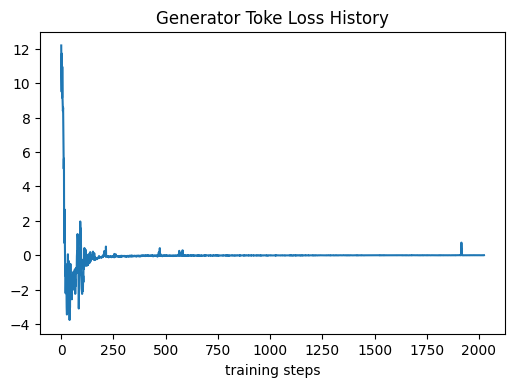

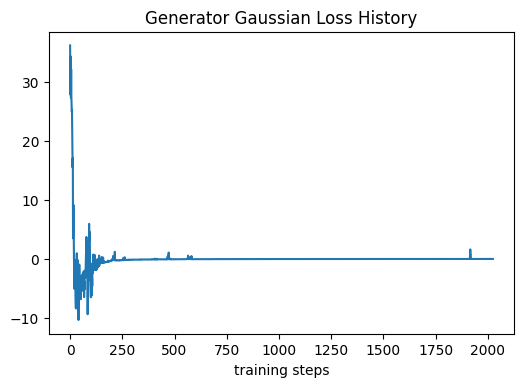

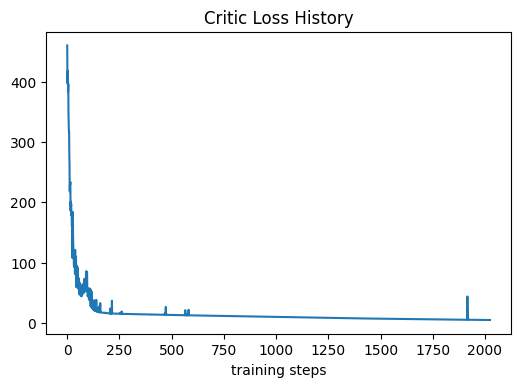

In [18]:
x = range(len(gen_token_loss_history))
plt.figure(dpi=100)
plt.plot(x, gen_token_loss_history)
plt.title('Generator Toke Loss History')
plt.xlabel('training steps')

x = range(len(gen_gaussian_loss_history))
plt.figure(dpi=100)
plt.plot(x, gen_gaussian_loss_history)
plt.title('Generator Gaussian Loss History')
plt.xlabel('training steps')

x = range(len(critic_network_loss_history))
plt.figure(dpi=100)
plt.plot(x, critic_network_loss_history)
plt.title('Critic Loss History')
plt.xlabel('training steps')

Text(0.5, 0, 'training steps')

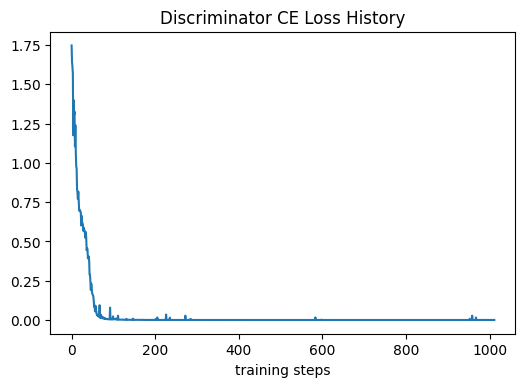

In [19]:
x = range(len(disc_ce_loss_history))
plt.figure(dpi=100)
plt.plot(x, disc_ce_loss_history)
plt.title('Discriminator CE Loss History')
plt.xlabel('training steps')

In [20]:
loss_save_dir = './experiment_results/after_1000_steps/loss'
if not os.path.exists(loss_save_dir):
    os.makedirs(loss_save_dir)

with open(os.path.join(loss_save_dir, 'gen_token_loss_history.pickle'), 'wb') as f:
    pickle.dump(gen_token_loss_history, f)

with open(os.path.join(loss_save_dir, 'gen_gaussian_loss_history.pickle'), 'wb') as f:
    pickle.dump(gen_gaussian_loss_history, f)
    
with open(os.path.join(loss_save_dir, 'critic_network_loss_history.pickle'), 'wb') as f:
    pickle.dump(critic_network_loss_history, f)

with open(os.path.join(loss_save_dir, 'disc_ce_loss_history.pickle'), 'wb') as f:
    pickle.dump(disc_ce_loss_history, f)

## 1000 steps: Save G and D models

In [21]:
G_save_dir = './experiment_results/after_1000_steps/gen_weights'
if not os.path.exists(G_save_dir):
    os.makedirs(G_save_dir)
    
G_save_path = os.path.join(G_save_dir, 'gen_model.tf')
generator.save_weights(G_save_path)

In [22]:
D_save_dir = './experiment_results/after_1000_steps/disc_weights'
if not os.path.exists(D_save_dir):
    os.makedirs(D_save_dir)
    
D_save_path = os.path.join(D_save_dir, 'disc_model.tf')
discriminator.save_weights(D_save_path)

## 1000 steps: Generate sequences 

In [85]:
N_gen = 10000
generated_seqs = generate_sequences(N_gen, generator, batch_size=BATCH_SIZE, T=T, recover_to_timestamp=True)

In [86]:
generated_seqs_save_dir = './experiment_results/after_1000_steps/generated_seqs'
if not os.path.exists(generated_seqs_save_dir):
    os.makedirs(generated_seqs_save_dir)

with open(os.path.join(generated_seqs_save_dir, 'generated_seqs.pickle'), 'wb') as f:
    pickle.dump(generated_seqs, f)

In [88]:
generated_seqs[1]

[[1.0, 0.0],
 [2.0, 1.3002667310466152],
 [3.0, 11.654037079303952],
 [4.0, 21.063379206255497],
 [5.0, 24.928569388155715],
 [4.0, 29.114857591578044],
 [3.0, 35.83580828049241],
 [5.0, 37.84611928774895],
 [5.0, 44.91673527873017],
 [5.0, 49.17108130114729],
 [2.0, 55.163227719417534],
 [3.0, 62.62194307667911],
 [3.0, 69.81598533276615],
 [3.0, 76.90111486269288],
 [2.0, 77.98126050731028],
 [2.0, 82.53818380702324],
 [3.0, 93.06889500196077],
 [2.0, 95.88260333724963],
 [2.0, 103.18215125338476],
 [2.0, 114.50894525882354],
 [3.0, 122.68785401737117]]